# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Part 1: Project Definition

Through this project I am trying to determine which what type of customer typology we are able to determine form the data provided by the mail-order company, in order to establish the most likey and unlikely people to purchase their products.

I have personally chosen this project due to the fact that I find it very interesting and has a real-life application in any industry one chooses (or ends up) working in.

Being able to do a proper customer segmentation and targeting is the foundation for any successful business (other than having a good product to begin with). From personal experience, companies are investing a lot of resources in trying to come up with the best and most close-to-reality customer archetypes, in order to be able to better concentrate their resources when it comes to branded/non-branded advertising and building a healthy pipeline when it comes to the customer universe.

I will use 2 algorithms for :

1. Unsupervised modelling: determinig clusters by using PCA and KMeans
2. Supervised learning: by using XGBoost and GradientBoosting.

The unsupervised modelling uses 2 very common techniques: PCA: principal component analysis- in order to perform dimensionality reduction, so that we may group all te features that seem to be somewhat correlated together.

The supervised methods is using 2 powerful algortihms named XGBoost, and also GradientBoosting - the choice for these two comes mostly form the fact that the training data we will work with is very sparse. The response data coming from customers is not so well defined, therefore we need to try models that perform well when we don't have enough data.

Gradient boosting is a supervised learning algorithm, which attempts to accurately predict a target variable by combining the estimates of a set of simpler, weaker models.

We need to use models that would learn form previous weaker iterations..

I will describe however the metics used in the next parts of the project.

In [72]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from collections import Counter

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 2: Analysis

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [73]:
# load in the data- I had to first download the data and save it again in the directory from the workspace, as I did not have enough computational power in the workspace
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\lupascu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [74]:
# azdias.drop()
azdias= azdias.drop(['Unnamed: 0'], axis=1) # the file creates one extra column

In [ ]:
customers= customers.drop(['Unnamed: 0'], axis=1) # the file creates one extra column

In [75]:
customers= customers.drop(['Unnamed: 0'], axis=1)

## Step 2.1: Preliminary comparison of the demographics data vs customers one in terms of rough individual groups.

To start off I have loaded the eneral population and customers into pandas DataFrames.

In here we will focus on the way the 2 datasets compare when it comes to the type of individuals represented in both.

We do a short exploration of the 2 data sets bi checking for both:

- Gender Groups;
- Age (a quick introspection of both age groups by 10 year buckets, but also by generation);
- Income levels;

In [76]:
# Checking the structure  of the demographics data in a visual way

display(azdias.head(10))

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [77]:
# Checking the structure  of the customers data in a visual way

display(customers.head(10))

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


In [78]:
#  gender analysis - ANREDE_KZ feature

# azdias_gender= azdias.groupby(['ANREDE_KZ']).agg(gender_cnt=('LNR', pd.Series.nunique)).sort_values(['gender_cnt'], ascending=False)

azdias_gender = azdias.groupby('ANREDE_KZ')['LNR'].agg([('pop_cnt','count')]).reset_index()
azdias_gender['Source of Data']='General Population data'
azdias_gender['Gender']=azdias_gender['ANREDE_KZ'].replace({1: 'male', 2: 'female', 0: 'unknown'})
azdias_gender['% Percent Gender']=100*azdias_gender['pop_cnt']/azdias.shape[0]
#display(azdias_gender)

customers_gender=customers.groupby('ANREDE_KZ')['LNR'].agg([('pop_cnt','count')]).reset_index()
customers_gender['Source of Data']='Customers data'
customers_gender['Gender']=customers_gender['ANREDE_KZ'].replace({1: 'male', 2: 'female', 0: 'unknown'})
customers_gender['% Percent Gender']=100*customers_gender['pop_cnt']/customers.shape[0]
#display(customers_gender)

azdias_cx_gender=azdias_gender.append(customers_gender, ignore_index=True)
display(azdias_cx_gender)

,ANREDE_KZ,pop_cnt,Source of Data,Gender,% Percent Gender
0,1,425916,General Population data,male,47.790167
1,2,465305,General Population data,female,52.209833
2,1,119508,Customers data,male,62.356772
3,2,72144,Customers data,female,37.643228


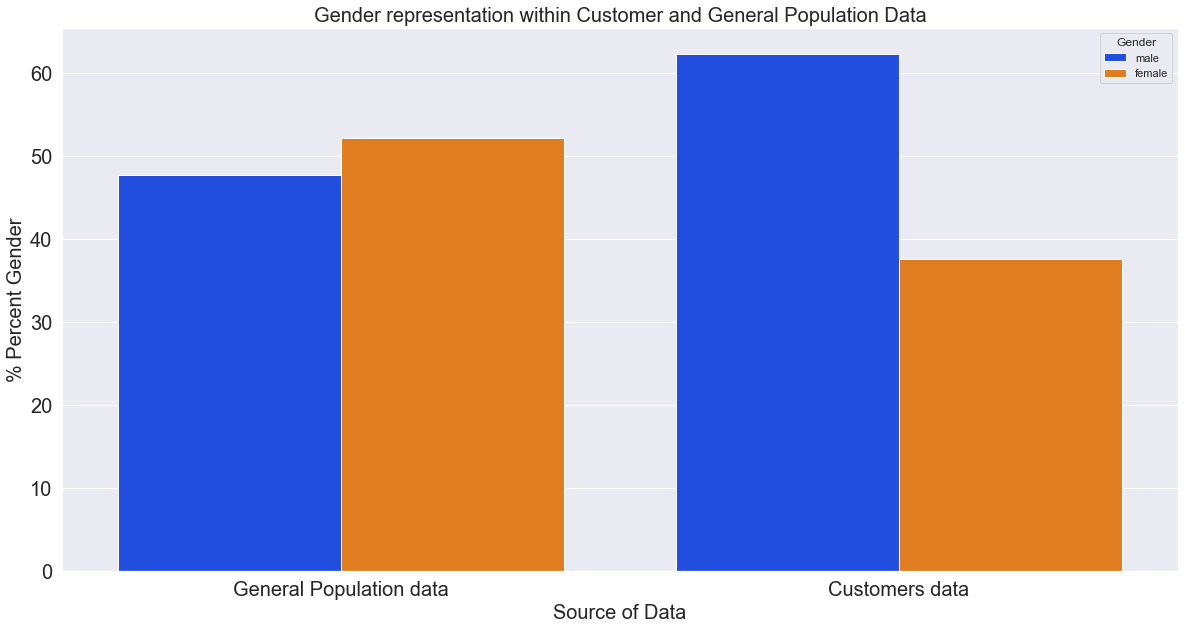

In [79]:
#  gender analysis - ANREDE_KZ feature PLOTTING A NICE GRAPH

to_plot=azdias_cx_gender.iloc[:, 2:]

sns.set(rc={'figure.figsize':(20,10)})
palette = sns.color_palette("bright")
plt.rc('axes', titlesize=20)    
plt.rc('axes', labelsize=20)   
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=20)

plt.xlabel('Source of data')
plt.ylabel('Percent of Gender representation')
plt.title('Gender representation within Customer and General Population Data', fontsize=20)
ax = sns.barplot(x='Source of Data', y='% Percent Gender', hue='Gender', data=to_plot, palette=palette)

*** It seems that while the general population data seems pretty well balanced in terms of gender, our customers data is not -in the sense that the male population represents 62% of the data, while the female one is only 38%.

A class unbalance when it comes to gender in the customers data might lead to biased results in analyzing it.

Further questions arise from this: are the products leaning towards the male population more, is the customer base predominantly male, is the product targeting more male population than female, how was the data collected?

A model that learns on imbalanced data will be prone to make predicitions based on the class that contains more information. ***

,Generational Group,pop_cnt,Source of Data,% Percent Generational Group
15,Unknown,93027,Customer Population Data,48.539540
7,Unknown,392322,General Population Data,44.020731
14,The Silent Generation: 1928-1945,39754,Customer Population Data,20.742805
8,Baby Boomers: 1946-1964,38027,Customer Population Data,19.841692
3,Generation X: 1965-1980,157073,General Population Data,17.624472
0,Baby Boomers: 1946-1964,150564,General Population Data,16.894126
5,Millennials: 1981-1996,110250,General Population Data,12.370669
11,Generation X: 1965-1980,13960,Customer Population Data,7.284036
6,The Silent Generation: 1928-1945,60247,General Population Data,6.760052
10,Born before 1928,4106,Customer Population Data,2.142425


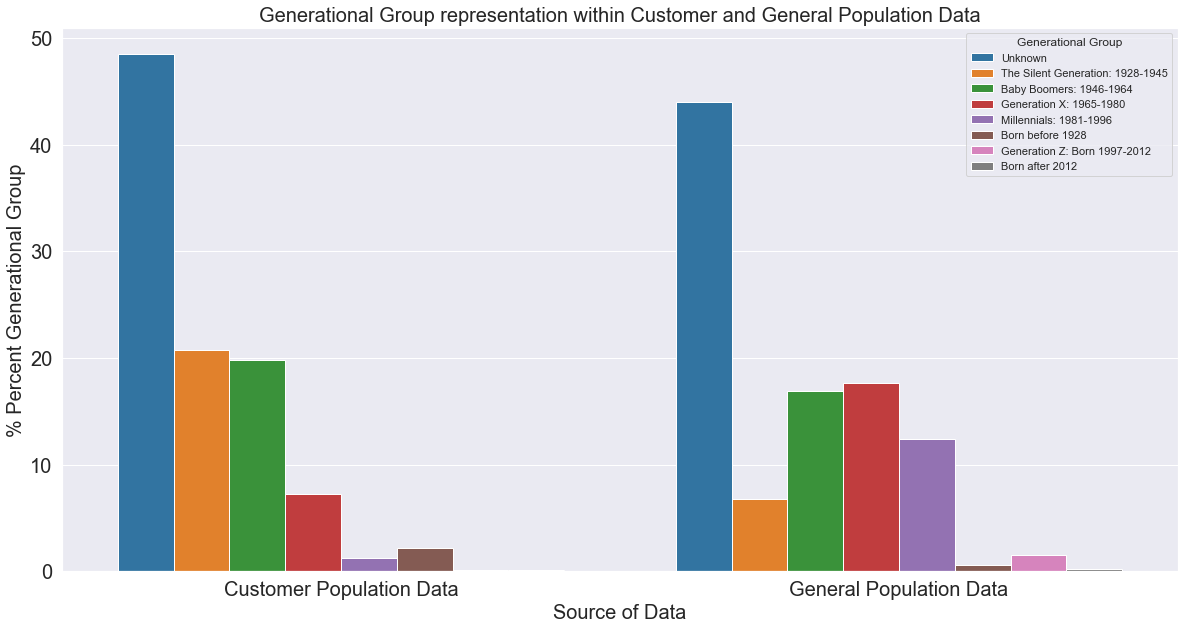

In [80]:
# year of birth analysis - GEBURTSJAHR feaure

################################## GENERATIONAL GROUP ANALYSIS ##################################

# We have some major generational groups that are defined by the era they have been born in. 
#The main generational groups are considered to be the ones below:

#The Silent Generation: Born 1928-1945. 
#Baby Boomers: Born 1946-1964.
#Generation X: Born 1965-1980.
#Millennials: Born 1981-1996.
#Generation Z: Born 1997-2012.


################# general population data #################


azdias_yob= azdias.groupby('GEBURTSJAHR')['LNR'].agg([('pop_cnt','count')]).reset_index()
azdias_yob['Age']=2022-azdias_yob['GEBURTSJAHR']

# we create the generation buckets:

age_list_a=[[0, 1901], [1901, 1928], [1928, 1946], [1946, 1965], [1965, 1981], [1981, 1997], [1997, 2013], [2013, 2022]]
gen_label_list_a=[ 'Unknown',
                 'Born before 1928',
                 'The Silent Generation: 1928-1945', 
                 'Baby Boomers: 1946-1964', 
                 'Generation X: 1965-1980', 
                 'Millennials: 1981-1996', 
                 'Generation Z: Born 1997-2012',
                 'Born after 2012']

year_list_a=azdias_yob['GEBURTSJAHR'].values.tolist()

gen_list_a=[]

for ii in range(len(year_list_a)):
    for i in range(len(gen_label_list_a)):
        if (age_list_a[i][0] <= year_list_a[ii]) and (year_list_a[ii] <age_list_a[i][1]):
            gen_list_a.append(gen_label_list_a[i])

azdias_yob['Generational Group'] =gen_list_a
azdias_yob_p= azdias_yob.groupby('Generational Group')['pop_cnt'].agg([('pop_cnt','sum')]).reset_index()
azdias_yob_p['Source of Data']='General Population Data'
azdias_yob_p['% Percent Generational Group']= 100*azdias_yob_p['pop_cnt']/azdias.shape[0]

#display(azdias_yob)


################# customer data #################

customers_yob= customers.groupby('GEBURTSJAHR')['LNR'].agg([('pop_cnt','count')]).reset_index()
customers_yob['Age']=2022-customers_yob['GEBURTSJAHR']

# we create the generation buckets:

age_list_c=[[0, 1901], [1901, 1928], [1928, 1946], [1946, 1965], [1965, 1981], [1981, 1997], [1997, 2013], [2013, 2022]]
gen_label_list_c=[ 'Unknown',
                 'Born before 1928',
                 'The Silent Generation: 1928-1945', 
                 'Baby Boomers: 1946-1964', 
                 'Generation X: 1965-1980', 
                 'Millennials: 1981-1996', 
                 'Generation Z: Born 1997-2012',
                 'Born after 2012']

year_list_c=customers_yob['GEBURTSJAHR'].values.tolist()

gen_list_c=[]

for ii in range(len(year_list_c)):
    for i in range(len(gen_label_list_c)):
        if (age_list_c[i][0] <= year_list_c[ii]) and (year_list_c[ii] <age_list_c[i][1]):
            gen_list_c.append(gen_label_list_c[i])

customers_yob['Generational Group'] =gen_list_c
customers_yob_p= customers_yob.groupby('Generational Group')['pop_cnt'].agg([('pop_cnt','sum')]).reset_index()
customers_yob_p['Source of Data']='Customer Population Data'
customers_yob_p['% Percent Generational Group']= 100*customers_yob_p['pop_cnt']/customers.shape[0]


#display(customers_yob)

azdias_cx_yob=azdias_yob_p.append(customers_yob_p, ignore_index=True).sort_values(['% Percent Generational Group'], ascending=False)
display(azdias_cx_yob)


# year of birth analysis - GEBURTSJAHR feaure plotting generational graph

to_plot=azdias_cx_yob[['Generational Group', 'Source of Data', '% Percent Generational Group']]
sns.set(rc={'figure.figsize':(20,10)})
palette = sns.color_palette("tab10")
plt.rc('axes', titlesize=20)    
plt.rc('axes', labelsize=20)   
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=20)

plt.xlabel('Source of data')
plt.ylabel('Percent of Generational Group representation')
plt.title('Generational Group representation within Customer and General Population Data', fontsize=20)
ax = sns.barplot(x='Source of Data', y='% Percent Generational Group', hue='Generational Group', data=to_plot, palette=palette)


,Generational Group,pop_cnt,Source of Data,% Percent Generational Group
14,Unknown,93024,Customer Population Data,48.537975
6,Unknown,392318,General Population Data,44.020282
13,65 or over,69109,Customer Population Data,36.059629
5,65 or over,147929,General Population Data,16.598464
4,55 to 64,101393,General Population Data,11.376864
3,45 to 54,94661,General Population Data,10.621496
2,35 to 44,89675,General Population Data,10.062038
12,55 to 64,17323,Customer Population Data,9.038779
1,25 to 34,53807,General Population Data,6.037448
11,45 to 54,8204,Customer Population Data,4.280675


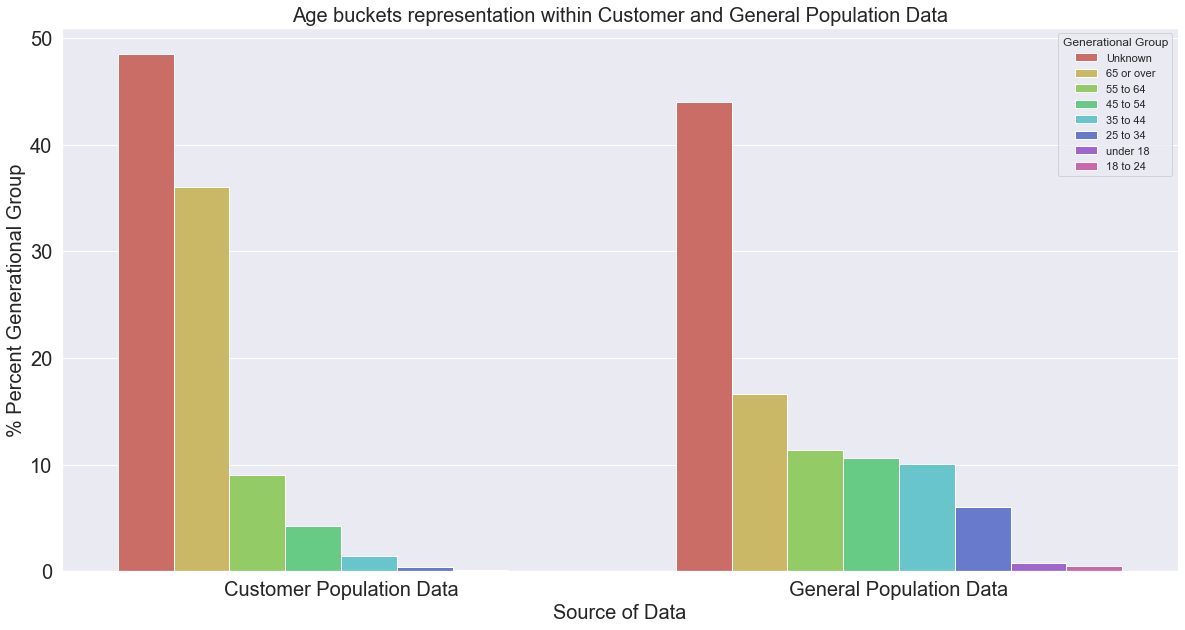

In [81]:
# year of birth analysis - GEBURTSJAHR feaure age brackets

################################## AGE GROUP ANALYSIS ##################################


#We split the age groups based on the below intervals

#under 18
#18 to 24
#25 to 34
#35 to 44
#45 to 54
#55 to 64
#65 or over


################# general population data #################


# we create the age buckets:

age_list_a=[[0, 19], [19, 25], [25, 35], [35, 45], [45, 55], [55, 65], [65, 123], [123, 2023]]
gen_label_list_a=['under 18',
                  '18 to 24',
                  '25 to 34', 
                  '35 to 44', 
                  '45 to 54', 
                  '55 to 64', 
                  '65 or over',
                  'Unknown'
                 ]

year_list_a=azdias_yob['Age'].values.tolist()

gen_list_a=[]

for ii in range(len(year_list_a)):
    for i in range(len(gen_label_list_a)):
        if (age_list_a[i][0] <= year_list_a[ii]) and (year_list_a[ii] <age_list_a[i][1]):
            gen_list_a.append(gen_label_list_a[i])

azdias_yob['Generational Group'] =gen_list_a
azdias_yob_p= azdias_yob.groupby('Generational Group')['pop_cnt'].agg([('pop_cnt','sum')]).reset_index()
azdias_yob_p['Source of Data']='General Population Data'
azdias_yob_p['% Percent Generational Group']= 100*azdias_yob_p['pop_cnt']/azdias.shape[0]


################# customers population data #################


age_list_c=[[0, 19], [19, 25], [25, 35], [35, 45], [45, 55], [55, 65], [65, 123], [123, 2023]]
gen_label_list_c=['under 18',
                  '18 to 24',
                  '25 to 34', 
                  '35 to 44', 
                  '45 to 54', 
                  '55 to 64', 
                  '65 or over',
                  'Unknown'
                 ]

year_list_c=customers_yob['Age'].values.tolist()

gen_list_c=[]

for ii in range(len(year_list_c)):
    for i in range(len(gen_label_list_c)):
        if (age_list_c[i][0] <= year_list_c[ii]) and (year_list_c[ii] <age_list_c[i][1]):
            gen_list_c.append(gen_label_list_c[i])

customers_yob['Generational Group'] =gen_list_c
customers_yob_p= customers_yob.groupby('Generational Group')['pop_cnt'].agg([('pop_cnt','sum')]).reset_index()
customers_yob_p['Source of Data']='Customer Population Data'
customers_yob_p['% Percent Generational Group']= 100*customers_yob_p['pop_cnt']/customers.shape[0]



azdias_cx_agebuck=azdias_yob_p.append(customers_yob_p, ignore_index=True).sort_values(['% Percent Generational Group'], ascending=False)
display(azdias_cx_agebuck)



# year of birth analysis - GEBURTSJAHR feaure plotting age buckets graph

to_plot_age=azdias_cx_agebuck[['Generational Group', 'Source of Data', '% Percent Generational Group']]
sns.set(rc={'figure.figsize':(20,10)})
palette = sns.color_palette("hls", 8)
plt.rc('axes', titlesize=20)    
plt.rc('axes', labelsize=20)   
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=20)

plt.xlabel('Source of data')
plt.ylabel('Percent of age buckets representation')
plt.title('Age buckets representation within Customer and General Population Data', fontsize=20)
ax_age = sns.barplot(x='Source of Data', y='% Percent Generational Group', hue='Generational Group', data=to_plot_age, palette=palette)



***Observations:

While the General Population data has most representations within the 'Baby Boomers: 1946-1964', 'Generation X: 1965-1980', and 'Millennials: 1981-1996' (which are the main dominant groups within the identified generations), in the Customers file we see a surprising generational percentage: The customer generational groups are dominated by The Silent Generation: 1928-1945', 
and the 'Baby Boomers: 1946-1964'. Because of this, we have to ask ourselves questions again: is the data set biased? Would a better representation of the customer subset be necessary? We need to be careful when analyzing data which contains unbalanced classes.

Or, is the data jst showing us a situation in which we see older generations more prone to use mail order, rather than other means of purchasing.

What is however present in both data sets is the fact that we have the biggest percentage under the "Unknown" group- meaning both data sets contain an impressive amount of rows/people that are not labeled according to the age/birth year.
In this situation- we need to ask ourselves: does birth year matter in an analysis like this? 
Also, since the majority of data is not labeled accordingly for this feature, should we opt to keep this information in or not?***

,HH_EINKOMMEN_SCORE,pop_cnt,Source of Data,Estimated Household Net Income,% Percent Household Income Types
9,2.0,70160,Customers data,very high income,36.608019
6,6.0,252775,General Population data,very low income,28.362774
5,5.0,201482,General Population data,lower income,22.607412
2,2.0,140817,General Population data,very high income,15.800458
4,4.0,139762,General Population data,average income,15.682081
8,1.0,29936,Customers data,highest income,15.619978
11,4.0,27674,Customers data,average income,14.439714
12,5.0,23923,Customers data,lower income,12.482520
10,3.0,22438,Customers data,high income,11.707679
3,3.0,84805,General Population data,high income,9.515597


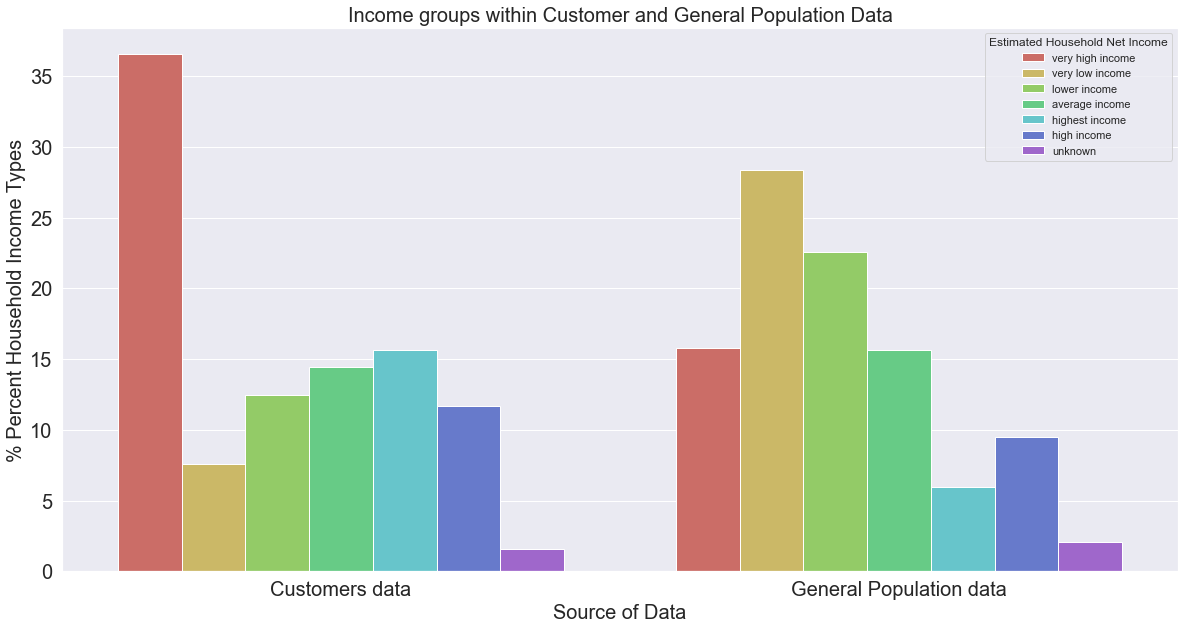

In [82]:
# income analysis - HH_EINKOMMEN_SCORE feature

# replacing all nans with 0 for this column
azdias_df=pd.DataFrame(azdias)

azdias_df['HH_EINKOMMEN_SCORE'] = azdias_df['HH_EINKOMMEN_SCORE'].fillna(0)
azdias_income = azdias_df.groupby('HH_EINKOMMEN_SCORE')['LNR'].agg([('pop_cnt','count')]).reset_index()
azdias_income['Source of Data']='General Population data'
azdias_income['Estimated Household Net Income']=azdias_income['HH_EINKOMMEN_SCORE'].replace({-1: 'unknown', 0: 'unknown',  1:'highest income', 2:'very high income', 3:'high income', 4:'average income', 5:'lower income', 6:'very low income'})
azdias_income['% Percent Household Income Types']=100*azdias_income['pop_cnt']/azdias_df.shape[0]
#display(azdias_income)

# replacing all nans with 0 for this column

customers_df = pd.DataFrame(customers)
customers_df['HH_EINKOMMEN_SCORE'] = customers['HH_EINKOMMEN_SCORE'].fillna(0)
customers_income=customers_df.groupby('HH_EINKOMMEN_SCORE')['LNR'].agg([('pop_cnt','count')]).reset_index()
customers_income['Source of Data']='Customers data'
customers_income['Estimated Household Net Income']=customers_income['HH_EINKOMMEN_SCORE'].replace({-1: 'unknown', 0: 'unknown',  1:'highest income', 2:'very high income', 3:'high income', 4:'average income', 5:'lower income', 6:'very low income'})
customers_income['% Percent Household Income Types']=100*customers_income['pop_cnt']/customers_df.shape[0]
#display(customers_income)

azdias_cx_income=azdias_income.append(customers_income, ignore_index=True).sort_values(['% Percent Household Income Types'], ascending=False)
display(azdias_cx_income)

# year of birth analysis - HH_EINKOMMEN_SCORE feaure plotting income categories

to_plot_age=azdias_cx_income[['Estimated Household Net Income', 'Source of Data', '% Percent Household Income Types']]
sns.set(rc={'figure.figsize':(20,10)})
palette = sns.color_palette("hls", 8)
plt.rc('axes', titlesize=20)    
plt.rc('axes', labelsize=20)   
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=20)

plt.xlabel('Source of data')
plt.ylabel('Percent of income groups representation')
plt.title('Income groups within Customer and General Population Data', fontsize=20)
ax_age = sns.barplot(x='Source of Data', y='% Percent Household Income Types', hue='Estimated Household Net Income', data=to_plot_age, palette=palette)


***Observations:

What we see in the customers vs general population data goes in line with the preliminary analysis of our age and generational groups- customers data seems to contain a large representation within the very high amd highest income individuals- which in term could be related to the fact that older generations have more income to spend, than younger ones. Also, the representation is more prone to showing people that have a more inclined mindset towards savings, insurance, etc.

As well, the general population shows the reality of the world we live in: the most representative group is the one of very low income and lower income . From this point of view, data seems to reflect the reality of our times.***

## Step 2.2: Assess Structure and  Data Types

We do a short exploration of the 2 data sets by checking:

- Structure
- Data types
- Data values balance (meand, std)

In [14]:
# Check the structure of the demographics data for the general population after it's loaded
# rows and columns

print(azdias.shape[:])

print('Number of rows is {}, and we have {} columns'.format(azdias.shape[0],azdias.shape[1]))

(891221, 366)
Number of rows is 891221, and we have 366 columns


In [15]:
# Check the structure of the customers data for the general population after it's loaded
# rows and columns

print(customers.shape[:])

print('Number of rows is {}, and we have {} columns'.format(customers.shape[0],customers.shape[1]))

(191652, 369)
Number of rows is 191652, and we have 369 columns


In [16]:
# Column types of the demographics data set

pd.DataFrame(azdias.dtypes, columns=['DATA_TYPE']).DATA_TYPE.value_counts()

float64    267
int64       93
object       6
Name: DATA_TYPE, dtype: int64

In [17]:
# # Column types of the customers data set

pd.DataFrame(customers.dtypes, columns=['DATA_TYPE']).DATA_TYPE.value_counts()

float64    267
int64       94
object       8
Name: DATA_TYPE, dtype: int64

In [18]:
################## GETTING A ROUGH IDEA ABOUT THE MIXED COLUMNS WE HAVE ################### 

from pandas.api.types import infer_dtype

azdias_cols=azdias.columns.tolist()
customers_cols=customers.columns.tolist()
azdias_mixed_cols=[]
azdias_col_types=[]
customers_mixed_cols=[]
customers_col_types=[]

mixed_total_cols=[]

for column in azdias.columns:
    azdias_col_types.append(pd.api.types.infer_dtype(azdias[column]))
for column in customers.columns:
    customers_col_types.append(pd.api.types.infer_dtype(customers[column]))
    
for types in range(len(azdias_col_types)):
    if azdias_col_types[types] == 'mixed':
        azdias_mixed_cols.append(azdias_cols[types])
        
for types in range(len(customers_col_types)):
    if customers_col_types[types] == 'mixed':
        customers_mixed_cols.append(customers_cols[types])

#for type in range(len(mixed_types)):

mixed_total_cols=np.unique(np.array(azdias_mixed_cols + customers_mixed_cols)).tolist()
print('All columns that have mixed values are:')
print(mixed_total_cols)


################## GETTING A ROUGH IDEA ABOUT THE OBJECT TYPE COLUMNS WE HAVE ################### 

categ_total_cols= np.unique(np.array(azdias.select_dtypes(include=['object']).columns.tolist() + 
                           customers.select_dtypes(include=['object']).columns.tolist())).tolist()
print()
print('All columns that are of object type are:')
print(categ_total_cols)

All columns that have mixed values are:
['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

All columns that are of object type are:
['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'CUSTOMER_GROUP', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'PRODUCT_GROUP']


In [19]:
# we investigate a bit more the 2 object-type extra columns coming from the customers data set:

print(customers['CUSTOMER_GROUP'].unique().tolist())
print(customers['PRODUCT_GROUP'].unique().tolist())
print(customers['ONLINE_PURCHASE'].unique().tolist())

['MULTI_BUYER', 'SINGLE_BUYER']
['COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC']
[0, 1]


In [20]:
print(customers['OST_WEST_KZ'].unique().tolist())

['W', nan, 'O']


In [21]:
# trying to make sense of the demographics data, and see how it looks like in terms of mean vs std

azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [22]:
# trying to make sense of the customers data, and see how it looks like in terms of mean vs std

customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


***Observations:

We notice that we have 3 main data types in our columns (both data sets): 
 - integer : dtype('int64') 
 - floats: dtype('float64') 
 - stringsdtype('O')
 
The data types do not indicate anything unusual, however we need to also make sure that we don't have any other anomalies within the data sets.
Since we received an error at the loading time of the data, it is obvious that we might have columns that have mixed data types.

As well, we need to check for categorical features, and treat them as well.

For this purpose, I have managed to use the [.select_dtypes(include=['object'])] method and the [infer_dtype] one which revealed the following 8 columns as being of 'object type', which might be categorical and contain mixed values (6 are overlapping between the 2 data sets, and we will get to analyze them in more details in the upcoming steps of the project- in ***Data Preprocessing***):

For the general population data:
- 'CAMEO_DEUG_2015' : CAMEO classification 2015 - Uppergroup
- 'CAMEO_DEU_2015' : CAMEO classification 2015 - detailled classification
- 'CAMEO_INTL_2015' : description missing from the features files, but possibly is CAMEO_DEUINTL_2015
- 'D19_LETZTER_KAUF_BRANCHE': description missing (eng translation: LAST PURCHASE INDUSTRY)
- 'EINGEFUEGT_AM': description missing (eng translation: INSERTED ON)
- 'OST_WEST_KZ': flag indicating the former GDR/FRG


For the customers data:
- 'CAMEO_DEUG_2015' : CAMEO classification 2015 - Uppergroup
- 'CAMEO_DEU_2015' : CAMEO classification 2015 - detailled classification
- 'CAMEO_INTL_2015' : description missing from the features files, but possibly is CAMEO_DEUINTL_2015
- 'CUSTOMER_GROUP' : info about the customer group the customer belongs to
- 'D19_LETZTER_KAUF_BRANCHE': description missing (eng translation: LAST PURCHASE INDUSTRY)
- 'EINGEFUEGT_AM': description missing (eng translation: INSERTED ON) 
- 'OST_WEST_KZ': flag indicating the former GDR/FRG
- 'PRODUCT_GROUP': info about the product group the customer belongs to

In the next steps, we will try to reduce the missing amount of data as much as possible for the rows and columns, and also engineer the mixed features and one-hot encode the mcategorical ones.***

## Part 3: Methodology: Data Preprocessing, Implementation, and Refinement

Preprocessing is a very important step within our data analysis and lean-up.
The data itself might have many missing values, therefore preprocessing and cleaning the data up is a very important part of the project, if not the most time-consuming.

The preprocessing portion of the data implies several steps:

- 3.1 Assess Missing Data
         - 3.1.1 Assess Missing Data in Each Column (for general population data)
         - 3.1.2 Assess Missing Data in Each Row (for general population data)
- 3.2 Select and Re-Encode Features (categorical and mixed)
             - 3.2.1 Re-Encode Categorical Features (for general population data)
             - 3.2.2 Engineer Mixed-Type Features (for general population data)
- 3.3 Creating 2 Cleaning Functions (one for supervised, and one for unsupervised model, which would encompass all of the above steps)
             - Reason for this function is to be able to clean - up the customers data in the same manner as general population 



## Part 3A: Methodology: Data Preprocessing

### Step 3.1: Assess Missing Data Overall - Data Preprocessing

In this step of the project, we go through the data sets and try to identify as many gaps as possible. 
First, we try to identify how much missing data we have overall for both data sets. 

Missing data is usually one of the first steps within any data engineering and machine learning process. Being able to identify the gaps and having a clear overview of how many things we are missing from our data sets will help us in determining what features we wish to keep, and which ones we decide to let go, due to too much lacking information.

Usualy,large volumes of missing data can affect in a very bad way our model learning process, so we try to minimize as much as possible the amount of missing data, in order to not get ourselves in a biased end result.

In [23]:
# we try to see how many NULL values we have in entire dataset by using the .sum() method twice (sum of a sum)

azdias_initial_nulls=azdias.isnull().sum().sum()

# finding out how much of the data is actually missing
print('Total number of NULL values for the demographics data, is: {}'. format(azdias_initial_nulls))
print('For the demographics data, we have approximately {} % of the data missing overall'. format(100*azdias.isnull().sum().sum()/(azdias.shape[0]*azdias.shape[1])))

Total number of NULL values for the demographics data, is: 33474575
For the demographics data, we have approximately 10.262391419377908 % of the data missing overall


In [24]:
# we try to see how many NULL values we have in entire dataset by using the .sum() method twice (sum of a sum)

customers_initial_nulls=customers.isnull().sum().sum()
print(customers_initial_nulls)

# finding out how much of the data is actually missing

print('Total number of NULL values for the customers data, is: {}'. format(customers_initial_nulls))
print('For the customers data, we have approximately {} % of the data missing overall'. format(100*customers.isnull().sum().sum()/(customers.shape[0]*customers.shape[1])))

13861554
Total number of NULL values for the customers data, is: 13861554
For the customers data, we have approximately 19.60072787754363 % of the data missing overall


***Observations: 
As we see quite the NULL info, this migt pose some problems in the upcoming processes.
We need to decide what to do, do we drop them or not- we see approximately 10% of demographics data missing, and approxmately 20% of the customers one missing overall....
Some extra information is needed, regarding how much information is actually missing in each column- and do an estimation of how many columns and rows do we actually need to drop***

#### Step 3.1.1: Assess Missing Data in Each Column and dropping problematic features.

############################### GENERAL POPULATION DATA #############################

We go through the data sets and try to identify as many gaps as possible within the columns. 
This is a crucial step in preparing our data for analysis, as this way we see the most compromised columns overall, and decide if we keep them or not.

As an interval- I chose to keep columns that have at least 67% of their data- meaning 3 thirds.

Any gaps of more than 33.% in a column could mean that we keep information that could potentially affect our model's power in making corect classifications.

In the below steps, I will go through the missing values of general population data. 

In [25]:
# We asses how much missing data we have for the General population data in each of the columns.


# I turn my number of missing values in each column and the column names into a new data frame
null_list=azdias.isna().sum().tolist()
cols_list=azdias.columns.values.tolist()

# I define the dictionary from which I will take my data in the new data frame
d={'FEATURE_NAME': cols_list, 'NULLS_CNT': null_list}

nulls_df=pd.DataFrame(d)
#final_nulls=azdias.isnull().sum().sum()

# I do a verification to see that indeed everything has been replaced- based on the number of missing_unknown values in all data set
print('Initial NaN values are: ', azdias_initial_nulls)
#print('Total mising_unknown values in the dataframe are: ', missing_unknown_ct)
#print('Final NaN values are: {}, and this should be the same as initial_nulls + missing_unkown_ct: {}'. format(final_nulls, (initial_nulls + missing_unknown_ct)))


# I see my newly created dataset
display(nulls_df)

Initial NaN values are:  33474575


,FEATURE_NAME,NULLS_CNT
0,LNR,0
1,AGER_TYP,0
2,AKT_DAT_KL,73499
3,ALTER_HH,73499
4,ALTER_KIND1,810163
...,...,...
361,WOHNDAUER_2008,73499
362,WOHNLAGE,93148
363,ZABEOTYP,0
364,ANREDE_KZ,0


In [26]:
# Investigate patterns in the amount of missing data in each column.

# getting the number of rows in my dataset
n=azdias.shape[0]

# creating a new column in my dataframe- where I calculate what percent of data is missing in each column
nulls_df['PERCENT_MISSING_DATA']= (nulls_df['NULLS_CNT']/n)*100
print(nulls_df)

             FEATURE_NAME  NULLS_CNT  PERCENT_MISSING_DATA
0                     LNR          0              0.000000
1                AGER_TYP          0              0.000000
2              AKT_DAT_KL      73499              8.247000
3                ALTER_HH      73499              8.247000
4             ALTER_KIND1     810163             90.904837
..                    ...        ...                   ...
361        WOHNDAUER_2008      73499              8.247000
362              WOHNLAGE      93148             10.451729
363              ZABEOTYP          0              0.000000
364             ANREDE_KZ          0              0.000000
365  ALTERSKATEGORIE_GROB          0              0.000000

[366 rows x 3 columns]


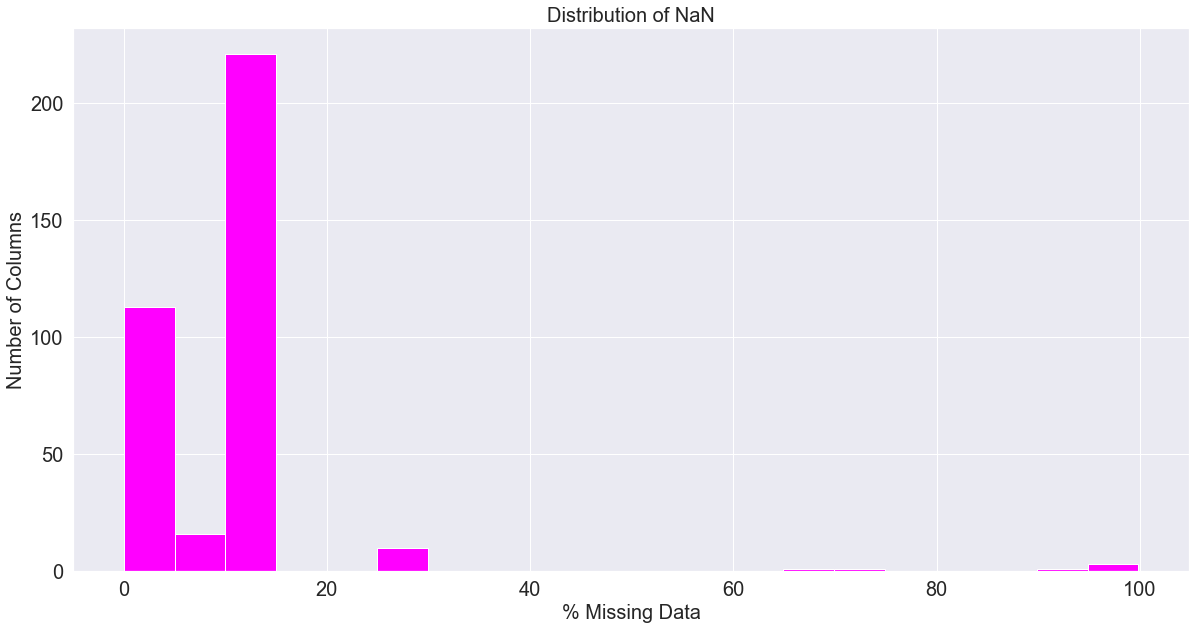

In [27]:
#  Time to also plot my data, based on the new dataset, to have a visual overview of the percent of missing data
sns.set(rc={'figure.figsize':(20,10)})
# the below 5 rows for setting up the font sizes I researched and got from
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

plt.rc('axes', titlesize=20)    
plt.rc('axes', labelsize=20)   
plt.rc('xtick', labelsize=20)  
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=20)
        
x=nulls_df['PERCENT_MISSING_DATA']

plt.hist(x, bins = 20, color = 'magenta')

plt.xlabel('% Missing Data')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN')
plt.show()

In [28]:
# we sort the data frame to have a better overview of the columns percent of missing data and outline the outliers

nulls_df_sorted=nulls_df.sort_values(by=['PERCENT_MISSING_DATA'], ascending=False)
nulls_df_sorted=nulls_df_sorted.reset_index(drop=True) # I had to reset the index, as otherwise it doesn't save it as sorted, we just see it sorted
print(nulls_df_sorted)

                  FEATURE_NAME  NULLS_CNT  PERCENT_MISSING_DATA
0                  ALTER_KIND4     890016             99.864792
1                  ALTER_KIND3     885051             99.307691
2                  ALTER_KIND2     861722             96.690047
3                  ALTER_KIND1     810163             90.904837
4                    EXTSEL992     654153             73.399639
..                         ...        ...                   ...
361          D19_VERSAND_DATUM          0              0.000000
362  D19_VERSAND_OFFLINE_DATUM          0              0.000000
363   D19_VERSAND_ONLINE_DATUM          0              0.000000
364           D19_VERSAND_REST          0              0.000000
365       ALTERSKATEGORIE_GROB          0              0.000000

[366 rows x 3 columns]


In [29]:
# we already see that 6 columns are missing more than 30% of data, and 4 are missing more than 50%, but we group this info in intervals

interval_list=[[0, 25], [25, 50], [50, 75], [75, 101]]
quartile_label_list=['0-24%', '25%-49%', '50%-74%', '75%-100%']
percent_list=nulls_df_sorted['PERCENT_MISSING_DATA'].values.tolist()
quartile_list=[]

for ii in range(nulls_df_sorted.shape[0]):
    for i in range(len(quartile_label_list)): # 4 quartiles
        if (interval_list[i][0] <= percent_list[ii]) and (percent_list[ii] <interval_list[i][1]):
            quartile_list.append(quartile_label_list[i])

nulls_df_sorted['MISSING_DATA_BUCKET'] =quartile_list

print(nulls_df_sorted)

                  FEATURE_NAME  NULLS_CNT  PERCENT_MISSING_DATA  \
0                  ALTER_KIND4     890016             99.864792   
1                  ALTER_KIND3     885051             99.307691   
2                  ALTER_KIND2     861722             96.690047   
3                  ALTER_KIND1     810163             90.904837   
4                    EXTSEL992     654153             73.399639   
..                         ...        ...                   ...   
361          D19_VERSAND_DATUM          0              0.000000   
362  D19_VERSAND_OFFLINE_DATUM          0              0.000000   
363   D19_VERSAND_ONLINE_DATUM          0              0.000000   
364           D19_VERSAND_REST          0              0.000000   
365       ALTERSKATEGORIE_GROB          0              0.000000   

    MISSING_DATA_BUCKET  
0              75%-100%  
1              75%-100%  
2              75%-100%  
3              75%-100%  
4               50%-74%  
..                  ...  
361          

In [30]:
# we compress the datasource by doing a pivot count of columns in each quantile- we see 6 columns with problem

nulls_df_compressed = nulls_df_sorted.groupby(['MISSING_DATA_BUCKET'])['FEATURE_NAME'].count().reset_index()
print(nulls_df_compressed)


  MISSING_DATA_BUCKET  FEATURE_NAME
0               0-24%           350
1             25%-49%            10
2             50%-74%             2
3            75%-100%             4


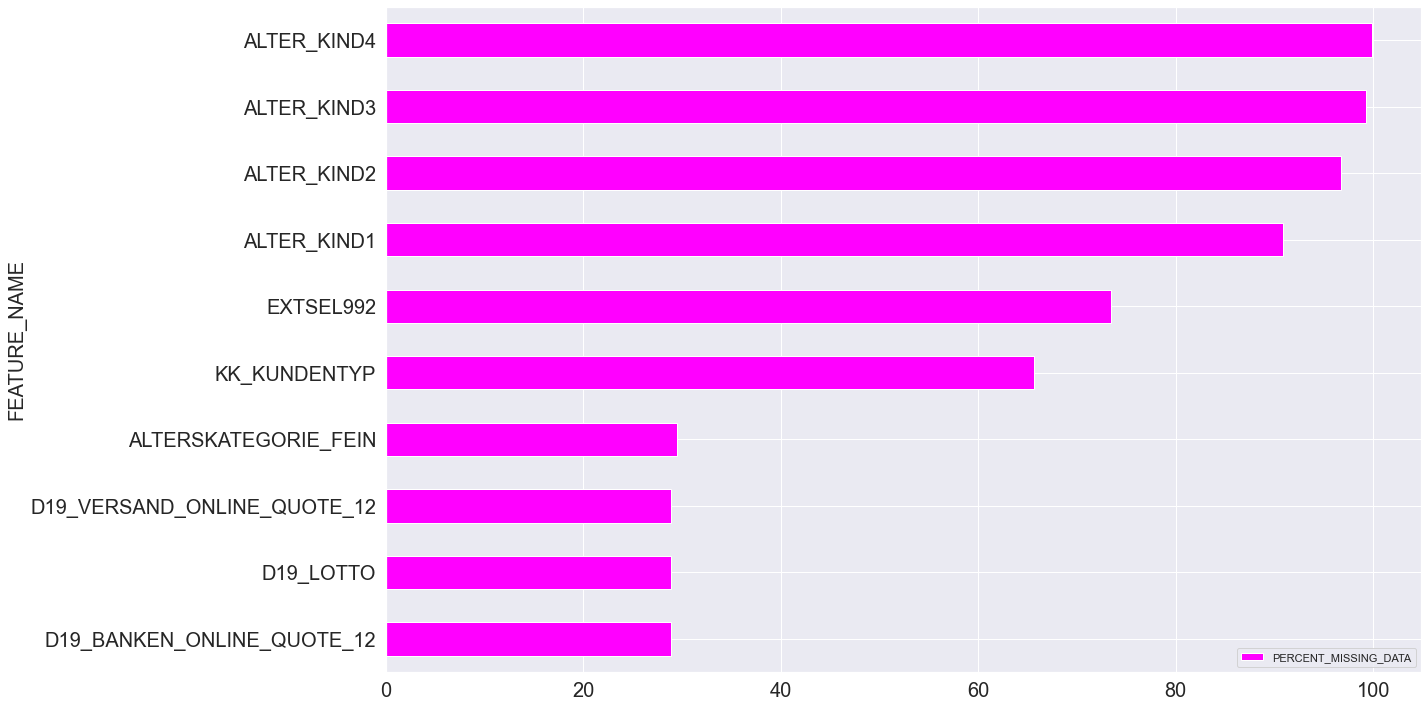

In [31]:
# we overview the first 10 features- and sorted so that we see the first 6 which seem to be outliers

sns.set(rc={'figure.figsize':(20,10)})

# the below 5 rows for setting up the font sizes I researched and got from
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
plt.rc('axes', titlesize=20)    
plt.rc('axes', labelsize=20)   
plt.rc('xtick', labelsize=20)  
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=20)
for_chart=pd.DataFrame(nulls_df_sorted.head(10),columns=['FEATURE_NAME', 'PERCENT_MISSING_DATA']).head(10).groupby(['FEATURE_NAME']).median().sort_values("PERCENT_MISSING_DATA", ascending=True)
barh=for_chart.plot.barh(color='magenta')

plt.tight_layout()


In [32]:
# first we determine our problematic values in the data- I will consider any feature with more than 33% (a third) of data missing, as problematic

problematic_values= [x for x in percent_list if x >33]

# then I will locate my features that fall into this list of values- from the nulls_df_sorted dataframe

problematic_features=pd.DataFrame(nulls_df_sorted.loc[nulls_df_sorted['PERCENT_MISSING_DATA'].isin(problematic_values)])

display(problematic_features)

,FEATURE_NAME,NULLS_CNT,PERCENT_MISSING_DATA,MISSING_DATA_BUCKET
0,ALTER_KIND4,890016,99.864792,75%-100%
1,ALTER_KIND3,885051,99.307691,75%-100%
2,ALTER_KIND2,861722,96.690047,75%-100%
3,ALTER_KIND1,810163,90.904837,75%-100%
4,EXTSEL992,654153,73.399639,50%-74%
5,KK_KUNDENTYP,584612,65.596749,50%-74%


In [33]:
# we have our features, time to separate the names and locate them in our azdias data frame

# we create the list of features
problematic_features_l=problematic_features['FEATURE_NAME'].values.tolist()
print('The Problematic Features are:',problematic_features_l)


The Problematic Features are: ['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992', 'KK_KUNDENTYP']


In [34]:
# we create a new data frame with the dropped columns
azdias_pure = pd.DataFrame(azdias.drop(problematic_features_l, axis=1))

# we compare the old shape with the new one

print('New shape of the dataset is: {}'.format(azdias_pure.shape[:]))
print('Old shape of the dataset is: {}'.format(azdias.shape[:]))

New shape of the dataset is: (891221, 360)
Old shape of the dataset is: (891221, 366)


In [35]:
# we calculate the amount of NaN again for the new dataset

print('New NaN values are overall: {} , vs old NaN values: {} , with a difference of {}'.format(azdias_pure.isnull().sum().sum(), azdias.isnull().sum().sum(), azdias.isnull().sum().sum()-azdias_pure.isnull().sum().sum())) 

New NaN values are overall: 28788858 , vs old NaN values: 33474575 , with a difference of 4685717


In [36]:
# we take a look at the list of columns for new vs old

new_cols_l=list(azdias_pure.columns)
old_cols_l=list(azdias.columns)

# we look at the diference between the 2- so that we make sure we eliminated the correct columns
# the difference should be the same as the problematic feature list
diff_l=list(set(old_cols_l) - set(new_cols_l))
diff_l.sort()
problematic_features_l.sort()

print(diff_l)
print(problematic_features_l)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


***Observations:
Upon inspecting the general population data, we see that we have 6 columns which contain more than 33% of data missing.
The outlier columns are as follows:

- 'ALTER_KIND1': has no description (eng translation: OLD CHILD1)
- 'ALTER_KIND2': has no description (eng translation: OLD CHILD2)
- 'ALTER_KIND3': has no description (eng translation: OLD CHILD3)
- 'ALTER_KIND4': has no description (eng translation: OLD CHILD4)
- 'EXTSEL992': has no description
- 'KK_KUNDENTYP' : consumption movement in the last 12 months

There is another group of features which have around 29% missing data each- these I was in doubt to remove, however I decided to keep them.

In the next steps, I will go over the process of removing rows that have too much info missing.***

#### Step 3.1.2: Assess Missing Data in Each Row and dropping problematic rows.

############################### GENERAL POPULATION DATA #############################

Now I'll perform a similar assessment for the rows of the azdias dataset. 
This is a step as important as the previous one in preparing our data for analysis, as this way we see the most compromised rows overall, and decide if we keep them or not.

How much data is missing in each row? As with the columns, we will see some groups of points that have a very different numbers of missing values. 

I will divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, I will check if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. 

I will select at least five of these columns and compare the distribution of values, and will decide on what to do next.

Moving forward, I will only operate now on the data set that was already cleaned up in previous steps and rid of the columns that have too much missing data.


In [37]:
# How much data is missing in each row of the dataset?

#  we calculate the amount of NaNs in each row of the Dataset
row_nulls_df=pd.DataFrame(azdias_pure.isnull().sum(axis=1), columns=['NULLS_CNT'])

# we track the max value of missing info
max_x=row_nulls_df['NULLS_CNT'].max()
print('Most missing data in a row consists of {} NaN values'.format(max_x))

# we track the rows where we have this max value- because I want to check the below code and see if the ROW_INDEX is stored correctly
df_1=pd.DataFrame(row_nulls_df.loc[row_nulls_df['NULLS_CNT']==max_x])
print(df_1)

# we see 5 rows that are almost empty- as their missing values is 252 columns that are empty.

Most missing data in a row consists of 252 NaN values
        NULLS_CNT
55664         252
350182        252
373501        252
537799        252
826869        252


In [38]:
# we calculate the percentages of missing data for each row, and then we sort the data , but we keep the row-index in a separate columns
# I see index is stored correctly

m=azdias_pure.shape[1]
row_nulls_df['ROW_INDEX']=row_nulls_df.index
row_nulls_df['PERCENT_MISSING_DATA']= (row_nulls_df['NULLS_CNT']/m)*100

row_nulls_df_sorted=row_nulls_df.sort_values(by=['PERCENT_MISSING_DATA'], ascending=False).reset_index(drop=True)

# I am trying to create buckets for the missing data

interval_list=[[0, 16], [16, 31], [31, 66], [66, 101]]
quartile_label_list=['0-15%', '16%-30%', '31%-65%', '66%-100%']
percent_list=row_nulls_df_sorted['PERCENT_MISSING_DATA'].values.tolist()
quartile_list=[]


for ii in range(row_nulls_df_sorted.shape[0]):
    for i in range(len(quartile_label_list)): # 4 quartiles
        if (interval_list[i][0] <= percent_list[ii]) and (percent_list[ii] <interval_list[i][1]):
            quartile_list.append(quartile_label_list[i])

row_nulls_df_sorted['MISSING_DATA_BUCKET'] =quartile_list

display(row_nulls_df_sorted)

,NULLS_CNT,ROW_INDEX,PERCENT_MISSING_DATA,MISSING_DATA_BUCKET
0,252,826869,70.0,66%-100%
1,252,537799,70.0,66%-100%
2,252,55664,70.0,66%-100%
3,252,350182,70.0,66%-100%
4,252,373501,70.0,66%-100%
...,...,...,...,...
891216,0,137411,0.0,0-15%
891217,0,485677,0.0,0-15%
891218,0,137413,0.0,0-15%
891219,0,485675,0.0,0-15%


In [39]:
#  we create a small pivot to see how many rows fall in the buckets of missing data

row_nulls_df_compressed = pd.DataFrame(row_nulls_df_sorted.groupby(['MISSING_DATA_BUCKET'])['ROW_INDEX'].count().reset_index())
row_nulls_df_compressed_2 = pd.DataFrame(row_nulls_df_sorted.groupby(['MISSING_DATA_BUCKET'])['NULLS_CNT'].sum().reset_index())

#print('General population data has around {} % rows with more than 30% data missing'. format())

print('General population data has around {} % rows with more than 30% data missing'.format(100*(int(row_nulls_df_compressed[row_nulls_df_compressed['MISSING_DATA_BUCKET'] == '31%-65%']['ROW_INDEX'])+
      int(row_nulls_df_compressed[row_nulls_df_compressed['MISSING_DATA_BUCKET'] == '66%-100%']['ROW_INDEX']))
      /azdias_pure.shape[0]))

display(row_nulls_df_compressed)
display(row_nulls_df_compressed_2)


#we see below that around 12% of rows within general population data set have more than 30% missing values: 105800 rows.


General population data has around 11.871354018812394 % rows with more than 30% data missing


,MISSING_DATA_BUCKET,ROW_INDEX
0,0-15%,751331
1,16%-30%,34090
2,31%-65%,32201
3,66%-100%,73599


,MISSING_DATA_BUCKET,NULLS_CNT
0,0-15%,1965180
1,16%-30%,2342457
2,31%-65%,6330676
3,66%-100%,18150545


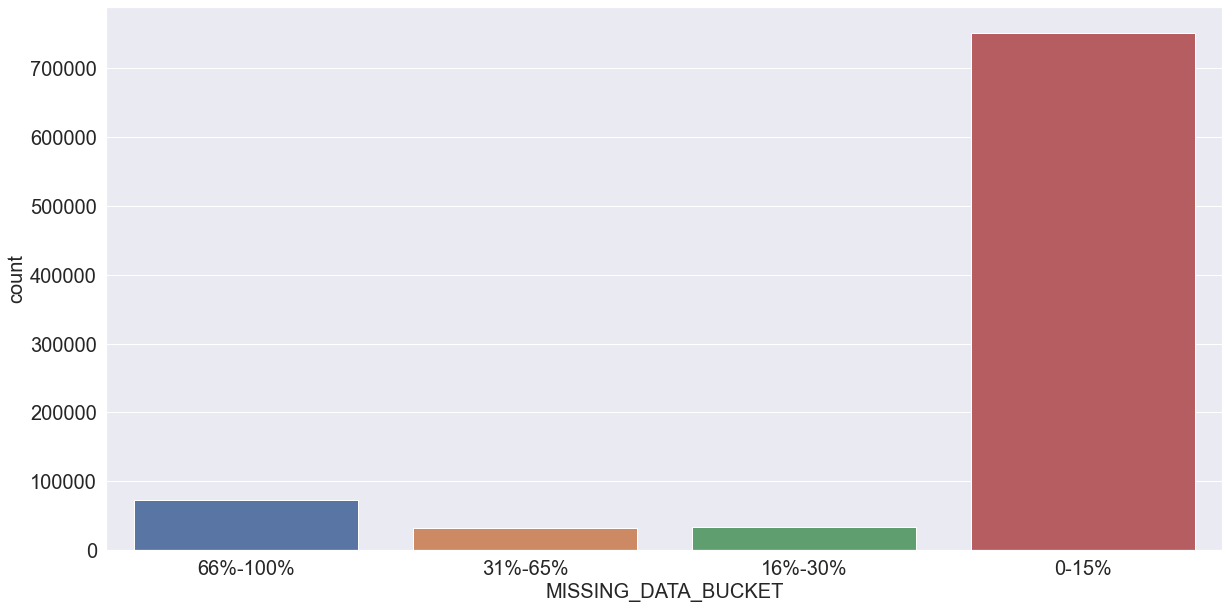

In [40]:
#  we  create a chart using countplot to see the various distributions of buckets, along with the count of rows:

sns.set(rc={'figure.figsize':(20,10)})

# the below 5 rows for setting up the font sizes I researched and got from
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

plt.rc('axes', titlesize=20)    
plt.rc('axes', labelsize=20)   
plt.rc('xtick', labelsize=20)  
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=20)

ct = sns.countplot(x='MISSING_DATA_BUCKET', data=row_nulls_df_sorted)
plt.show()

In [41]:
#  we check the distribution based on absolute value of missing values - and try to find the braking points for 15% missing bucket and 30% ones

#display(row_nulls_df_sorted)

display(row_nulls_df_sorted[row_nulls_df_sorted['MISSING_DATA_BUCKET'] == '16%-30%'].head(1))
display(row_nulls_df_sorted[row_nulls_df_sorted['MISSING_DATA_BUCKET'] == '0-15%'].head(1))

# we see that the missing rows are having a breaking point for >30% of data missing at >107 missing values
# as well, we see that the breacking point for the >15% missing data is >39 missing values

,NULLS_CNT,ROW_INDEX,PERCENT_MISSING_DATA,MISSING_DATA_BUCKET
105800,107,440518,29.722222,16%-30%


,NULLS_CNT,ROW_INDEX,PERCENT_MISSING_DATA,MISSING_DATA_BUCKET
139890,39,108600,10.833333,0-15%


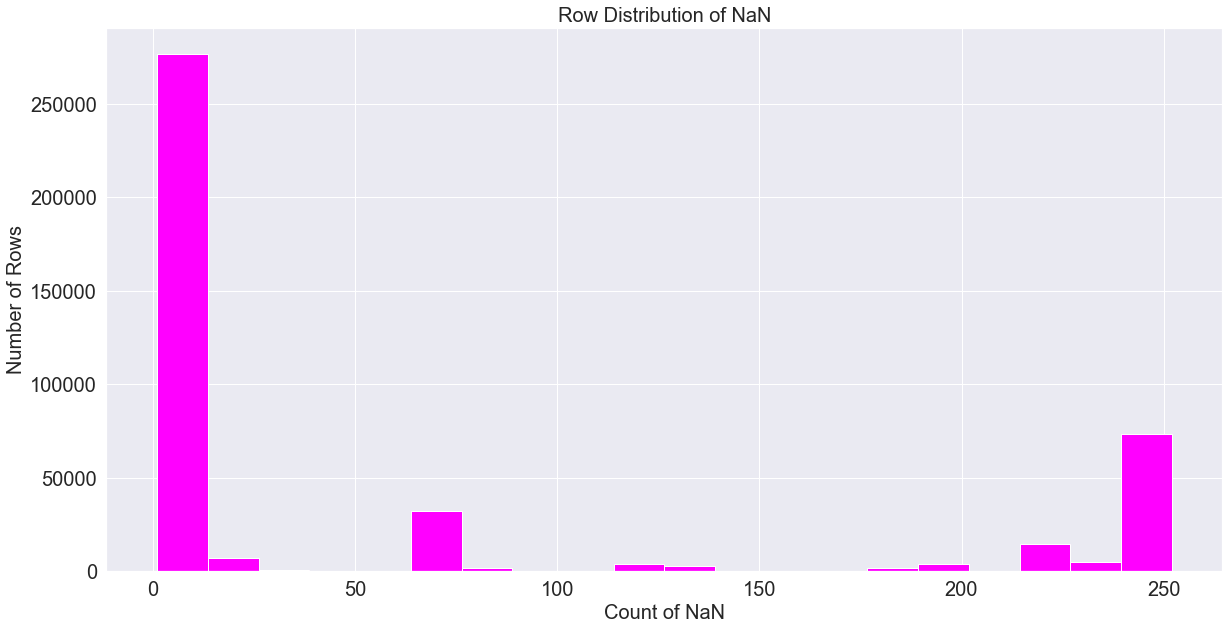

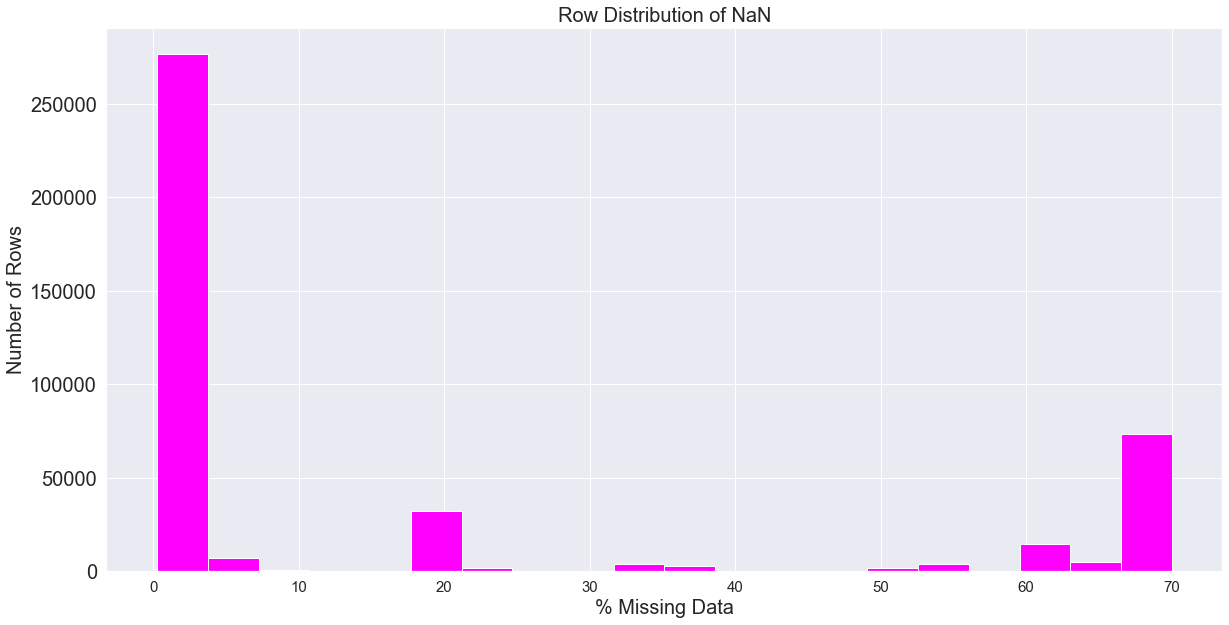

In [42]:
# we create 2 histograms plots, where we show te distribution of missing data in each row
# we compare between absolute value of missing values, and percent of missing

x=row_nulls_df[row_nulls_df['NULLS_CNT']>0]['NULLS_CNT'] # we filter out values that are 0, as the amount is high
y=row_nulls_df[row_nulls_df['PERCENT_MISSING_DATA']>0]['PERCENT_MISSING_DATA'] # # we filter out values that are 0, as the amount is high

plt.hist(x, bins = 20, color = 'magenta')
# the below 5 rows for setting up the font sizes I researched and got from
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

plt.rc('axes', titlesize=20)    
plt.rc('axes', labelsize=20)   
plt.rc('xtick', labelsize=15)  
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=20)

plt.xlabel('Count of NaN')
plt.ylabel('Number of Rows')
plt.title('Row Distribution of NaN')
plt.show()

plt.hist(y, bins = 20, color = 'magenta')

plt.xlabel('% Missing Data')
plt.ylabel('Number of Rows')
plt.title('Row Distribution of NaN')
plt.show()

# e can already observe below the outlier rows that have more than 60% of missing data.

In [43]:
# I will divide the data into two subsets based on the number of missing values in each row.
# I am deciding to split the data at the mark of 30% missing data per row
# This means that all rows with >30% missing values will be split in morenan
# This means that all rows with <=30% missing values will be split in lessnan

azdias_pure_morenan, azdias_pure_lessnan = [x for _, x in azdias_pure.groupby(((azdias_pure.isnull().sum(axis=1)/m)*100) <=30)]

azdias_pure_morenan=azdias_pure_morenan.reset_index(drop=True)
azdias_pure_lessnan=azdias_pure_lessnan.reset_index(drop=True)

# we check the shapes of our 2 data sets compared to the data set which came out of the columns cleaning: azdias_pure

display('Data set with more than 30% missing values on rows has the following shape: {}'.format(azdias_pure_morenan.shape[:]))
display('Data set with less than/or equal to 30% missing values on rows has the following shape: {}'.format(azdias_pure_lessnan.shape[:]))
display('Data set with cleaned columns has the following shape: {}'.format(azdias_pure.shape[:]))

'Data set with more than 30% missing values on rows has the following shape: (105800, 360)'

'Data set with less than/or equal to 30% missing values on rows has the following shape: (785421, 360)'

'Data set with cleaned columns has the following shape: (891221, 360)'

In [44]:
# Comparing the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

nulls_df_sorted_asc=nulls_df.sort_values(by=['PERCENT_MISSING_DATA'], ascending=True)
l=nulls_df_sorted_asc.head(94)['FEATURE_NAME'].tolist()
print(l)

#below we see a list of columns that have 0 NaN values 
#we choose a few of them to see what impact the elimination of the rows with >30% data missing would have on them

['LNR', 'D19_WEIN_FEINKOST', 'D19_VOLLSORTIMENT', 'D19_VERSICHERUNGEN', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_DATUM', 'D19_VERSI_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_VERSAND_REST', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_TIERARTIKEL', 'D19_TELKO_REST', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_DATUM', 'D19_TELKO_ANZ_24', 'D19_TELKO_ANZ_12', 'D19_TECHNIK', 'D19_SONSTIGE', 'D19_SCHUHE', 'D19_SAMMELARTIKEL', 'D19_REISEN', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'ZABEOTYP', 'VERS_TYP', 'SHOPPER_TYP', 'SEMIO_VERT', 'SEMIO_TRADV', 'SEMIO_SOZ', 'SEMIO_REL', 'SEMIO_RAT', 'SEMIO_PFLICHT', 'SEMIO_MAT', 'SEMIO_LUST', 'SEMIO_KULT', 'SEMIO_KRIT', 'D19_RATGEBER', 'SEMIO_KAEM', 'SEMIO_ERL', 'SEMIO_DOM', 'PRAEGENDE_JUGENDJAHRE', 'NATIONALITAET_KZ', 'KOMBIALTER', 'ANREDE_KZ', 'HH_EINKOMMEN_SCORE', 'HEALTH_TYP', 'GREEN

In [45]:
# I am choosing the below list of columns for comparison- they all have 0 NaN values

columns_names=['FINANZ_VORSORGER', 
               'FINANZ_MINIMALIST', 
               'FINANZ_SPARER', 
               'FINANZ_ANLEGER', 
               'FINANZ_UNAUFFAELLIGER', 
               'FINANZ_HAUSBAUER',
               'FINANZTYP',
               'SEMIO_SOZ']


C:\Users\lupascu\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lupascu\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lupascu\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lupascu\Anaconda3\l

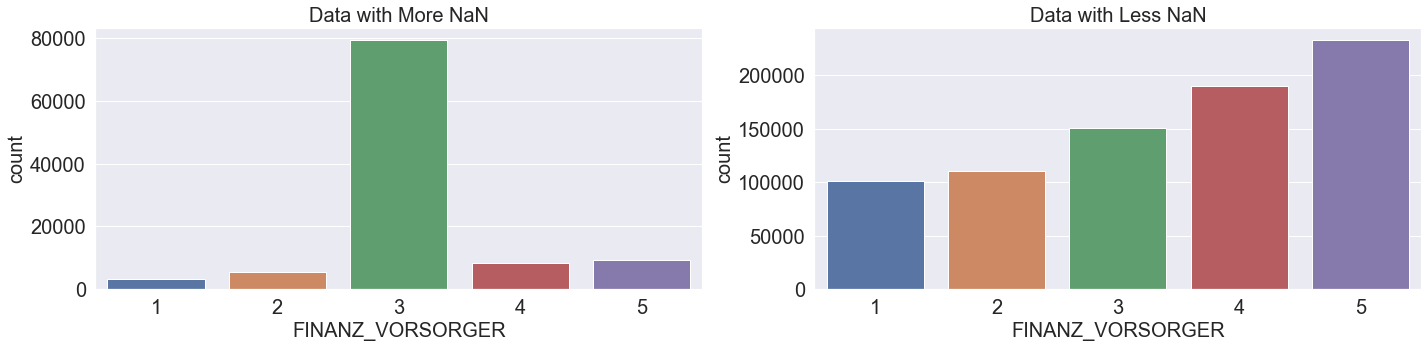

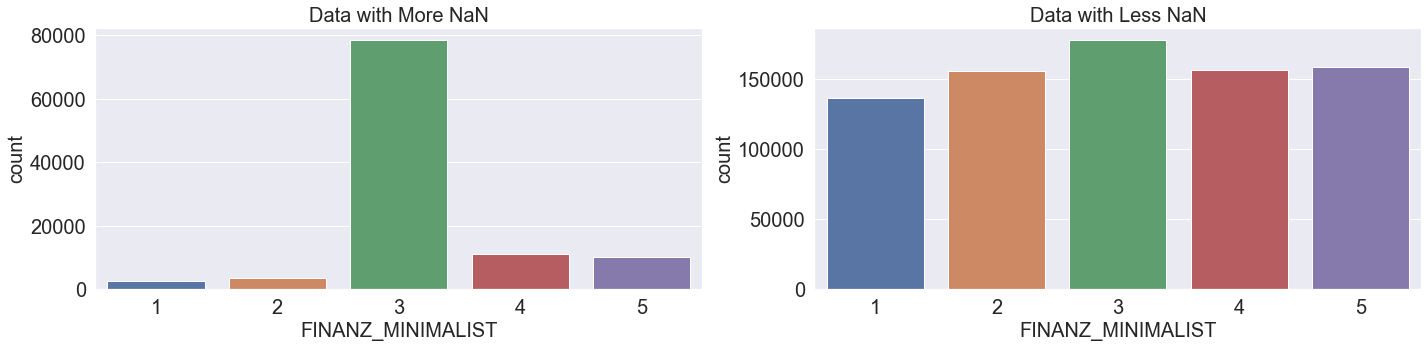

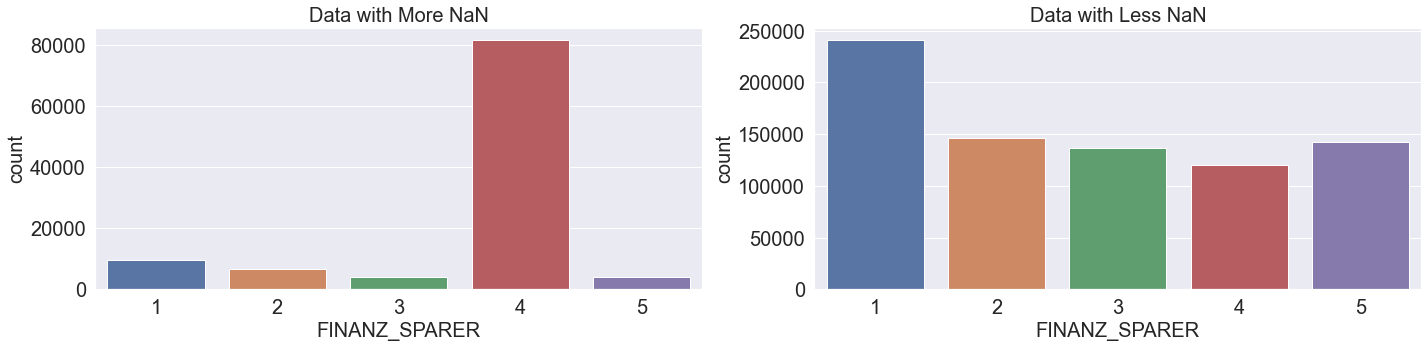

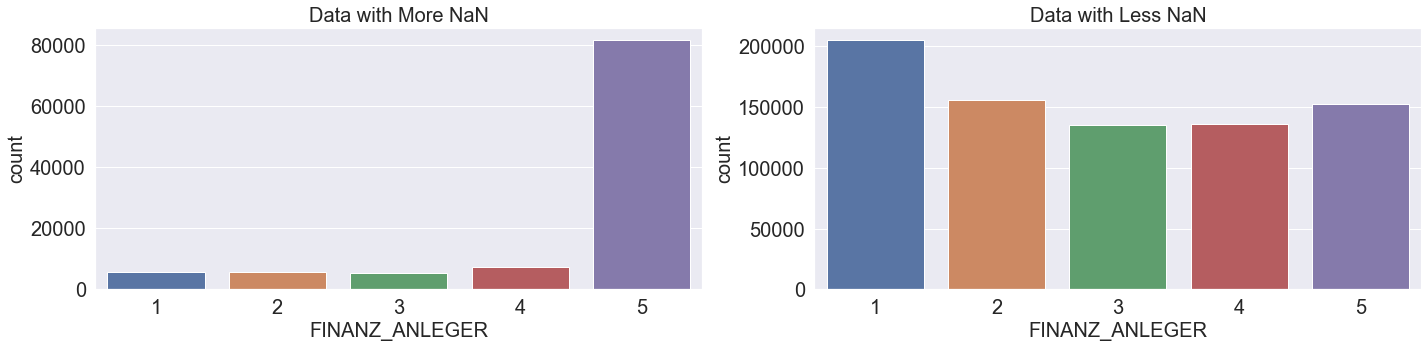

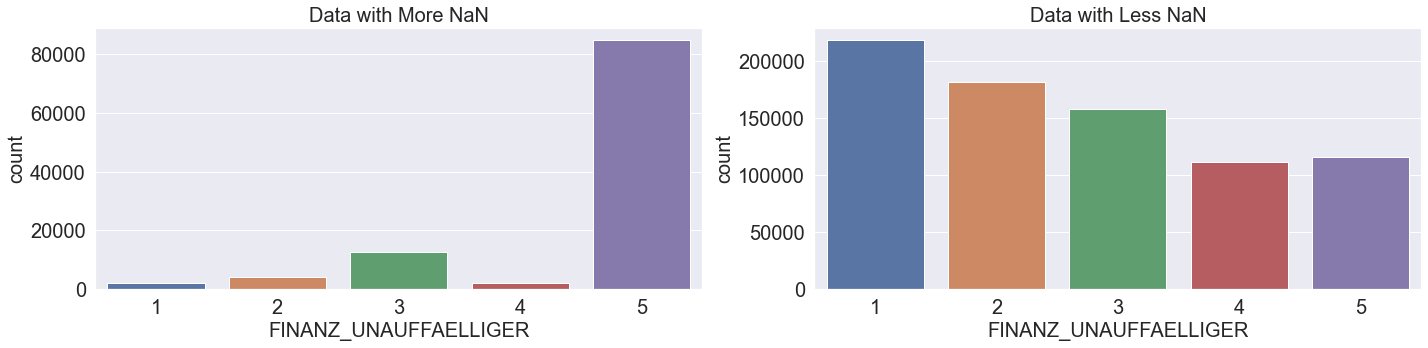

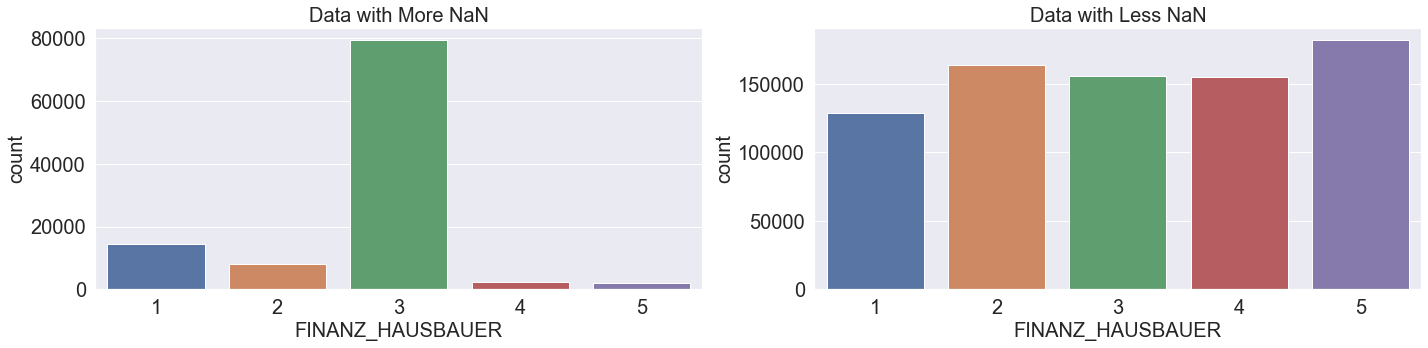

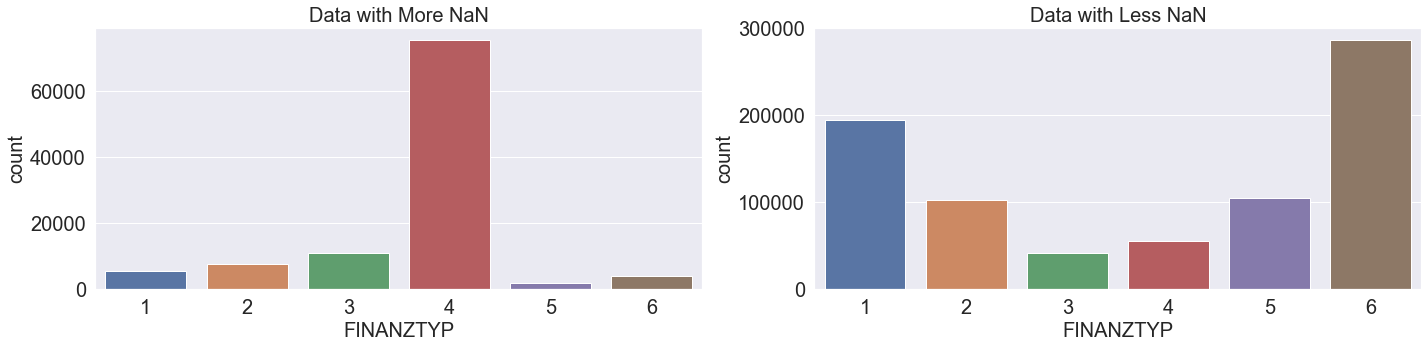

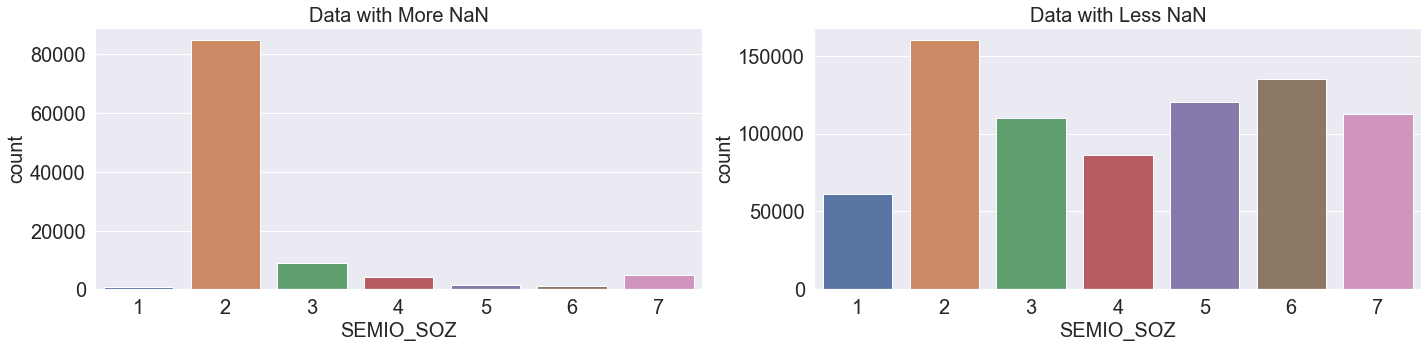

In [46]:
# we create a function to be able to plot the comparison between the features (NaN values kept, vs NaN values dropped)

def comparison(col_name):
        
        sns.set(rc={'figure.figsize':(20,5)}) # setting up a wide figure with a somewhat flat height 

# the below 5 rows for setting up the font sizes I researched and got from
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

        plt.rc('axes', titlesize=20)    
        plt.rc('axes', labelsize=20)   
        plt.rc('xtick', labelsize=20)  
        plt.rc('ytick', labelsize=20)
        plt.rc('figure', titlesize=20)
        
        fig, ax =plt.subplots(1,2)
        sns.countplot(azdias_pure_morenan[col_name], ax=ax[0]).set(title='Data with More NaN')
        sns.countplot(azdias_pure_lessnan[col_name], ax=ax[1]).set(title='Data with Less NaN')
     
        return fig.tight_layout();  
        
for c in range(len(columns_names)):
    comparison(columns_names[c])              

***Observations:

We observe the fact that we have some outlier rows where a lot of data is missing. All in all, after the initial analysis, we can conclude that around 12% of the rows of the general population data set have more than 30% of data missing.

As well, the the distribution of values for at least five columns where there are none or few missing values, between the two subsets shows us the differences between the 2 sets of data- and the impact of eliminating these rows will have on the final set of data.

For the FINANZ columns I have chosen, I see a lot of differences between the data set with less NaN values vs the one with more NaN values. It seems that data with more NaN values (with more missing info) has certain values populated per column, compared to the others from the range of values in the column. 

As we are able to see above, only 1 value actually stands out in terms of Count of rows for the columns in my example. I believe this means that for the rows with lots of missing data- we have columns where only 1 value is populated more than others- meaning one type /classification of persons will be impacted  a lot more when eliminating the rows with lots of missing values. 

For example- I have FINANZ_VORSORGER which I am eliminating over 80.000 rows of category 3 (Financial typology, for each dimension:3- Average) , which will leave this category at a lower number, in the data set with less missing info, thus bumping this category at position 3 (versus position 1, as depicted in data with more NaN values).

All in all, we see that, by reducing the data within dropping the rows that have more than 30% values missing, we will be impacting certain categories of people, as their representation will be reduced in the general population data. 

However, by reducing this number of rows (and dropping the ones that have more than 30% information missing), we actually equalize the data set a bit, and we level out the categories of people within it.

Rather than keeping the missing data rows, I would go for eliminating the ones that have more than 30% of data missing, as overall, this will lead to more balanced data, and keeping rows with such high amount of missing data could impact in a negative way more thah the gains we would have by keeping the rows for the categories of people that are impacted by this. 
***

### Step 3.2: Select and Re-Encode Features (categorical and mixed)

############################### GENERAL POPULATION DATA #############################



In this part of the project, we proceed to re-encoding some features that have different data types within themselves.
From the overall assessment in Step 0 of the project, we were able to notice that some of our columns have mixed data types inside.

As well, some of the columns we have in the data set are categorical- which means that we need to one-hot encode them and create some dummy features that would contain these categories separately on columns.

Since we already dropped a multitude of rows and columns in the data set, as part of the data clean-up process, we must re-investigate what type of columns are left in our general population data, and store this information separately.

Below, we will go through 2 major steps:

       - 3.2.1 Re-Encode Categorical Features (for general population data)
       - 3.2.2 Engineer Mixed-Type Features (for general population data)
       
Within this part I will also try to reduce the number of features as much as possible- as we will end up with more than 400 features, and the computing power for PCA is very heavy for the machine.

In fact, due to constant memory errors, I will implement a correlation matrix process- in which Pearson's correlation will be used to identify highly correlated features, after the treatment of my categorical and mixed featured.

I will establish a threshold of correlation (for ex: whatever is correlated more than 80%, it should be dropped) and then I will drop the features that are over this threshold.

For this, I will use [.corr()] method. 

More information about this can be found on Sklearn's library about the correlation matrix.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html



#### 3.2.1 Re-Encode Categorical Features (for general population data)

############################### GENERAL POPULATION DATA #############################



Categorical features need to be engineered in such a way that we would see the values inside on columns, and in a binary way (0 or 1).

For this, we will have to identify them again, and see exactly what types of values they have inside.

In the next steps, I will try to identify the categorical columns, and see if I could re-engineer them in a way that they would not affect the model or the learning process other than in a positive way.

Since I have decided to keep my data set clean of rows that have more than 30% missing values- I will be operating next with the [azdias_pure_lessnan] data set mentioned above.

For the purpose of identifying the categorical columns, I have found a useful resource online: 
https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical

This method consists in separating the columns of a data frame between the numerical ones and the ones that are a different type, by using the [._get_numeric_data()] method.

As well, I have used (as before) the [.select_dtypes(include=['object'])] method, as a second way of identifying these.

Both methods produce the same results in our general population data.

More so, after identifying the categorical values, I will proceed to determining which ones are binary, and which ones are multilevel, in order to assess which ones I keep and re-engineer.


In [47]:
# How many features are there of each data type? - using the .select_dtypes(include=['object']) method

categorical_feat= np.unique(np.array(azdias_pure_lessnan.select_dtypes(include=['object']).columns.tolist())).tolist()
print('All columns that are of object type in the general population data are:')
print(categorical_feat)

# How many features are there of each data type? - using the ._get_numeric_data() method

cols = azdias_pure_lessnan.columns
num_cols = azdias_pure_lessnan._get_numeric_data().columns
categorical_feat2=list(set(cols) - set(num_cols))
print()
print('All columns that are of categorical type in the general population data are:')
print(categorical_feat2)

All columns that are of object type in the general population data are:
['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']

All columns that are of categorical type in the general population data are:
['CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEUG_2015']


In [48]:
# Now that we have our list of categorical features- we do a bit of investigation to show the unique values in each:

#'CAMEO_DEUG_2015' :CAMEO classification 2015 - Uppergroup
#'CAMEO_DEU_2015' :CAMEO classification 2015 - detailled classification
#'CAMEO_INTL_2015' :description missing from the features files, but possibly is CAMEO_DEUINTL_2015: CAMEO_4.0: international classification
#'D19_LETZTER_KAUF_BRANCHE' :description missing (eng translation: LAST PURCHASE INDUSTRY)
#'EINGEFUEGT_AM': description missing (eng translation: INSERTED ON)
#'OST_WEST_KZ': flag indicating the former GDR/FRG

for col in range(len(categorical_feat)):
    if categorical_feat[col]=='EINGEFUEGT_AM': # we have too many unique values in this column- lots of time-stamps.
        print(categorical_feat[col])
        print(azdias_pure_lessnan[categorical_feat[col]].unique().tolist()[:20])
        print()
    else: 
        print(categorical_feat[col])
        print(azdias_pure_lessnan[categorical_feat[col]].unique().tolist())
        print()

CAMEO_DEUG_2015
[8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, nan, '4', '3', '7', '2', '8', '9', '6', '5', '1', 'X']

CAMEO_DEU_2015
['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C', '7A', '5D', '9E', '9B', '1B', '8B', '3D', nan, '4E', '4B', '3C', '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D', '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C', 'XX']

CAMEO_INTL_2015
[51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0, 34.0, 55.0, 25.0, nan, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0, '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14', '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX']

D19_LETZTER_KAUF_BRANCHE
[nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK', 'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS', 'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD', 'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST', 'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_

In [49]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one need to be re-encoded?

# finding out the categorical ones in my azdias_pure_lessnan data which are binary and multilevel
binary=[]
multi=[]
for c in range(len(categorical_feat)):
    if categorical_feat[c] in azdias_pure_lessnan.columns and azdias_pure_lessnan[categorical_feat[c]].nunique()==2:
        binary.append(categorical_feat[c])
        print('{} {} {} {}'. format(categorical_feat[c], azdias_pure_lessnan[categorical_feat[c]].dtype, 'categorical', 'binary'))
    elif categorical_feat[c] in azdias_pure_lessnan.columns and azdias_pure_lessnan[categorical_feat[c]].nunique()>2:
        multi.append(categorical_feat[c])
        print('{} {} {} {}'. format(categorical_feat[c], azdias_pure_lessnan[categorical_feat[c]].dtype, 'categorical', 'multi-level'))


CAMEO_DEUG_2015 object categorical multi-level
CAMEO_DEU_2015 object categorical multi-level
CAMEO_INTL_2015 object categorical multi-level
D19_LETZTER_KAUF_BRANCHE object categorical multi-level
EINGEFUEGT_AM object categorical multi-level
OST_WEST_KZ object categorical binary


In [50]:
# from the above assessment, we see we have 1 categorical binary feature, which is OST_WEST_KZ 
# for this feature, I will Re-encode it  and keep it in the analysis

# replacing binary values with 0 and 1
# replacing NaN values with -1- equivalent of unknown- we don't have these values here anymore, but we might encounter them in customers data set

for col in range(len(binary)):
    binary_vals=azdias_pure_lessnan[binary[col]].unique().tolist()
    azdias_pure_lessnan[binary[col]].replace({binary_vals[0]: 0, binary_vals[1]: 1}, inplace=True)                

# we recheck the unique values of the binary columns

for col in range(len(binary)):
    print(binary[col])
    print(azdias_pure_lessnan[binary[col]].unique().tolist())

OST_WEST_KZ
[0, 1]


In [51]:
# by the investigation above multi-level categorical features, we already see that we have values of NaN, and also some outlier values:
# CAMEO_DEUG_2015 has a value 'X'
# CAMEO_DEU_2015 and  CAMEO_INTL_2015 have a value 'XX'

# values that seem to need replacement are: [NaN, 'X', 'XX']
# we will replace all of these values, along with the NaN ones to the corresponding value for "Unknown": meaning -1


# we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.

for col in range(len(multi)):
    azdias_pure_lessnan[multi[col]].replace({'X': -1, 'XX': -1}, inplace=True)
    azdias_pure_lessnan[multi[col]].fillna(-1, inplace = True)


# there are still 2 columns that containg mixed values that are float and integer: CAMEO_DEUG_2015 and CAMEO_INTL_2015
# for the sake of not getting errors, we need to transform these also into integer values

azdias_pure_lessnan['CAMEO_DEUG_2015'] = azdias_pure_lessnan['CAMEO_DEUG_2015'].astype(int)
azdias_pure_lessnan['CAMEO_INTL_2015'] = azdias_pure_lessnan['CAMEO_INTL_2015'].astype(int)


# we recheck the unique values for the re-encoded categorical multi-level features:
for col in range(len(multi)):
    if multi[col]=='EINGEFUEGT_AM':
        print(multi[col])
        print(azdias_pure_lessnan[multi[col]].unique().tolist()[:20])
    else:
        print(multi[col])
        print(azdias_pure_lessnan[multi[col]].unique().tolist())

CAMEO_DEUG_2015
[8, 4, 2, 6, 1, 9, 5, 7, 3, -1]
CAMEO_DEU_2015
['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C', '7A', '5D', '9E', '9B', '1B', '8B', '3D', -1, '4E', '4B', '3C', '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D', '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C']
CAMEO_INTL_2015
[51, 24, 12, 43, 54, 22, 14, 13, 15, 33, 41, 34, 55, 25, -1, 23, 31, 52, 35, 45, 44, 32]
D19_LETZTER_KAUF_BRANCHE
[-1, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK', 'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS', 'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD', 'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST', 'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT', 'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE', 'D19_REISEN', 'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG', 'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL', 

In [52]:
# we decide which of the categorical features we wish to keep.
# First, we need to get rid of the columns that have the least useful information to provide: EINGEFUEGT_AM  and D19_LETZTER_KAUF_BRANCHE
# this column contains time-stamp information, so we won't need it for our model training.

to_drop=['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
azdias_pure_lessnan.drop(labels=to_drop, axis=1, inplace=True)

# We recheck how many of our columns are still categorical - based on the data clean-up we did
# We still have one more column CAMEO_DEU_2015 for which we will create dummies later on

print(pd.DataFrame(azdias_pure_lessnan.dtypes, columns=['DATA_TYPE']).DATA_TYPE.value_counts())
print(np.unique(np.array(azdias_pure_lessnan.select_dtypes(include=['object']).columns.tolist())).tolist())


float64    261
int64       94
int32        2
object       1
Name: DATA_TYPE, dtype: int64
['CAMEO_DEU_2015']


***Observations:

While the categorical features type 'object' are not so many in the data set, we had a number of 6 in the general population data - which we had to clean.

The columns in question were:

- 'CAMEO_DEUG_2015' : CAMEO classification 2015 - Uppergroup
- 'CAMEO_DEU_2015' : CAMEO classification 2015 - detailled classification
- 'CAMEO_INTL_2015' : description missing from the features files, but possibly is CAMEO_DEUINTL_2015
- 'D19_LETZTER_KAUF_BRANCHE': description missing (eng translation: LAST PURCHASE INDUSTRY)
- 'EINGEFUEGT_AM': description missing (eng translation: INSERTED ON)
- 'OST_WEST_KZ': flag indicating the former GDR/FRG

Upon applying a cleaning process to them I have:

- removed the NaN values, by replacing them with -1 (value for Unknowun)
- replaced the outlier values of 'X' and 'XX'  with -1 (value for Unknowun)
- located the binary and multi-level categorical columns, and replaced the binary categorical values with 0 and 1;

***

### 3.2.2 Engineer Mixed-Type Features (for general population data)

In this step, we treat some extra features by creating more groups for them, as they contain information 

The 2 columns in question are: 

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I created two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. I broke up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values)

Disclaimer: the steps are taken form an older project done in the Foundations module (by myself).

In the next steps, we will try to reduce dimensionality even more, through the help of the correlation matrix.


In [53]:
# explanation in dictionary for PRAEGENDE_JUGENDJAHRE

'''Dominating movement in the person's youth (avantgarde or mainstream)

-1, 0: unknown
1: 40ies - war years (Mainstream, O+W)
2: 40ies - reconstruction years (Avantgarde, O+W)
3: 50ies - economic miracle (Mainstream, O+W)
4: 50ies - milk bar / Individualisation (Avantgarde, O+W)
5: 60ies - economic miracle (Mainstream, O+W)
6: 60ies - generation 68 / student protestors (Avantgarde, W)
7: 60ies - opponents to the building of the Wall (Avantgarde, O)
8: 70ies - family orientation (Mainstream, O+W)
9: 70ies - peace movement (Avantgarde, O+W)
10: 80ies - Generation Golf (Mainstream, W)
11: 80ies - ecological awareness (Avantgarde, W)
12: 80ies - FDJ / communist party youth organisation (Mainstream, O)
13: 80ies - Swords into ploughshares (Avantgarde, O)
14: 90ies - digital media kids (Mainstream, O+W)
15: 90ies - ecological awareness (Avantgarde, O+W) '''

#we check the unique values
print(azdias_pure_lessnan['PRAEGENDE_JUGENDJAHRE'].unique().tolist())

# we check the number of rows
val_list=azdias_pure_lessnan['PRAEGENDE_JUGENDJAHRE'].values
print(len(val_list))

[14, 15, 8, 3, 10, 11, 9, 6, 4, 0, 5, 2, 1, 12, 13, 7]
785421


In [54]:
# we create 2 features that we can then re-encode from PRAEGENDE_JUGENDJAHRE: 

#one with the year/decade 
#one with the dominating movement

dec_list=[]


for d in range(len(val_list)):
    if val_list[d] in [1.,2.]:
        dec_list.append(40)
    elif val_list[d] in [3.,4.]:
        dec_list.append(50)
    elif val_list[d] in [5.,6.,7.]:
        dec_list.append(60)
    elif val_list[d] in [8.,9.]:
        dec_list.append(70)
    elif val_list[d] in [10., 11., 12., 13.]:
        dec_list.append(80)
    elif val_list[d] in [14., 15.]:
        dec_list.append(90)
    else:
        dec_list.append(-1)

print(len(dec_list))

azdias_pure_lessnan['PRAEGENDE_JUGENDJAHRE_dec']=dec_list
print(azdias_pure_lessnan.PRAEGENDE_JUGENDJAHRE_dec.value_counts())  

785421
 90    221804
 70    172321
 80    149370
 60    113155
 50     73475
 40     27760
-1      27536
Name: PRAEGENDE_JUGENDJAHRE_dec, dtype: int64


In [55]:
#feature with the dominating movement

move_list=[]
mainstream_l=[1,3,5,8,10,12,14]
avantgarde_l=[2,4,6,7,9,11,13,15]

for d in range(len(val_list)):
    if val_list[d] in mainstream_l:
        move_list.append(0)
    elif val_list[d] in avantgarde_l:
        move_list.append(1)
    else:
        move_list.append(-1)

print(len(move_list))

azdias_pure_lessnan['PRAEGENDE_JUGENDJAHRE_move']=move_list

# quick check to see if the mapping worked
print(azdias_pure_lessnan.PRAEGENDE_JUGENDJAHRE_move.value_counts())     

785421
 0    585176
 1    172709
-1     27536
Name: PRAEGENDE_JUGENDJAHRE_move, dtype: int64


In [56]:
# explanation in dictionary for "CAMEO_INTL_2015" 

'''CAMEO classification 2015 - international typology (each German CAMEO code belongs to one international code)
-1	unknown
11	Wealthy Households-Pre-Family Couples & Singles
12	Wealthy Households-Young Couples With Children
13	Wealthy Households-Families With School Age Children
14	Wealthy Households-Older Families &  Mature Couples
15	Wealthy Households-Elders In Retirement
21	Prosperous Households-Pre-Family Couples & Singles
22	Prosperous Households-Young Couples With Children
23	Prosperous Households-Families With School Age Children
24	Prosperous Households-Older Families & Mature Couples
25	Prosperous Households-Elders In Retirement
31	Comfortable Households-Pre-Family Couples & Singles
32	Comfortable Households-Young Couples With Children
33	Comfortable Households-Families With School Age Children
34	Comfortable Households-Older Families & Mature Couples
35	Comfortable Households-Elders In Retirement
41	Less Affluent Households-Pre-Family Couples & Singles
42	Less Affluent Households-Young Couples With Children
43	Less Affluent Households-Families With School Age Children
44	Less Affluent Households-Older Families & Mature Couples
45	Less Affluent Households-Elders In Retirement
51	Poorer Households-Pre-Family Couples & Singles
52	Poorer Households-Young Couples With Children
53	Poorer Households-Families With School Age Children
54	Poorer Households-Older Families & Mature Couples
55	Poorer Households-Elders In Retirement
'''

#we check the unique values
print(azdias_pure_lessnan['CAMEO_INTL_2015'].unique().tolist())

# we check the number of rows
val_list=azdias_pure_lessnan['CAMEO_INTL_2015'].values.tolist()
print(len(val_list))

[51, 24, 12, 43, 54, 22, 14, 13, 15, 33, 41, 34, 55, 25, -1, 23, 31, 52, 35, 45, 44, 32]
785421


In [57]:
# we can create 2 more features that we can then re-encode from CAMEO_INTL_2015: 


#one with the wealth
#one with the life_stage

#The below try except I researched from the https://www.w3schools.com/python/python_try_except.asp and had to use this, as the nan is considered float in some cells

wealth_list=[]
life_stage_list=[]

for d in range(len(val_list)):
    if val_list[d]==-1:
        wealth_list.append(-1)
        life_stage_list.append(-1)
    else:
        wealth_list.append(int(str(val_list[d])[:1])) # first digit
        life_stage_list.append(int(str(val_list[d])[-1])) # last digit

azdias_pure_lessnan['CAMEO_INTL_2015_wealth']=wealth_list
azdias_pure_lessnan['CAMEO_INTL_2015_life_stage']=life_stage_list

# quick check to see if the mapping worked
print(azdias_pure_lessnan.CAMEO_INTL_2015_wealth.value_counts())
print(azdias_pure_lessnan.CAMEO_INTL_2015_life_stage.value_counts())     

 5    220488
 2    188056
 4    187602
 1    118197
 3     67080
-1      3998
Name: CAMEO_INTL_2015_wealth, dtype: int64
 1    241446
 4    230058
 3    117907
 5    115605
 2     76407
-1      3998
Name: CAMEO_INTL_2015_life_stage, dtype: int64


In [58]:
# we now need to drop the 2 columns, as we do not need them 

to_drop=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
azdias_pure_lessnan.drop(labels=to_drop, axis=1, inplace=True)

# we check the shape again
print(pd.DataFrame(azdias_pure_lessnan.dtypes, columns=['DATA_TYPE']).DATA_TYPE.value_counts())

float64    261
int64       97
object       1
int32        1
Name: DATA_TYPE, dtype: int64


In [59]:
# replace all NaN values in the data set for the columns where we have already the 'unknown' value filled in
# NaN values available for the features are containing values of 0 or -1 - we will replace all that already have this value on the columns

azdias_pure_lessnan[azdias_pure_lessnan.columns[(azdias_pure_lessnan==0).any()]] = azdias_pure_lessnan[azdias_pure_lessnan.columns[(azdias_pure_lessnan==0).any()]].fillna(0)
azdias_pure_lessnan[azdias_pure_lessnan.columns[(azdias_pure_lessnan==-1).any()]] = azdias_pure_lessnan[azdias_pure_lessnan.columns[(azdias_pure_lessnan==-1).any()]].fillna(-1)


In [60]:
# one last check of: mixed columns, categorical ones

azdias_cols=azdias_pure_lessnan.columns.tolist()
azdias_mixed_cols=[]
azdias_col_types=[]

for column in azdias_pure_lessnan.columns:
    azdias_col_types.append(pd.api.types.infer_dtype(azdias_pure_lessnan[column]))
    
for types in range(len(azdias_col_types)):
    if azdias_col_types[types] == 'mixed':
        azdias_mixed_cols.append(azdias_cols[types])

print('All columns that have mixed values for the general population data are:')
print(azdias_mixed_cols)


ategorical_feat= np.unique(np.array(azdias_pure_lessnan.select_dtypes(include=['object']).columns.tolist())).tolist()
print()
print('All columns that are of object type for the general population data are:')
print(ategorical_feat)

# we can see that we have no more columns with 'Mixed' data types, and the only categorical column left is the CAMEO_DEU_2015 one

All columns that have mixed values for the general population data are:
[]

All columns that are of object type for the general population data are:
['CAMEO_DEU_2015']


In [61]:
# I will try to minimuze the number of columns even more- due to memory allocation issues
# Since we have over 400 columns after we perform .get_dummies, it is very heavy on the RAM, and the computing power of my machine cannot handle this for the PCA
#I got the below code from the https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python location

from sklearn import datasets

#Creating a square matrix with dimensions equal to the number of features. 
#In which we will have the elements as the absolute value of correlation between the features.

cor_matrix = azdias_pure_lessnan.corr().abs()
print(cor_matrix)

#we are selecting the upper threshold.
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

#we are selecting the columns which are having absolute correlation greater than our threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print(); print(to_drop)

#dropping the columns which are in the list 'to_drop' from the dataframe
azdias_pure_lessnan = azdias_pure_lessnan.drop(to_drop, axis=1)

# we check our shape again
print(azdias_pure_lessnan.shape)

                                 LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  \
LNR                         1.000000  0.019843    0.004957  0.011814   
AGER_TYP                    0.019843  1.000000    0.281827  0.000321   
AKT_DAT_KL                  0.004957  0.281827    1.000000  0.175674   
ALTER_HH                    0.011814  0.000321    0.175674  1.000000   
ALTERSKATEGORIE_FEIN        0.003265  0.017063    0.190186  0.681193   
...                              ...       ...         ...       ...   
ALTERSKATEGORIE_GROB        0.000142  0.341353    0.198194  0.158845   
PRAEGENDE_JUGENDJAHRE_dec   0.001342  0.394151    0.086247  0.362877   
PRAEGENDE_JUGENDJAHRE_move  0.068895  0.095981    0.174573  0.152952   
CAMEO_INTL_2015_wealth      0.071186  0.043200    0.156327  0.090665   
CAMEO_INTL_2015_life_stage  0.020313  0.114374    0.127067  0.011120   

                            ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
LNR                                     0.003265             0

C:\Users\lupascu\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(785421, 294)


In [62]:
# create dummies for all the columns 

apl_hot_lessnan = pd.get_dummies(azdias_pure_lessnan)

In [63]:
# check the shape of it again
print(apl_hot_lessnan.shape)

# let's check NaN values again
print(apl_hot_lessnan.isna().sum().sum())

# let's see what columns we end up having in the end- we need to make sure we only have types of columns we can pass to our pca
pd.DataFrame(apl_hot_lessnan.dtypes, columns=['DATA_TYPE']).DATA_TYPE.value_counts()

(785421, 338)
1238946


float64    215
int64       77
uint8       45
int32        1
Name: DATA_TYPE, dtype: int64

***Observations:

As observed above, after we treat both the categorical feature, and engineered new ones for the Mixed-Type Features which combine information on multiple dimensions, we end up with an almost clean data set, which prepares the general population data for the process of creating dummy variables for it.

The .get_dummies() method was used for this purpose, and upon applying this to the data, we get a clean data set, from the point of view of types of columns that we wish to pass to our ML algorithms.

Therefore, we have no more 'object' type features, and all we are left with are 'float' and 'int' type columns- which are the ones we need for performing the next steps.

However, due to the high volume of features we got after the initial .get_dummies() method (more than 400 columns), I was found in the position of not being able to use my computer, as the computational power too high- and I consistently ran out of memory.

Therefore, I had to reduce the number of features even more- by using .corr() method.

In the end, we end up with a smaller number of columns (280)- which is acceptable for the computing power of the machine as well.

In the section below, I will create a cleaning function, that would apply the steps above to any data set we feed it.

The purpose is to clean any data sets in the upcoming parts of the project.***

### Step 3.3: Create a Cleaning Function


Even though I've finished cleaning up the general population demographics data, it's important to look ahead to the future and because we'll need to perform the same cleaning steps on the customer demographics data, we would require a function that would help us in doing so.

In this step, I will complete 2 cleaning functions to execute the main feature selection, encoding, and re-engineering steps I have performed above. 

The reason I chose to create 2 cleaning functions is due to the fact that the analysis regarding removing the rows that have missing information has shown that removing them would impact usualy 1 type of class for the features I chose.

While this might not impact in a very high way the clustering, it might impact the supervised ML algorithm, so I will want to apply different approaches in cleaning the data beofre training the model.

As well- the dimensionality reduction done through the correlation matrix could lead to eliminating an unequal number of columns between training and testing data- and this is not something I wish to have.

The first function <b>_clean_data()_</b> for cleaning up the data will handle several steps:

- cleaning columns (dropping columns with too much info missing);
- cleaning rows (dropping rows with too much info missing);
- treating categorical columns (binary and multi-level);
- treating mixed-values columns;
- replacing all NaN values with 0 or -1 for columns that already have some 'unknown' values registered;
- reduce dimensionality by eliminating highly correlated features; (this is for computational purposes)
- convert all categorical variables into dummy/indicator variables - by using the [.get_dummies()] method;

The second function <b>_clean_data_ml()_</b> for cleaning up the data will handle several steps:

- cleaning columns (dropping columns with too much info missing);
- treating categorical columns (binary and multi-level);
- treating mixed-values columns;
- replacing all NaN values with 0 or -1 for columns that already have some 'unknown' values registered;
- convert all categorical variables into dummy/indicator variables - by using the [.get_dummies()] method;

Then, when it comes to looking at the customer data, I will just run this function on that DataFrame to get the trimmed dataset in a single step.

In [20]:
def clean_data(df):
    """
    Perform feature trimming, row trimming, re-encoding, and engineering for demographics data
    
    INPUT: general population or customers DataFrame
    OUTPUT: Trimmed and cleaned general population or customers DataFrame
    
    """
    
    # cleaning columns
    null_list=df.isna().sum().tolist()
    cols_list=df.columns.values.tolist()
    d={'FEATURE_NAME': cols_list, 'NULLS_CNT': null_list}
    nulls_df=pd.DataFrame(d)
    
    n=df.shape[0]
    nulls_df['PERCENT_MISSING_DATA']= (nulls_df['NULLS_CNT']/n)*100
    nulls_df_sorted=nulls_df.sort_values(by=['PERCENT_MISSING_DATA'], ascending=False)
    percent_list=nulls_df_sorted['PERCENT_MISSING_DATA'].values.tolist()
    
    problematic_values= [x for x in percent_list if x >33]
    problematic_features=pd.DataFrame(nulls_df_sorted.loc[nulls_df_sorted['PERCENT_MISSING_DATA'].isin(problematic_values)])
    problematic_features_l=problematic_features['FEATURE_NAME'].values.tolist()
    
    df = pd.DataFrame(df.drop(problematic_features_l, axis=1)) #azisdas_pure
     
    #cleaning rows
    row_nulls_df=pd.DataFrame(df.isnull().sum(axis=1), columns=['NULLS_CNT']) #azisdas_pure
    
    m=df.shape[1] #azisdas_pure
    row_nulls_df['PERCENT_MISSING_DATA']= (row_nulls_df['NULLS_CNT']/m)*100
    df_pure_morenan, df_pure_lessnan = [x for _, x in df.groupby(((df.isnull().sum(axis=1)/m)*100)<=30)] #azisdas_pure
    df_pure_lessnan=df_pure_lessnan.reset_index(drop=True)
    df=pd.DataFrame(df_pure_lessnan)

    # select, re-encode, and engineer column values.
    
    # Treating categorical features
    
    categorical_feat= np.unique(np.array(df.select_dtypes(include=['object']).columns.tolist())).tolist()# getting categ list
    
    binary=[]
    multi=[]
    for c in range(len(categorical_feat)):
        if categorical_feat[c] in df.columns and df[categorical_feat[c]].nunique()==2:
            binary.append(categorical_feat[c])
        elif categorical_feat[c] in df.columns and df[categorical_feat[c]].nunique()>2:
            multi.append(categorical_feat[c])

            
    # treating binary categorical values
    for col in range(len(binary)):
        binary_vals=df[binary[col]].unique().tolist()
        df[binary[col]].replace({binary_vals[0]: 0, binary_vals[1]: 1}, inplace=True)                
        
    # treating multi-level categorical values    
    for col in range(len(multi)):
        df[multi[col]].replace({'X': -1, 'XX': -1}, inplace=True)
        df[multi[col]].fillna(-1, inplace = True)
        
    # treating the float and integer combined columns    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(int)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(int)
        
    # droppig columns we don't need/have too much info    
    to_drop=['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
    df = pd.DataFrame(df.drop(to_drop, axis=1)) 
    #df.drop(labels=to_drop, axis=1, inplace=True)    
        
    
    # treating mixed features
   
    val_list=df['PRAEGENDE_JUGENDJAHRE'].values #azdias_pure_lessnan
    dec_list=[]
    for d in range(len(val_list)):
        if val_list[d] in [1.,2.]:
            dec_list.append(40)
        elif val_list[d] in [3.,4.]:
            dec_list.append(50)
        elif val_list[d] in [5.,6.,7.]:
            dec_list.append(60)
        elif val_list[d] in [8.,9.]:
            dec_list.append(70)
        elif val_list[d] in [10., 11., 12., 13.]:
            dec_list.append(80)
        elif val_list[d] in [14., 15.]:
            dec_list.append(90)
        else:
            dec_list.append(-1)
        
    df['PRAEGENDE_JUGENDJAHRE_dec']=dec_list #azdias_pure_lessnan
    
    move_list=[]
    mainstream_l=[1,3,5,8,10,12,14]
    avantgarde_l=[2,4,6,7,9,11,13,15]

    for d in range(len(val_list)):
        if val_list[d] in mainstream_l:
            move_list.append(0)
        elif val_list[d] in avantgarde_l:
            move_list.append(1)
        else:
            move_list.append(-1)
    df['PRAEGENDE_JUGENDJAHRE_move']=move_list #azdias_pure_lessnan
    

    val_list=df['CAMEO_INTL_2015'].values.tolist()
    
    wealth_list=[]
    life_stage_list=[]

    for d in range(len(val_list)):
        if val_list[d]==-1:
            wealth_list.append(-1)
            life_stage_list.append(-1)
        else:
            wealth_list.append(int(str(val_list[d])[:1])) # first digit
            life_stage_list.append(int(str(val_list[d])[-1])) # last digit

    df['CAMEO_INTL_2015_wealth']=wealth_list
    df['CAMEO_INTL_2015_life_stage']=life_stage_list

    drop_list=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
    df = pd.DataFrame(df.drop(drop_list, axis=1)) 
    #df.drop(labels=to_drop, axis=1, inplace=True)
    
    # replace all NaN values in the data set
    # NaN values available for the features are containing values of 0 and -1

    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)
    
    
    #we find and drop the columns that are highly correlated
    
    cor_matrix = df.corr().abs()
    #we are selecting the upper threshold.
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    #we are selecting the columns which are having absolute correlation greater than our threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
    #dropping the columns which are in the list 'to_drop' from the dataframe
    df = df.drop(to_drop, axis=1)

    #create dummies for all the columns
    
    df = pd.get_dummies(df)
    
    # Return the cleaned dataframe.
    return df;
    
    

In [108]:
# I will also create a second cleaning function, one that will not contain the portion about removing the rows

def clean_data_ml(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: general population or customers DataFrame
    OUTPUT: Trimmed and cleaned general population or customers DataFrame
    
    """
    
    # cleaning columns
    null_list=df.isna().sum().tolist()
    cols_list=df.columns.values.tolist()
    d={'FEATURE_NAME': cols_list, 'NULLS_CNT': null_list}
    nulls_df=pd.DataFrame(d)
    
    n=df.shape[0]
    nulls_df['PERCENT_MISSING_DATA']= (nulls_df['NULLS_CNT']/n)*100
    nulls_df_sorted=nulls_df.sort_values(by=['PERCENT_MISSING_DATA'], ascending=False)
    percent_list=nulls_df_sorted['PERCENT_MISSING_DATA'].values.tolist()
    
    problematic_values= [x for x in percent_list if x >33]
    problematic_features=pd.DataFrame(nulls_df_sorted.loc[nulls_df_sorted['PERCENT_MISSING_DATA'].isin(problematic_values)])
    problematic_features_l=problematic_features['FEATURE_NAME'].values.tolist()
    
    df = pd.DataFrame(df.drop(problematic_features_l, axis=1)) #azisdas_pure
     
    #cleaning rows
    #row_nulls_df=pd.DataFrame(df.isnull().sum(axis=1), columns=['NULLS_CNT']) #azisdas_pure
    
    #m=df.shape[1] #azisdas_pure
    #row_nulls_df['PERCENT_MISSING_DATA']= (row_nulls_df['NULLS_CNT']/m)*100
    #df_pure_morenan, df_pure_lessnan = [x for _, x in df.groupby(((df.isnull().sum(axis=1)/m)*100)<=30)] #azisdas_pure
    #df_pure_lessnan=df_pure_lessnan.reset_index(drop=True)
    #df=pd.DataFrame(df_pure_lessnan)

    # select, re-encode, and engineer column values.
    
    # Treating categorical features
    
    categorical_feat= np.unique(np.array(df.select_dtypes(include=['object']).columns.tolist())).tolist()# getting categ list
    
    binary=[]
    multi=[]
    for c in range(len(categorical_feat)):
        if categorical_feat[c] in df.columns and df[categorical_feat[c]].nunique()==2:
            binary.append(categorical_feat[c])
        elif categorical_feat[c] in df.columns and df[categorical_feat[c]].nunique()>2:
            multi.append(categorical_feat[c])

            
    # treating binary categorical values
    for col in range(len(binary)):
        binary_vals=df[binary[col]].unique().tolist()
        df[binary[col]].replace({binary_vals[0]: 0, binary_vals[1]: 1}, inplace=True)                
        
    # treating multi-level categorical values    
    for col in range(len(multi)):
        df[multi[col]].replace({'X': -1, 'XX': -1}, inplace=True)
        df[multi[col]].fillna(-1, inplace = True)
        
    # treating the float and integer combined columns    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(int)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(int)
        
    # droppig columns we don't need/have too much info    
    to_drop=['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
    df = pd.DataFrame(df.drop(to_drop, axis=1)) 
    #df.drop(labels=to_drop, axis=1, inplace=True)    
        
    
    # treating mixed features
   
    val_list=df['PRAEGENDE_JUGENDJAHRE'].values #azdias_pure_lessnan
    dec_list=[]
    for d in range(len(val_list)):
        if val_list[d] in [1.,2.]:
            dec_list.append(40)
        elif val_list[d] in [3.,4.]:
            dec_list.append(50)
        elif val_list[d] in [5.,6.,7.]:
            dec_list.append(60)
        elif val_list[d] in [8.,9.]:
            dec_list.append(70)
        elif val_list[d] in [10., 11., 12., 13.]:
            dec_list.append(80)
        elif val_list[d] in [14., 15.]:
            dec_list.append(90)
        else:
            dec_list.append(-1)
        
    df['PRAEGENDE_JUGENDJAHRE_dec']=dec_list #azdias_pure_lessnan
    
    move_list=[]
    mainstream_l=[1,3,5,8,10,12,14]
    avantgarde_l=[2,4,6,7,9,11,13,15]

    for d in range(len(val_list)):
        if val_list[d] in mainstream_l:
            move_list.append(0)
        elif val_list[d] in avantgarde_l:
            move_list.append(1)
        else:
            move_list.append(-1)
    df['PRAEGENDE_JUGENDJAHRE_move']=move_list #azdias_pure_lessnan
    

    val_list=df['CAMEO_INTL_2015'].values.tolist()
    
    wealth_list=[]
    life_stage_list=[]

    for d in range(len(val_list)):
        if val_list[d]==-1:
            wealth_list.append(-1)
            life_stage_list.append(-1)
        else:
            wealth_list.append(int(str(val_list[d])[:1])) # first digit
            life_stage_list.append(int(str(val_list[d])[-1])) # last digit

    df['CAMEO_INTL_2015_wealth']=wealth_list
    df['CAMEO_INTL_2015_life_stage']=life_stage_list

    drop_list=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
    df = pd.DataFrame(df.drop(drop_list, axis=1)) 
    #df.drop(labels=to_drop, axis=1, inplace=True)
    
    # replace all NaN values in the data set
    # NaN values available for the features are containing values of 0 and -1

    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)
    
    
    #we find and drop the columns that are highly correlated
    
    #ccor_matrix = df.corr().abs()
    #we are selecting the upper threshold.
    #cupper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    #we are selecting the columns which are having absolute correlation greater than our threshold
    #cto_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
    #dropping the columns which are in the list 'to_drop' from the dataframe
    #cdf = df.drop(to_drop, axis=1)

    #create dummies for all the columns
    
    df = pd.get_dummies(df)
    
    # Return the cleaned dataframe.
    return df;
    
    

In [65]:
# check function functionality by applying the function to customers data set- get customers_hot_lessnan

customers_hot_lessnan=clean_data(customers)

C:\Users\lupascu\Anaconda3\lib\site-packages\ipykernel_launcher.py:138: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [66]:
# we check the shapes if our 2 data sets

print('Customers')
print('Shape: {}'.format(customers_hot_lessnan.shape))
print('NaN values: {}'.format(customers_hot_lessnan.isna().sum().sum()))
print()
print('General Population')
print('Shape: {}'.format(apl_hot_lessnan.shape))
print('NaN values: {}'.format(apl_hot_lessnan.isna().sum().sum()))

Customers
Shape: (140371, 356)
NaN values: 200619

General Population
Shape: (785421, 338)
NaN values: 1238946


In [67]:
# check to see what tyes of columns we end up with in the end for the customers data-we need to make sure we only have types of columns we can pass to our pca

print('Customers column types')
print(pd.DataFrame(customers_hot_lessnan.dtypes, columns=['DATA_TYPE']).DATA_TYPE.value_counts())

Customers column types
float64    225
int64       82
uint8       48
int32        1
Name: DATA_TYPE, dtype: int64


In [68]:
# check to see the differencesbetween the features in the general population data and customer data.
cust_cols=customers_hot_lessnan.columns.tolist()
azdias_cols=apl_hot_lessnan.columns.tolist()

diff=list(set(cust_cols) - set(azdias_cols))
print('The difference in columns between the General population data and the Customers data is below')
print(diff)

The difference in columns between the General population data and the Customers data is below
['PRODUCT_GROUP_COSMETIC', 'KBA05_SEG6', 'PRODUCT_GROUP_COSMETIC_AND_FOOD', 'MOBI_REGIO', 'GEMEINDETYP', 'CJT_TYP_2', 'FINANZ_SPARER', 'VK_DISTANZ', 'ONLINE_PURCHASE', 'D19_KONSUMTYP_MAX', 'CJT_TYP_5', 'PRODUCT_GROUP_FOOD', 'CUSTOMER_GROUP', 'KBA05_MOD8', 'KBA05_KW3', 'KBA05_KRSAQUOT', 'KBA13_MERCEDES', 'KBA05_SEG10', 'D19_GESAMT_ONLINE_DATUM', 'PRAEGENDE_JUGENDJAHRE_dec']


In [69]:
# check unique values in the categorical binary column named CUSTOMER_GROUP

np.unique(np.array(customers_hot_lessnan['CUSTOMER_GROUP'].values)).tolist()

[0, 1]

In [70]:
# check unique values in the ONLINE_PURCHASE feature

np.unique(np.array(customers_hot_lessnan['ONLINE_PURCHASE'].values)).tolist()

[0, 1]

***Observations:

After applying the cleaning function to the customers data set, we see that we get a shape of 356 columns, as opposed to 338 columns that are available in the General Population data.

This is due to the fact that: by running the data through the process of eliminating highly correlated columns, we get a different number of columns between the 2 data sets, as data might be present in various ways in the 2 data sets.

We already saw from the preliminary analysis that the data sets are not balanced- especially the customers one- which consisted on much more older generations, male predominancy, and a lot of high income representation.

Therefore, the correlation between columns will be different, as opposed to the general population data set.

The difference in columns are: 18 features:

['PRODUCT_GROUP_COSMETIC', 'KBA05_SEG6', 'PRODUCT_GROUP_COSMETIC_AND_FOOD', 'MOBI_REGIO', 'GEMEINDETYP', 'CJT_TYP_2', 'FINANZ_SPARER', 'VK_DISTANZ', 'ONLINE_PURCHASE', 'D19_KONSUMTYP_MAX', 'CJT_TYP_5', 'PRODUCT_GROUP_FOOD', 'CUSTOMER_GROUP', 'KBA05_MOD8', 'KBA05_KW3', 'KBA05_KRSAQUOT', 'KBA13_MERCEDES', 'KBA05_SEG10', 'D19_GESAMT_ONLINE_DATUM', 'PRAEGENDE_JUGENDJAHRE_dec']

As well, from beginning, customers data contained 3 more columns: 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'

As well, 2 of these columns are categorical: 'CUSTOMER_GROUP' and 'PRODUCT_GROUP'.

These 2 columns had initially the following values:

- CUSTOMER_GROUP ['MULTI_BUYER', 'SINGLE_BUYER']
- PRODUCT_GROUP ['COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC']

Upon applying the cleaning function, these 2 columns were treated in the same manner as the treatment for the general population was done- meaning:

- For the binary Categorical feature called CUSTOMER_GROUP- we only now see 2 values: [0, 1] for the 2 previous values
- For the multilevel categorical feature called PRODUCT_GROUP, we have processed (via .get_dummies() method) 3 more columns: 
      'PRODUCT_GROUP_COSMETIC_AND_FOOD', 'PRODUCT_GROUP_FOOD', 'PRODUCT_GROUP_COSMETIC'
- For the binary integer feature- ONLINE_PURCHASE we see the same values as before: [0, 1]

Now we are ready to proceed to the following steps:
- do the customer segmentation report, 
- and also run the supervised learning model.***


## Part 3B: Customer Segmentation Report: Implementation

The main bulk of your analysis will come in this part of the project. 

Here, I use the unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. 

At the end of this step,I willdescribe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

The customer segmentation report will comprise of several steps (below):

- 3.1 : Feature Transformation
     - 3.1.1: Apply Feature Scaling
     - 3.1.2: Perform Dimensionality Reduction
     - 3.1.3: Function for Principal Components check
- 3.2: Clustering
     - 3.2.1: Apply Clustering to General Population Data
     - 3.2.2: Apply Clustering to Customer Data
- 3.3: Compare Customer Data to General Population Data



### Step 3.1: Feature Transformation

In this section, we will continue with transforming the features that we currently have from the pre-processed data sets.

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

Sklearn requires that data not have missing values in order for its estimators to work properly. 
So, before applying the scaler to our data, we make sure that we've cleaned the DataFrame of the remaining missing values. 

This will be done byapplying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. The previous version for sklearn.preprocessing.Imputer was deprecated.

For the actual scaling function, a [StandardScaler](http://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance will be used, scaling each feature to mean 0 and standard deviation 1.

For these classes, I will make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. 

#### Step 3.1.1: Apply Feature Scaling

We proceed to first apply the scaler to our data, so that we make sure that we've cleaned the DataFrame of the remaining missing values. 

This will be done by applying [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. 

In [71]:
# I will choose the imputer - as I already tried to eliminate rows and columns with lots of data missing

from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values= np.nan, strategy='mean')
azdias_imp=imp.fit_transform(apl_hot_lessnan)

display(azdias_imp)

array([[ 9.10220e+05, -1.00000e+00,  9.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 9.10225e+05, -1.00000e+00,  9.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 9.10226e+05,  2.00000e+00,  1.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       ...,
       [ 8.25772e+05, -1.00000e+00,  1.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 8.25776e+05, -1.00000e+00,  9.00000e+00, ...,  0.00000e+00,
         1.00000e+00,  0.00000e+00],
       [ 8.25787e+05, -1.00000e+00,  1.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00]])

In [72]:
#  we check if the NaN values all disappeared- they have, as it is 0

np.count_nonzero(np.isnan(azdias_imp))

0

In [73]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_scaled=scaler.fit_transform(azdias_imp)

display(azdias_scaled)

array([[ 1.06102927, -0.56825745,  1.26289749, ..., -0.17972837,
        -0.19258968, -0.08734703],
       [ 1.0610487 , -0.56825745,  1.26289749, ..., -0.17972837,
        -0.19258968, -0.08734703],
       [ 1.06105259,  1.86521376, -0.93579051, ..., -0.17972837,
        -0.19258968, -0.08734703],
       ...,
       [ 0.73286156, -0.56825745, -0.93579051, ..., -0.17972837,
        -0.19258968, -0.08734703],
       [ 0.7328771 , -0.56825745,  1.26289749, ..., -0.17972837,
         5.19238633, -0.08734703],
       [ 0.73291985, -0.56825745, -0.93579051, ..., -0.17972837,
        -0.19258968, -0.08734703]])

#### Step 3.1.2: Perform Dimensionality Reduction

On your scaled data, we are now ready to apply dimensionality reduction techniques.

I will therefore use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. 

To start, I will not set any parameters (so all components are computed) 

In here, we will be able to: check out the ratio of variance explained by each principal component as well as the cumulative variance explained. 

I will also plot the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. 

Based on what we find here, I will select a value for the number of transformed features that I will retain for the clustering part of the project.

In [74]:
# We apply PCA to the data.

from sklearn.decomposition import PCA

pca = PCA()
X_pca=pca.fit_transform(azdias_scaled)
pca.explained_variance_ratio_.sum()


1.0

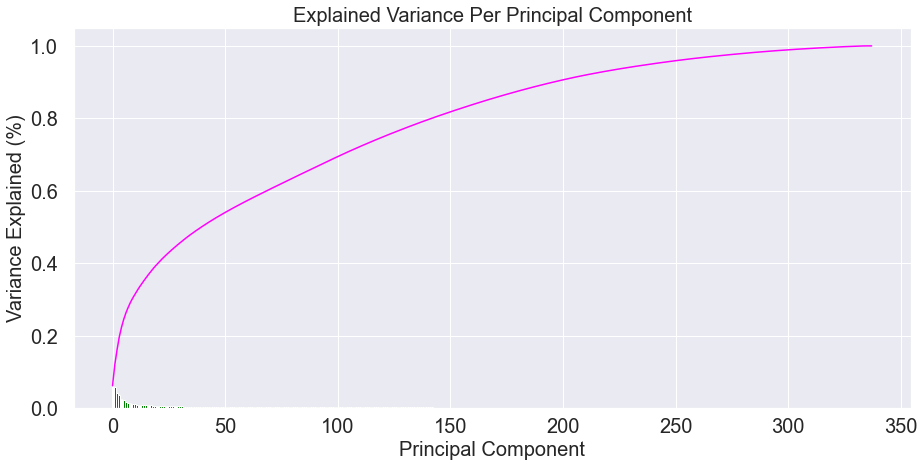

In [77]:
# we plot the cumulative values to see the variance per component 
# below code I took from Udacity course- it seemed the best option for showing the variance per component explanation- function was called scree_plot

num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(15, 7))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals, color ='green')
ax.plot(ind, cumvals, color ='magenta')

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')

plt.show()

# we see below how every component is participating in explaining all the data , adding up in the end to 1

In [78]:
# I will create a small code to see if I can loop through multiple number of components and find the perfect ratio for my n_components

# I will try to keep as little components, and get at least 85-87% of variance explained

comp_l=[50, 100, 150, 210, 260, 300, 338] # list for number of components
var_l=[]

for i in comp_l:
    pca=PCA(i)
    X_pca=pca.fit_transform(azdias_scaled)
    pca.explained_variance_ratio_.sum()
    var_l.append(pca.explained_variance_ratio_.sum())    
    

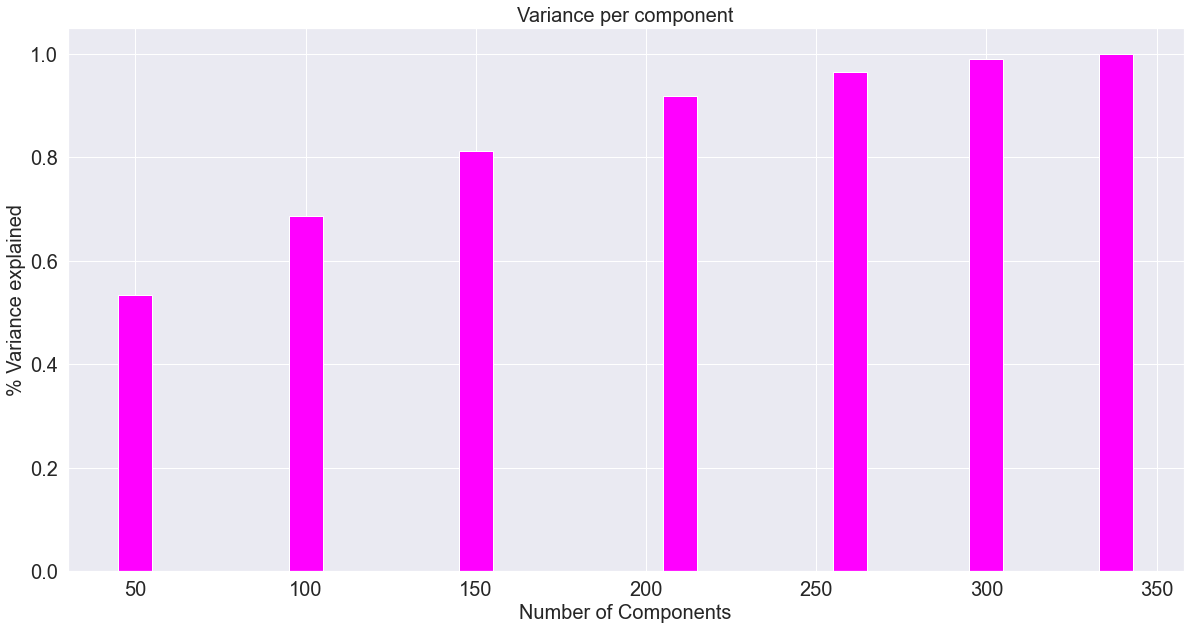

In [80]:
# I plot the various number of components and the amount of variance they explain

fig = plt.figure(figsize = (20, 10))
bars = plt.bar(comp_l, var_l, color ='magenta',width = 10)

plt.xlabel('Number of Components')
plt.ylabel('% Variance explained')
plt.title('Variance per component')
plt.show()

In [81]:
# let's better see the number of components, and the amount of variance explained

zip_l = zip(comp_l, var_l)
zip_l = list(zip_l)
print(zip_l)

[(50, 0.5331365665553442), (100, 0.685768456691468), (150, 0.8118365792097143), (210, 0.9173156102735212), (260, 0.9653591096440594), (300, 0.9887596024954026), (338, 1.0)]


In [82]:
# I will choose to have at least 85% of my data explained. Based on this, we keep a certain number of components
# Re-apply PCA to the data while selecting for number of components to retain.
# I will choose to keep 70 n_components for my data- as they keep 85% of my data explained.

pca = PCA(180)
X_pca=pca.fit_transform(azdias_scaled)
pca.explained_variance_ratio_.sum()

0.8712487128793396

***Observations:
Based on the dimensionality reduction technique, we see the main components that contribute to the most amount of variance explained.

As the PCA class helps us identify the principal components that explain most of the data, a decision was taken to retain the number of components that are able to explain at least 85% of our General Population data.

This means a number of 180  components.

By keeping only these, and dropping the rest, we manage to reduce the dimensionality of our data, and keep only the most important features.

***

#### 3.1.3: Function for Principal Components check

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). 

The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a _negative correlation_: increases in one variable should result in a decrease in the other.

To investigate the features, you will map each weight to their corresponding feature name, then sort the features according to weight. 
The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. 

I will also write a function that I can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This will come in handy in the next step of the project, when we interpret the tendencies of the discovered clusters between customers and general population data.

In [83]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def component_check(component_nr, feature_nr, data, pca_x):
    
    """
    Perform visual plotting of the principal components.
    
    INPUT: 
    component_nr : integer- the number of the component we wish to plot
    feature_nr: integer - the number of features within the component, that we wish to see
    data: variable - data-frame containing our features
    pca_x: variable - should take the value of "pca" method defined
    
    OUTPUT: plotted graph containing: x=feature mames, y= weights within the given component
    
    """
        
    # I set up the index to be COMPONENT_XX instead of just XX- eg: COMPONENT_0 instead of just 0
    components=['COMPONENT_{}'.format(c) for c in range(1, len(pca_x.components_)+1)]
    
    # preparing my dataframe with the number of features as columns, and rows- as per my pcas-
    components_df=pd.DataFrame(pca_x.components_,columns=data.columns, index=components)
    
    # storing the values of the weights for the row/PCA I am selecting, in a variable
    vals=components_df.iloc[component_nr].tolist() 
    feat=components_df.columns.tolist()
    
    # zipping together the weight of each feature along with its name
    zipp=list(zip(feat, vals))
    
    # sorting the zipped list / tuples as per the ABS value of each feature weight within the component - only way to do it with key 
    # I got the below 1 line code for sorting a zipped list from  https://www.geeksforgeeks.org/python-ways-to-sort-a-zipped-list-by-values/
    feat = sorted(zipp, reverse=True, key = lambda x: abs(x[1]))
    
    # slicing my data as per my needs
    res_final=feat[:feature_nr]
    
    # setting up x and y values
    x_val = [x[0] for x in res_final]
    y_val = [y[1] for y in res_final]
    
    # plotting the results
    df = pd.DataFrame({'Features':x_val, 'Weight':y_val})
    sns.set(rc={'figure.figsize':(17,7)})
    palette = sns.color_palette("bright")
    # the below 5 rows for setting up the font sizes I researched and got from
    # https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

    plt.rc('axes', titlesize=20)    
    plt.rc('axes', labelsize=20)   
    plt.rc('xtick', labelsize=17)
    plt.rc('ytick', labelsize=20)
    plt.rc('figure', titlesize=20)
    
    bp=sns.barplot(x='Features',y='Weight', data=df, palette=palette)
    # set labels
    plt.xlabel("Features")
    plt.ylabel("Weight")
    plt.title("Weights per Feature", fontsize=20)
    
    for item in bp.get_xticklabels():
        item.set_rotation(45)
    (print('The first {} features of the Component {} sorted in abs values are: {}'.format(feature_nr, (component_nr), res_final)));
    return plt.tight_layout();

The first 10 features of the Component 0 sorted in abs values are: [('KBA13_ANTG1', -0.12905744038390998), ('KBA13_ANTG3', 0.12727792411350447), ('MOBI_RASTER', -0.12719086820727532), ('LP_STATUS_FEIN', -0.12644972625160963), ('KBA13_BAUMAX', 0.12621585248262715), ('KBA13_ANTG4', 0.12583219144760435), ('KBA05_MAXVORB', 0.12517178649574404), ('CAMEO_DEUG_2015', 0.12434791803946382), ('KBA05_GBZ', -0.12257171692753226), ('HH_EINKOMMEN_SCORE', 0.12148664132857787)]


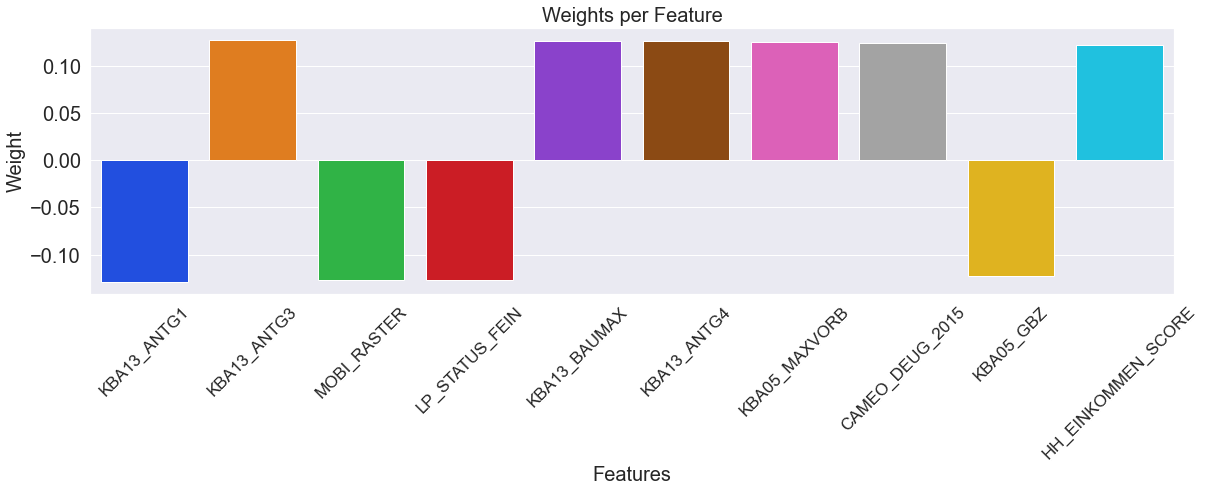

In [84]:
# Map weights for the first principal component to corresponding feature names

component_check(0,10, apl_hot_lessnan, pca)

The first 10 features of the Component 1 sorted in abs values are: [('KBA05_AUTOQUOT', 0.182076584549732), ('KBA05_ANHANG', 0.1718035366351718), ('KBA05_MOTRAD', 0.1577146974003675), ('KBA05_KRSOBER', 0.15220037309109707), ('KBA05_KRSZUL', 0.15101990520558425), ('KBA05_SEG7', 0.149612386392941), ('KBA05_SEG8', 0.14518931055085876), ('KBA05_KRSVAN', 0.14400729526108896), ('KBA05_MOTOR', 0.141811592804765), ('KBA05_DIESEL', 0.14161403444267387)]


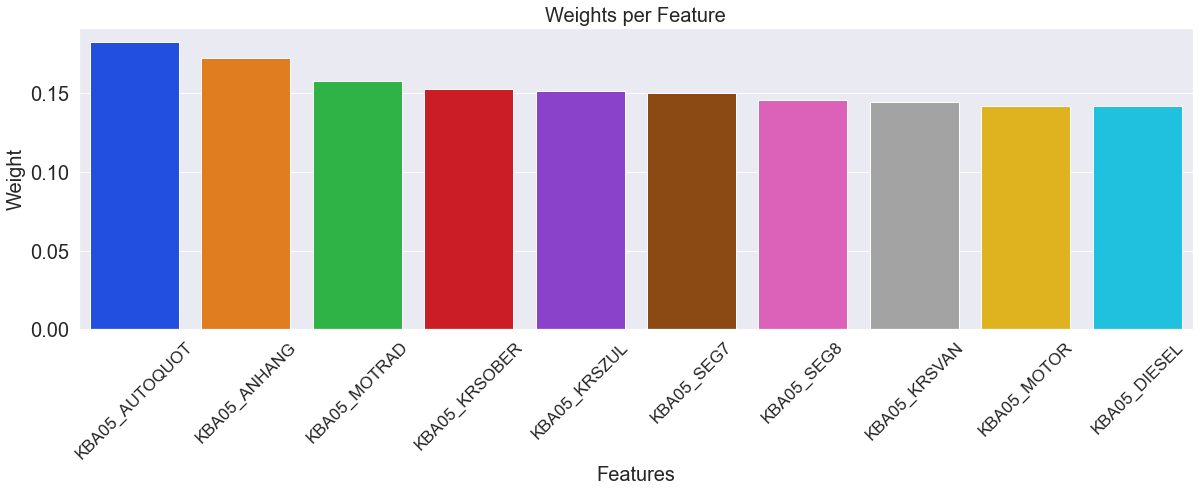

In [85]:
# Map weights for the second principal component to corresponding feature names

component_check(1,10, apl_hot_lessnan, pca)

The first 10 features of the Component 2 sorted in abs values are: [('KBA13_HERST_BMW_BENZ', -0.20902208742308742), ('KBA13_BMW', -0.17982055203382702), ('KBA13_SEG_OBEREMITTELKLASSE', -0.17854433098668046), ('KBA13_SITZE_4', -0.1655875332584632), ('KBA13_SEG_SPORTWAGEN', -0.164918957504285), ('KBA13_KMH_140_210', 0.15605883519088476), ('KBA13_KMH_211', -0.15098420873286095), ('KBA13_KW_121', -0.1490998528732251), ('KBA13_KMH_180', 0.14695058025783644), ('KBA13_CCM_2501', -0.14298806970766303)]


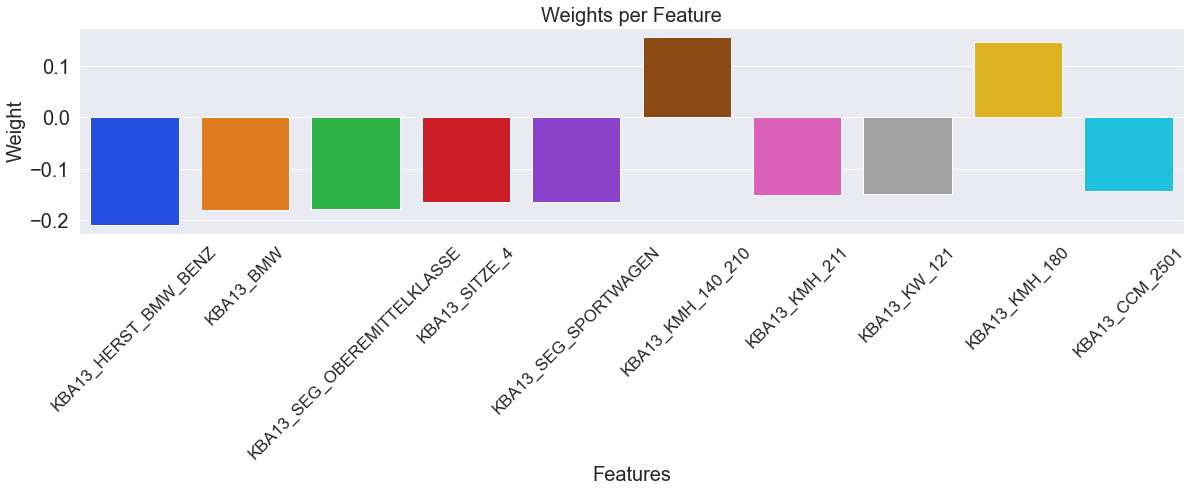

In [86]:
# Map weights for the third principal component to corresponding feature names

component_check(2,10, apl_hot_lessnan, pca)

***Observations:

The first 10 features of the Component 0 sorted in abs values are: 

('KBA13_ANTG1', -0.12905744038390998), 
('KBA13_ANTG3', 0.12727792411350447), 
('MOBI_RASTER', -0.12719086820727532), 
('LP_STATUS_FEIN', -0.12644972625160963), 
('KBA13_BAUMAX', 0.12621585248262715), 
('KBA13_ANTG4', 0.12583219144760435), 
('KBA05_MAXVORB', 0.12517178649574404), most common preowner structure in the microcell
('CAMEO_DEUG_2015', 0.12434791803946382), CAMEO classification 2015 - Uppergroup
('KBA05_GBZ', -0.12257171692753226), number of buildings in the microcell
('HH_EINKOMMEN_SCORE', 0.12148664132857787) estimated household net income 


The first 10 features of the Component 1 sorted in abs values are: 

('KBA05_AUTOQUOT', 0.182076584549732), share of cars per household
('KBA05_ANHANG', 0.1718035366351718), share of trailers in the microcell
('KBA05_MOTRAD', 0.1577146974003675), share of motorcycles per household
('KBA05_KRSOBER', 0.15220037309109707), share of upper class cars (referred to the county average)
('KBA05_KRSZUL', 0.15101990520558425), share of newbuilt cars (referred to the county average)
('KBA05_SEG7', 0.149612386392941), share of all-terrain vehicles and MUVs in the microcell
('KBA05_SEG8', 0.14518931055085876), share of roadster and convertables in the microcell
('KBA05_KRSVAN', 0.14400729526108896), share of vans (referred to the county average)
('KBA05_MOTOR', 0.141811592804765), most common engine size in the microcell
('KBA05_DIESEL', 0.14161403444267387)] share of cars with Diesel-engine in the microcell

The first 10 features of the Component 2 sorted in abs values are: 

('KBA13_HERST_BMW_BENZ', -0.20902208742308742), share of BMW & Mercedes Benz within the PLZ8
('KBA13_BMW', -0.17982055203382702), share of BMW within the PLZ8
('KBA13_SEG_OBEREMITTELKLASSE', -0.17854433098668046), share of upper middle class cars and upper class cars (BMW5er, BMW7er)
('KBA13_SITZE_4', -0.1655875332584632), number of cars with less than 5 seats in the PLZ8
('KBA13_SEG_SPORTWAGEN', -0.164918957504285), share of sportscars within the PLZ8
('KBA13_KMH_140_210', 0.15605883519088476), share of cars with max speed between 140 and 210 km/h within the PLZ8
('KBA13_KMH_211', -0.15098420873286095), share of cars with a greater max speed than 210 km/h within the PLZ8
('KBA13_KW_121', -0.1490998528732251), share of cars with an engine power more than 120 KW - PLZ8
('KBA13_KMH_180', 0.14695058025783644), share of cars with max speed between 110 km/h and 180km/h within the PLZ8
('KBA13_CCM_2501', -0.14298806970766303) share of cars with more than 2500ccm within the PLZ8


As we can see, we have here a group of people that indicates we might be talking about middle-aged generation of upper-middle class.

These people are prone to live in residential areas with lesser urban conglomerates, and seem to enjoy their vehicles.

The correlations are all positive in terms of cars- people with lots of time (maybe retired) on their hands, who can truly dedicate their hobby to maybe travelling comfortably, or just having fun with collecting, or improving classical cars.

These people seem to be very passionate about their 2/4 wheels, however it is obvious that we are talking about an older generation here, who is able to appreciate more classical cars, motorcycles, and vans (for comfort), than the modern fast ones, as would a younger generation would.

This goes hand in hand with our general population exploratory analysis- where we clearly see an overrepresentation of the older generations due to our population aging in Europe. 

As well- seeing that here we are talking about Germany- it is only normal for people to be passionate about their cars.

***

### Step 3.2:  Clustering

In this step we will apply clustering.

I will proceed to apply [k-means] clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

I will use sklearn's [KMeans]
(http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.

Then, I will use KMeans object's `.score()` method to compute the average difference from each point to its assigned cluster's center. 

I will then perform the above two steps for a number of different cluster counts, so that we will see how the average distance decreases with an increasing number of clusters. 

Each additional cluster provides a smaller net benefit. Therefore, in the end I will select a final number of clusters in which to group the data. 


Once I will have selected a final number of clusters to use, I will re-fit a KMeans instance to perform the clustering operation. 


#### Step 3.2.1: Apply Clustering to General Population


In [87]:
# Over a number of different cluster counts...

from sklearn.cluster import KMeans

    # run k-means clustering on the data and...
    
k = range(1,20)
x_vals =[]
y_vals =[]    

for i in k:
    kmeans = KMeans(n_clusters=i, random_state=0)
    model = kmeans.fit(X_pca)
    labels = model.predict(X_pca)
    
    # compute the average within-cluster distances.
    
    avg_dist=kmeans.inertia_
    x_vals.append(i)
    y_vals.append(avg_dist)
    print('For the number of {} clusters, we have {} as AVG Distance'.format(i, avg_dist))

For the number of 1 clusters, we have 231292397.9376202 as AVG Distance
For the number of 2 clusters, we have 216088844.1909382 as AVG Distance
For the number of 3 clusters, we have 204650126.65597934 as AVG Distance
For the number of 4 clusters, we have 199953662.39847928 as AVG Distance
For the number of 5 clusters, we have 196101936.94401106 as AVG Distance
For the number of 6 clusters, we have 193138762.10176337 as AVG Distance
For the number of 7 clusters, we have 190645628.80481553 as AVG Distance
For the number of 8 clusters, we have 188770686.37007707 as AVG Distance
For the number of 9 clusters, we have 187215675.7511256 as AVG Distance
For the number of 10 clusters, we have 185736059.97625497 as AVG Distance
For the number of 11 clusters, we have 184475912.1262545 as AVG Distance
For the number of 12 clusters, we have 183507116.74157226 as AVG Distance
For the number of 13 clusters, we have 182649690.2970856 as AVG Distance
For the number of 14 clusters, we have 181474612.963

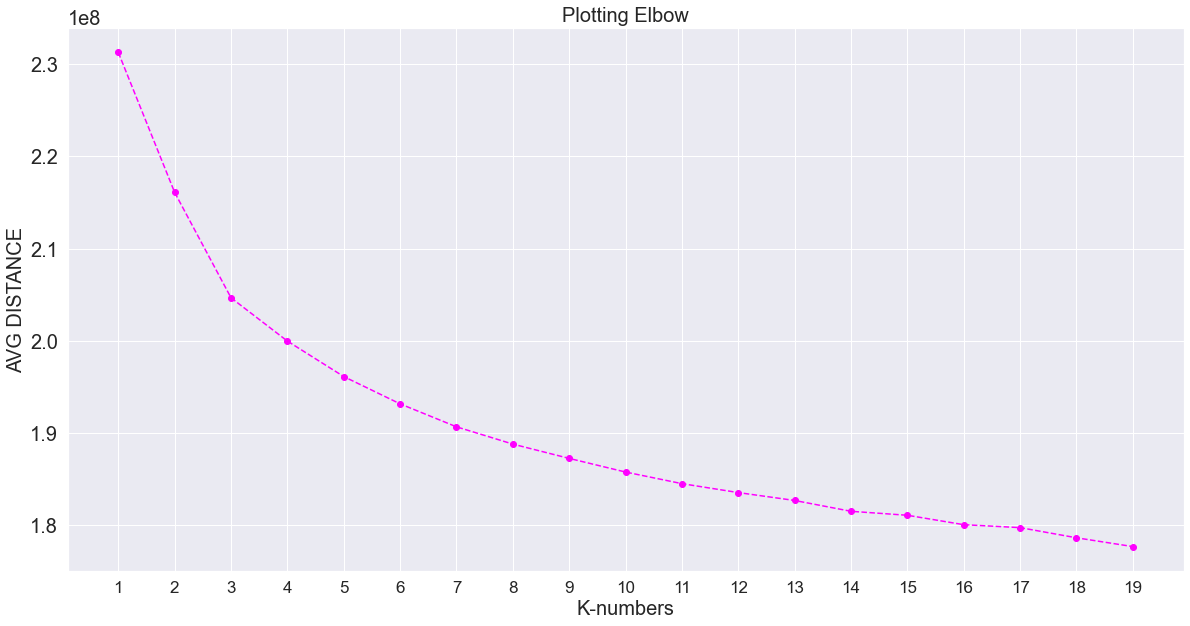

In [88]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

sns.set(rc={'figure.figsize':(20,10)})
#x_vals = np.arange(1, 20, 1)

# the below 5 rows for setting up the font sizes I researched and got from
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

plt.rc('axes', titlesize=20)    
plt.rc('axes', labelsize=20)   
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=20)


plt.plot(x_vals, y_vals, linestyle='--', marker='o', color='magenta')
plt.locator_params(integer=True)
plt.xticks(x_vals)

plt.title('Plotting Elbow')
plt.xlabel('K-numbers')
plt.ylabel('AVG DISTANCE')
plt.show()

In [89]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# no elbow is visible- I will choose 14 centroids

kmeans = KMeans(14, random_state=0)
model= kmeans.fit(X_pca)
preds = model.predict(X_pca)

***Observations:

By applying Kmeans, we find the optimal number of clusters that we can apply to the general population data.

We observe that, while the number of clusters increase, they provide a smaller net benefit.

The optimal number of clusters is pointed by the "elbow": meaning the place where the drop in benfit is not so visible, with the amount of clusters increase- which means that after that point, the clustering doesn't bring us too much adde value.

Therefore, the number of kmeans clusters I decided to keep is 14, as that seems to be a good compromise.

Since the elbow iss not so visible, any choice between 11-14 might be a good choice.***

### Step 3.2.1: Apply Clustering to Customer Data

In this section we will apply all of thw above mentioned steps to our customer data set as well.

Now that the data set is cleaned, by the use of clean_data function, we can proceed to:

- imputing data
- scaling data
- Apply PCA to the data.- we keep same number of features
- perform Clustering

In [91]:
# Apply preprocessing, feature transformation, and clustering from the general
# imputing data

imp = SimpleImputer(missing_values= np.nan, strategy='mean')
customers_imp=imp.fit_transform(customers_hot_lessnan)
np.count_nonzero(np.isnan(customers_imp))

0

In [92]:
# scaling data

scaler = StandardScaler()
customers_scaled=scaler.fit_transform(customers_imp)
print(customers_scaled)

[[-1.56047478  0.92237765 -0.37557553 ... -0.53332651  0.92703341
  -0.5630923 ]
 [ 0.8650928  -1.33201574 -0.37557553 ... -0.53332651  0.92703341
  -0.5630923 ]
 [ 0.86511086  0.17091318 -0.37557553 ...  1.87502399 -1.07870978
  -0.5630923 ]
 ...
 [ 0.95436718  0.92237765 -0.37557553 ... -0.53332651  0.92703341
  -0.5630923 ]
 [ 0.95507184  1.67384211 -0.37557553 ... -0.53332651 -1.07870978
   1.77590778]
 [ 0.95563195  1.67384211 -0.37557553 ... -0.53332651  0.92703341
  -0.5630923 ]]


In [93]:
# Apply PCA to the data.- we keep 180 features

pca_cust = PCA(180)
X_cust_pca=pca_cust.fit_transform(customers_scaled)
pca_cust.explained_variance_ratio_.sum()

0.8447231361349543

In [94]:
# Clustering

kmeans_cust = KMeans(14, random_state=0)
model_cust= kmeans_cust.fit(X_cust_pca)
preds_cust = model_cust.predict(X_cust_pca)

In [95]:
avg_dist_cust=kmeans_cust.inertia_
print('For the customer dataset, for {} clusters, the AVG distance is {}'. format(14, avg_dist_cust))

For the customer dataset, for 14 clusters, the AVG distance is 34180111.25881514


### Step 3.3: Compare Customer Data to General Population Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. 

In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. 

This part of the project is comprised by the following steps:

I will Compute the proportion of data points in each cluster for the general population and the customer data. 

I will plot visualizations both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. 

For this, I will use Seaborn's [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function.


In the end, we will be able to see which cluster or clusters are overrepresented in the customer dataset compared to the general population.

As well, we will be able to observe which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters.

In [96]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

demographic=pd.DataFrame(preds, columns=['CUSTOMER_CLUSTERS'])
demographic['CUSTOMER_INDEX'] = demographic.index

demographic_clusters = pd.DataFrame(demographic.groupby(['CUSTOMER_CLUSTERS'])['CUSTOMER_INDEX'].count().reset_index())
demographic_clusters['PERCENT_OF_MEMBERS']=(demographic_clusters['CUSTOMER_INDEX']/demographic_clusters['CUSTOMER_INDEX'].sum())*100
demographic_clusters['SOURCE']='GEN_DEMOGRAPHIC_DATA'

%matplotlib inline
demographic_clusters
#demographic.groupby('CUSTOMER_CLUSTERS').apply(lambda CUSTOMER_CLUSTERS: CUSTOMER_CLUSTERS.sum()/CUSTOMER_CLUSTERS.count())

,CUSTOMER_CLUSTERS,CUSTOMER_INDEX,PERCENT_OF_MEMBERS,SOURCE
0,0,1583,0.201548,GEN_DEMOGRAPHIC_DATA
1,1,62882,8.006152,GEN_DEMOGRAPHIC_DATA
2,2,66552,8.473417,GEN_DEMOGRAPHIC_DATA
3,3,41184,5.243557,GEN_DEMOGRAPHIC_DATA
4,4,14043,1.787958,GEN_DEMOGRAPHIC_DATA
5,5,49609,6.316230,GEN_DEMOGRAPHIC_DATA
6,6,92782,11.813028,GEN_DEMOGRAPHIC_DATA
7,7,79290,10.095223,GEN_DEMOGRAPHIC_DATA
8,8,71530,9.107218,GEN_DEMOGRAPHIC_DATA
9,9,76725,9.768646,GEN_DEMOGRAPHIC_DATA


In [97]:
# proportion of data in each cluster for the customers file 

cust=pd.DataFrame(preds_cust, columns=['CUSTOMER_CLUSTERS'])
cust['CUSTOMER_INDEX'] = cust.index

cust_clusters = pd.DataFrame(cust.groupby(['CUSTOMER_CLUSTERS'])['CUSTOMER_INDEX'].count().reset_index())
cust_clusters['PERCENT_OF_MEMBERS']=(cust_clusters['CUSTOMER_INDEX']/cust_clusters['CUSTOMER_INDEX'].sum())*100
cust_clusters['SOURCE']='CUSTOMER_DATA'
%matplotlib inline
cust_clusters

,CUSTOMER_CLUSTERS,CUSTOMER_INDEX,PERCENT_OF_MEMBERS,SOURCE
0,0,8863,6.313982,CUSTOMER_DATA
1,1,12213,8.700515,CUSTOMER_DATA
2,2,17163,12.226884,CUSTOMER_DATA
3,3,11608,8.269514,CUSTOMER_DATA
4,4,17686,12.599469,CUSTOMER_DATA
5,5,9742,6.940180,CUSTOMER_DATA
6,6,898,0.639733,CUSTOMER_DATA
7,7,13695,9.756289,CUSTOMER_DATA
8,8,11357,8.090702,CUSTOMER_DATA
9,9,5756,4.100562,CUSTOMER_DATA


In [98]:
# side-by-side
sbs=pd.DataFrame(pd.merge(left=demographic_clusters, right=cust_clusters, how='left', left_on=['CUSTOMER_CLUSTERS'], right_on=['CUSTOMER_CLUSTERS']))
d={'PERCENT_OF_MEMBERS_x': 'DEMO_PERCENT_OF_MEMBERS', 'PERCENT_OF_MEMBERS_y': 'CUST_PERCENT_OF_MEMBERS'}

sbs.rename(columns=d, inplace=True)
sbs=sbs.drop(['CUSTOMER_INDEX_x', 'CUSTOMER_INDEX_y', 'SOURCE_x', 'SOURCE_y'], axis=1)
sbs['DIFFE_CUST_DEMO']=sbs['CUST_PERCENT_OF_MEMBERS']-sbs['DEMO_PERCENT_OF_MEMBERS']

%matplotlib inline
sbs

,CUSTOMER_CLUSTERS,DEMO_PERCENT_OF_MEMBERS,CUST_PERCENT_OF_MEMBERS,DIFFE_CUST_DEMO
0,0,0.201548,6.313982,6.112434
1,1,8.006152,8.700515,0.694363
2,2,8.473417,12.226884,3.753467
3,3,5.243557,8.269514,3.025957
4,4,1.787958,12.599469,10.811510
5,5,6.316230,6.940180,0.623950
6,6,11.813028,0.639733,-11.173294
7,7,10.095223,9.756289,-0.338934
8,8,9.107218,8.090702,-1.016515
9,9,9.768646,4.100562,-5.668084


In [102]:
# we see biggest differences between the 2 clustered data sets:

over_repr = sbs.loc[sbs['DIFFE_CUST_DEMO'] == sbs['DIFFE_CUST_DEMO'].max(), 'CUSTOMER_CLUSTERS'].iloc[0]
under_repr = sbs.loc[sbs['DIFFE_CUST_DEMO'] == sbs['DIFFE_CUST_DEMO'].min(), 'CUSTOMER_CLUSTERS'].iloc[0]
print('The cluster that has most overrepresented people in customer data, compared to gen. pop. data is {}'.format(over_repr))
print('The cluster that has most underrepresented people in customer data, compared to gen. pop. data is {}'.format(under_repr))


The cluster that has most overrepresented people in customer data, compared to gen. pop. data is 4
The cluster that has most underrepresented people in customer data, compared to gen. pop. data is 6


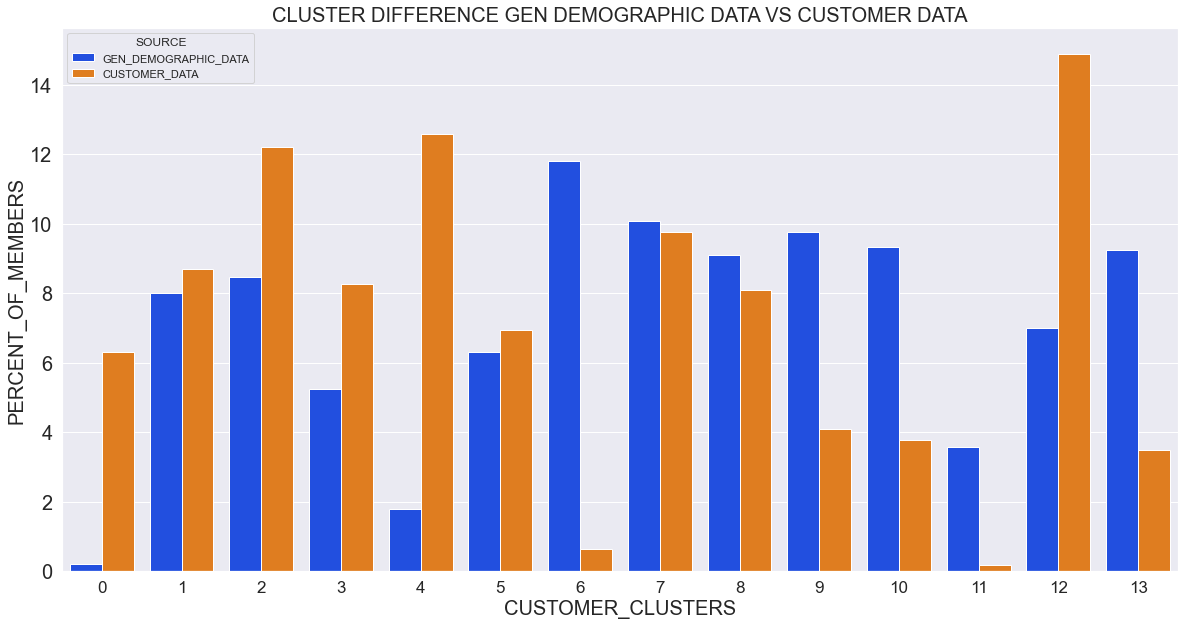

In [103]:
# barplot() the 2 results

#UNIONING my 2 sets to get 1 common DF

to_plot=pd.concat([demographic_clusters, cust_clusters], ignore_index=True)

sns.set(rc={'figure.figsize':(20,10)})
palette = sns.color_palette("bright")
plt.rc('axes', titlesize=20)    
plt.rc('axes', labelsize=20)   
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=20)

plt.xlabel('CLUSTERS')
plt.ylabel('PERCENT OF MEMBERS')
plt.title('CLUSTER DIFFERENCE GEN DEMOGRAPHIC DATA VS CUSTOMER DATA', fontsize=20)
ax = sns.barplot(x='CUSTOMER_CLUSTERS', y='PERCENT_OF_MEMBERS', hue='SOURCE', data=to_plot, palette=palette)

In [104]:
#I see my CLUSTER 4 being overrepresented in the Customer data vs General Demographics data
#I try to find the center of this cluster, and get the principal components for it, along with the weights

#I got the below .cluster_centers_ code from https://stackabuse.com/k-means-clustering-with-scikit-learn/
cluster_x = model_cust.cluster_centers_[over_repr]

cluster_x_df = pd.DataFrame(cluster_x,columns=['WEIGHTS'])
cluster_x_df=cluster_x_df.reindex(cluster_x_df.WEIGHTS.abs().sort_values(ascending=False).index)

#cluster_x_df = cluster_x_df.sort_values(by='WEIGHTS', key=abs, inplace=True)
print(cluster_x_df.head(3))

    WEIGHTS
0 -2.694873
3 -2.649905
4  2.558778


The first 10 features of the Component 0 sorted in abs values are: [('EWDICHTE', 0.16511962315267964), ('KBA13_ANTG3', 0.16459343094044698), ('MOBI_REGIO', -0.1640170922751563), ('KBA13_AUTOQUOTE', -0.1566987681501261), ('MOBI_RASTER', -0.15426840528234342), ('KBA13_ANTG1', -0.15250723565216157), ('KBA13_ALTERHALTER_60', -0.1524098583262171), ('KBA13_BAUMAX', 0.1523782843290499), ('KBA13_ANTG4', 0.15167703238028238), ('GEMEINDETYP', -0.14691901368650048)]


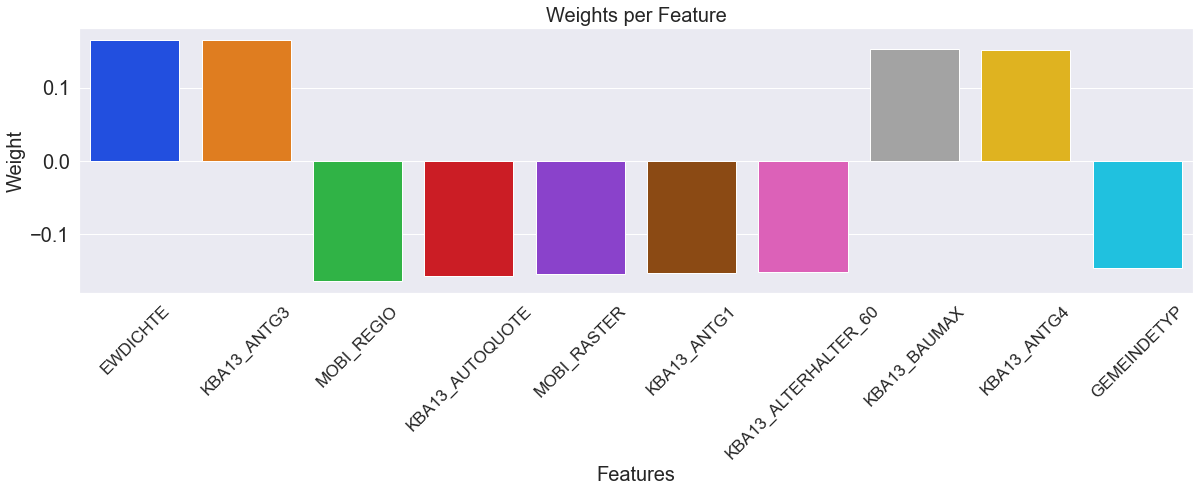

In [105]:
# plotting the components feature weights for the cust_pca - as I defined a function for this
# we see components 0 and 3 being in indirect relation with component 4, with very close abs() values. 

#component_check(component_nr, feature_nr, data, pca_x):
component_check(0,10, customers_hot_lessnan, pca_cust)

The first 10 features of the Component 3 sorted in abs values are: [('CJT_TYP_2', 0.19771853581286114), ('CJT_TYP_1', 0.19476190006249583), ('CJT_TYP_3', -0.19153163379842483), ('CJT_TYP_6', -0.1867266046848014), ('CJT_TYP_5', -0.18527975269290073), ('FINANZ_SPARER', 0.18346911323339074), ('PRAEGENDE_JUGENDJAHRE_dec', 0.17901795695573894), ('CJT_KATALOGNUTZER', -0.17209393778784304), ('KOMBIALTER', -0.16795457827100657), ('ALTERSKATEGORIE_GROB', -0.14297930873575732)]


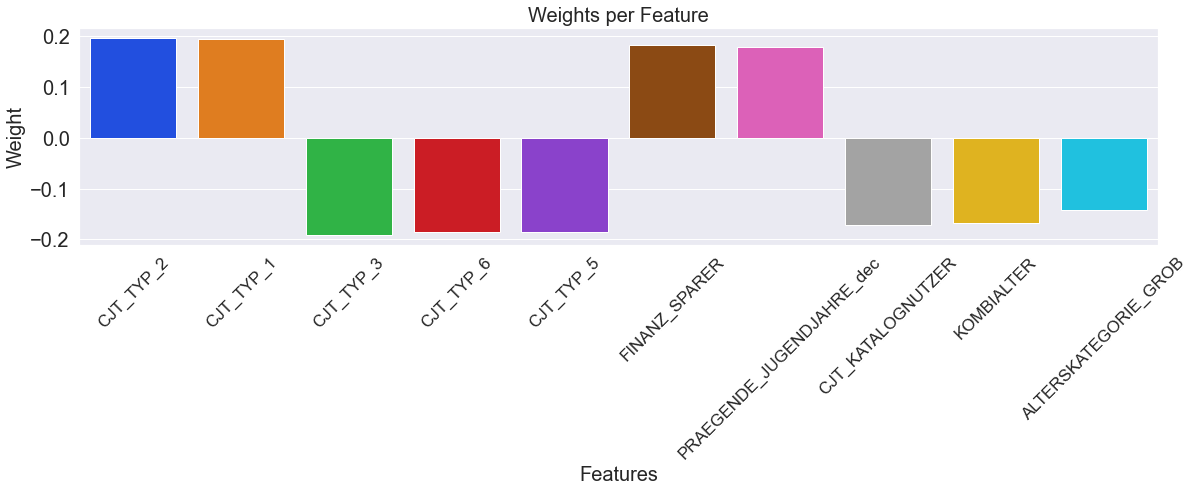

In [106]:
component_check(3,10, customers_hot_lessnan, pca_cust)

The first 10 features of the Component 4 sorted in abs values are: [('VK_DISTANZ', 0.18062784281652344), ('VK_DHT4A', 0.16173906551075135), ('ANZ_PERSONEN', -0.14051196352908152), ('D19_GESAMT_ANZ_12', -0.13083044042043152), ('LP_FAMILIE_FEIN', -0.12583693032738863), ('D19_GESAMT_OFFLINE_DATUM', 0.12113621644281503), ('ARBEIT', -0.12051082382838584), ('D19_KONSUMTYP', 0.11942632587395793), ('SEMIO_KRIT', 0.11457291629030573), ('D19_GESAMT_ONLINE_DATUM', 0.11330303974003199)]


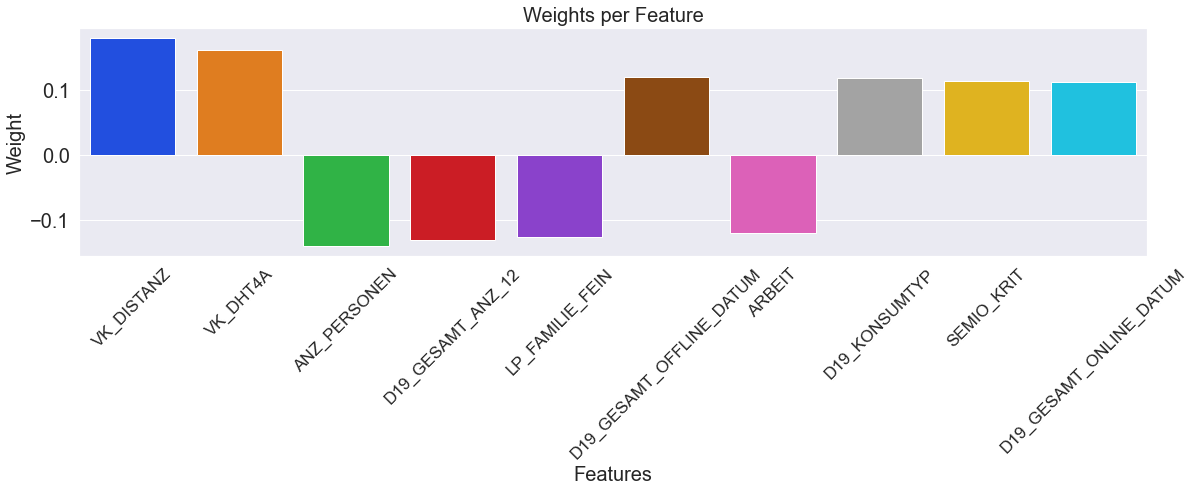

In [107]:
component_check(4,10, customers_hot_lessnan, pca_cust)

In [109]:
#I see my CLUSTER 6 being overrepresented in the General demographics data vs Customers data
#I try to find the center of the cluster 7, and get the principal components for it, along with the weights
# I did not know how to use .inverse_transform()

cluster_y = model_cust.cluster_centers_[under_repr]
cluster_y_df = pd.DataFrame(cluster_y,columns=['WEIGHTS'])
cluster_y_df=cluster_y_df.reindex(cluster_y_df.WEIGHTS.abs().sort_values(ascending=False).index)

print(cluster_y_df.head(3))

     WEIGHTS
2  39.006421
3  16.076981
1   8.279874


The first 10 features of the Component 2 sorted in abs values are: [('KBA05_SEG6', 0.2035740663374702), ('KBA05_KRSVAN', 0.17091661379397985), ('KBA05_ANHANG', 0.16675167224136211), ('KBA05_KRSKLEIN', 0.1666102353915309), ('KBA05_MAXVORB', 0.16225547317930125), ('KBA05_MOTRAD', 0.15952125093227315), ('KBA05_SEG1', 0.15703791600032688), ('KBA05_KRSOBER', 0.15493410572205898), ('KBA05_MOD8', 0.15403262843266838), ('KBA05_SEG7', 0.15233970060378624)]


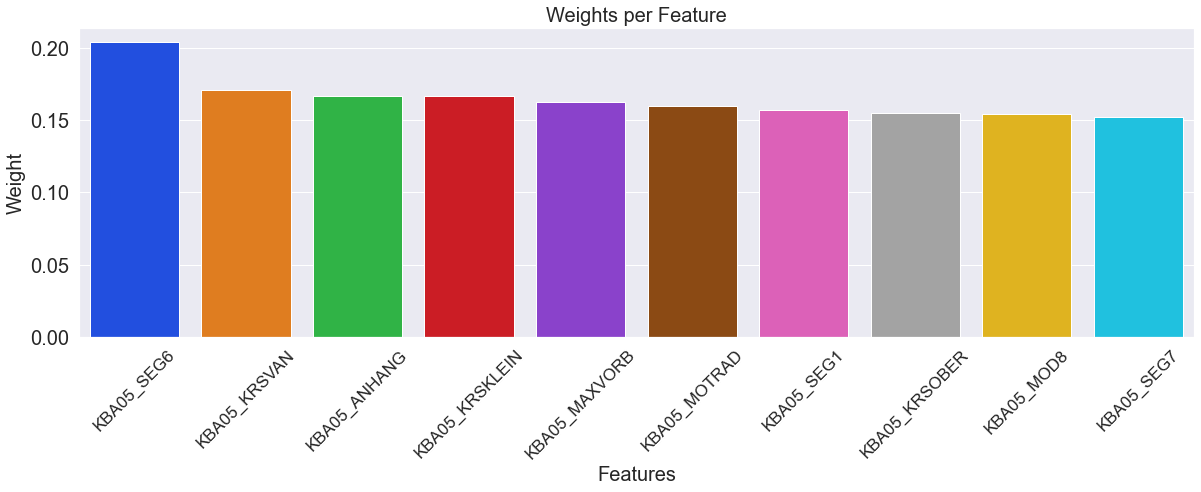

In [112]:
# plotting the components feature weights for the cust_pca - as I defined a function for this
# we see component 2 as having a lot of weight/influence in this final clustering for the customers.

component_check(2,10, customers_hot_lessnan, pca_cust)

The first 10 features of the Component 3 sorted in abs values are: [('CJT_TYP_2', 0.19771853581286114), ('CJT_TYP_1', 0.19476190006249583), ('CJT_TYP_3', -0.19153163379842483), ('CJT_TYP_6', -0.1867266046848014), ('CJT_TYP_5', -0.18527975269290073), ('FINANZ_SPARER', 0.18346911323339074), ('PRAEGENDE_JUGENDJAHRE_dec', 0.17901795695573894), ('CJT_KATALOGNUTZER', -0.17209393778784304), ('KOMBIALTER', -0.16795457827100657), ('ALTERSKATEGORIE_GROB', -0.14297930873575732)]


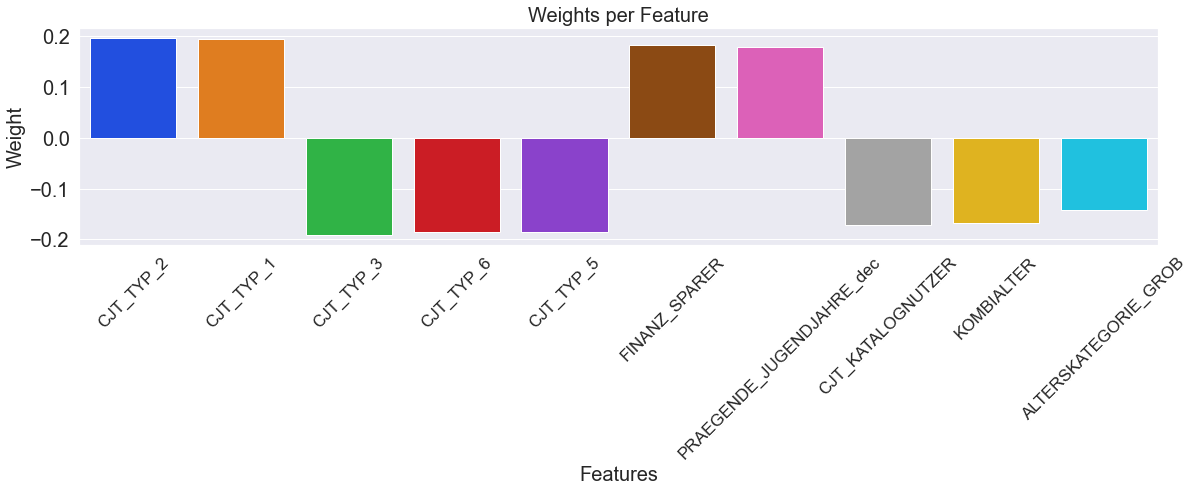

In [113]:
component_check(3,10, customers_hot_lessnan, pca_cust)

The first 10 features of the Component 1 sorted in abs values are: [('KBA13_HERST_BMW_BENZ', 0.1525985478174937), ('KBA13_KMH_180', -0.14851074219548488), ('KBA13_KW_0_60', -0.1476693879818245), ('KBA05_KW3', 0.13411228604583939), ('KBA13_KMH_211', 0.13266983877588956), ('KBA13_KRSHERST_BMW_BENZ', 0.1300677051129219), ('KBA13_MERCEDES', 0.12962558234688998), ('KBA13_SEG_OBEREMITTELKLASSE', 0.12953316224908), ('KBA13_KW_121', 0.12833542739903178), ('KBA05_HERST1', 0.12800697165192115)]


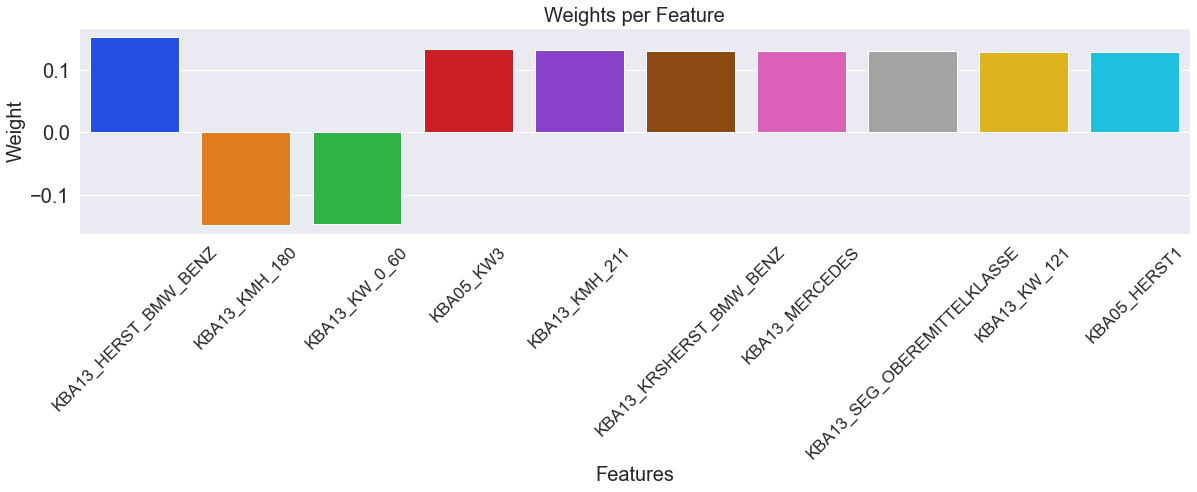

In [114]:
component_check(1,10, customers_hot_lessnan, pca_cust)

***Observations:

So, as we can observe, we have certain clusters that are overrepresented in the Customers data vs general population data, and some that are under represented comparing to general population data.

The cluster that has most over-represented people in customer data, compared to gen. pop. data is cluster 4.

For this cluster, we have 3 principal components (top 3) which have the following weights:
('EWDICHTE', 0.16511962315267964), density of inhabitants per square kilometer
('KBA13_ANTG3', 0.16459343094044698), share of cars- but no description on this one
('MOBI_REGIO', -0.1640170922751563), moving patterns
('KBA13_AUTOQUOTE', -0.1566987681501261), share of cars per household within the PLZ8
('MOBI_RASTER', -0.15426840528234342), no description- translation in eng: mobile grid
('KBA13_ANTG1', -0.15250723565216157), no description
('KBA13_ALTERHALTER_60', -0.1524098583262171), share of car owners between 46 and 60 within the PLZ8
('KBA13_BAUMAX', 0.1523782843290499),  no description (means max size of construction)
('KBA13_ANTG4', 0.15167703238028238), no description
('GEMEINDETYP', -0.14691901368650048) no description: but has eng translation : community type

('CJT_TYP_2', 0.19771853581286114), customer journey typology 2 Advertising- and Consumptiontraditionalist
('CJT_TYP_1', 0.19476190006249583), customer journey typology 1 Advertising- and Consumptionminimalist
('CJT_TYP_3', -0.19153163379842483), customer journey typology 3 advertisinginterested Store-shopper
('CJT_TYP_6', -0.1867266046848014), customer journey typology 6 Advertising-Enthusiast with restricted Cross-Channel-Behaviour 
('CJT_TYP_5', -0.18527975269290073), customer journey typology 5 Advertising- and Cross-Channel-Enthusiast
('FINANZ_SPARER', 0.18346911323339074), financial typology: money saver
('PRAEGENDE_JUGENDJAHRE_dec', 0.17901795695573894), DEFINING_YEARS OF YOUTH - decade
('CJT_KATALOGNUTZER', -0.17209393778784304), no description- but has eng translation catalogue users
('KOMBIALTER', -0.16795457827100657), no description- translation in eng: estate
('ALTERSKATEGORIE_GROB', -0.14297930873575732) age classification through prename analysis 

('VK_DISTANZ', 0.18062784281652344), no description- but means distance
('VK_DHT4A', 0.16173906551075135), 
('ANZ_PERSONEN', -0.14051196352908152), number of adult persons in the household
('D19_GESAMT_ANZ_12', -0.13083044042043152), transaction activity TOTAL POOL in the last 12 months 
('LP_FAMILIE_FEIN', -0.12583693032738863), familytyp fine
('D19_GESAMT_OFFLINE_DATUM', 0.12113621644281503), actuality of the last transaction with the complete file OFFLINE
('ARBEIT', -0.12051082382838584), 
('D19_KONSUMTYP', 0.11942632587395793), consumption type 
('SEMIO_KRIT', 0.11457291629030573), affinity indicating in what way the person is critical minded
('D19_GESAMT_ONLINE_DATUM', 0.11330303974003199) actuality of the last transaction with the complete file ONLINE

The people in the above cluster seem to belong to a group of population that is very:
-Traditionalist in consumption;
-Has slower moving pattersn;
-Does not necessarily own a car anymore;
-Is critically minded;
-Is very careful with the finances;
-prefers offline shopping- and is not open to travelling to stores and/or online;

The people in this category might be people beyond the age of retirement- and even older generation who is just enjoying the quite years and being careful with their finances.

This group of people lives in urban areas, however they do not have a big family anymore, they are mostly 1-2-person families.

We see a positive correlation on the features that indicate the age, the traditional mindset, and an negative correlation for the ones that indicate movement, online/in-store shopping affinity.




The cluster that has most under-represented people in customer data, compared to gen. pop. data is cluster 6.

For this cluster, we have 3 principal components (top 3) which have the following weights:


('KBA05_SEG6', 0.2035740663374702), share of upper class cars (BMW 7er etc.) in the microcell
('KBA05_KRSVAN', 0.17091661379397985), share of vans (referred to the county average)
('KBA05_ANHANG', 0.16675167224136211), share of trailers in the microcell
('KBA05_KRSKLEIN', 0.1666102353915309), share of small cars (referred to the county average)
('KBA05_MAXVORB', 0.16225547317930125), most common preowner structure in the microcell
('KBA05_MOTRAD', 0.15952125093227315), share of motorcycles per household
('KBA05_SEG1', 0.15703791600032688), share of very small cars (Ford Ka etc.) in the microcell
('KBA05_KRSOBER', 0.15493410572205898), share of upper class cars (referred to the county average)
('KBA05_MOD8', 0.15403262843266838), share of vans (in an AZ specific definition)
('KBA05_SEG7', 0.15233970060378624) share of all-terrain vehicles and MUVs in the microcell

('CJT_TYP_2', 0.19771853581286114), customer journey typology 2 Advertising- and Consumptiontraditionalist
('CJT_TYP_1', 0.19476190006249583), customer journey typology 1 Advertising- and Consumptionminimalist
('CJT_TYP_3', -0.19153163379842483), customer journey typology 3 advertisinginterested Store-shopper
('CJT_TYP_6', -0.1867266046848014), customer journey typology 6 Advertising-Enthusiast with restricted Cross-Channel-Behaviour 
('CJT_TYP_5', -0.18527975269290073), customer journey typology 5 Advertising- and Cross-Channel-Enthusiast
('FINANZ_SPARER', 0.18346911323339074), financial typology: money saver
('PRAEGENDE_JUGENDJAHRE_dec', 0.17901795695573894), DEFINING_YEARS OF YOUTH - decade
('CJT_KATALOGNUTZER', -0.17209393778784304), no description- but has eng translation catalogue users
('KOMBIALTER', -0.16795457827100657), no description- translation in eng: estate
('ALTERSKATEGORIE_GROB', -0.14297930873575732) age classification through prename analysis 

('KBA13_HERST_BMW_BENZ', 0.1525985478174937), share of BMW & Mercedes Benz within the PLZ8
('KBA13_KMH_180', -0.14851074219548488), share of cars with max speed between 110 km/h and 180km/h within the PLZ8
('KBA13_KW_0_60', -0.1476693879818245), share of cars up to 60 KW engine power - PLZ8
('KBA05_KW3', 0.13411228604583939), share of cars with an engine power of more than 119 KW
('KBA13_KMH_211', 0.13266983877588956), share of cars with a greater max speed than 210 km/h within the PLZ8
('KBA13_KRSHERST_BMW_BENZ', 0.1300677051129219), share of BMW/Mercedes Benz (referred to the county average) - PLZ8
('KBA13_MERCEDES', 0.12962558234688998), share of MERCEDES within the PLZ8
('KBA13_SEG_OBEREMITTELKLASSE', 0.12953316224908), share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
('KBA13_KW_121', 0.12833542739903178), share of cars with an engine power more than 120 KW - PLZ8
('KBA05_HERST1', 0.12800697165192115) share of top German manufacturer (Mercedes, BMW) 

People who fall in this category are: the car lovers on both sides: powerful ones, new, old and motorcycles. This group of of people belonging to upper-middle class is the one that is the least prone to become a customer of the company- it seems.

***

## Part 4: Supervised Learning Model: Model Evaluation and Validation

Now that we've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

Due to time considerations, I have decided to only test 2 algorithms - with the attempt to improve it by choosing various parameters for it.

The algorithms chosen are 
 - [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

Parameter tuning will be performed with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

As well, I will compare the ROC score for the trained models, by testing it on the test data as well.
Method used here for this purpose is [.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

ROC, or [“Receiver Characteristic Operator”  - “Area Under the Curve”] helps us visualize how well our machine learning classifier is performing. It is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. 
The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes:

- AUC is 0; classifier is predicting all Negatives as Positives, and all Positives as Negatives.

- AUC=0.5: classifier is not able to distinguish between Positive and Negative class points.

- 0.5<AUC<1: high chance that the classifier will be able to distinguish the positive class values from the negative class values. 




In a ROC curve, a higher X-axis value indicates a higher number of False positives than True negatives. While a higher Y-axis value indicates a higher number of True positives than False negatives. So, the choice of the threshold depends on the ability to balance between False positives and False negatives.


Formula for Sensitivity / True Positive Rate / Recall below:

<img loading="lazy" class="size-full wp-image-67063 aligncenter" src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/06/sensitivity.gif" alt="Sensitivity formula" width="195" height="39" />

Formula for False Negative Rate below:

<img loading="lazy" class="size-full wp-image-67077 aligncenter" src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/06/FNR.gif" alt="False Negative Rate" width="150" height="39" />


Formula for Specificity / True Negative Rate below:

<img loading="lazy" class="size-full wp-image-67064 aligncenter" src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/06/Specificity.gif" alt="Specificity formula" width="196" height="39" />


Formula for False Positive Rate below:

<img loading="lazy" class="size-full wp-image-67078 aligncenter" src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/06/FPR.gif" alt="False Positive Rate" width="293" height="39" />

Source: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

The reason for choosing this method of evaluation is due to the fact that we have very limited data. 

Upon checking the training data- I was able to notice that within the training set, we have a rather scarce distribution of responses, in the sense that people that have actually responded are 532, out of 42.962 possible responses.
This means that we actualy have data to train the algorithm on for only 1.2% of the cases- which is very little.

As well- since we have this lack of information for the customers, we need to use a powerful algorithm that will use gradient descent, and that is capable of doing randomization while training, meaning splitting the set while in training at random points.

For this purpose, I chose XGBoost and GradientBoosting.

I will then try to calibrate the algorithms, by using GridSearchCV and see if we can get better results.


### Step 4.1: XGBoost

In this step, we use XGBoost as our ML algorithm, and we try to see how well it performs before and after the GridSearch Parameter tuning.

Spes followed here are:

- loading the training data and separating the responses from the actual set used in training;
- cleaning our training data;
- splitting our training data into training and validation sets, at a percentage of 33% (meaning training will be performed on 67% of the training data, and the validation itself will be performed on 33%;
- fitting the XGBoost model first on the training set (not many hyper-parameters set here;
- predicting on the validation set, and calculating the .roc_auc() score 
- choosing a list of hyper-parameter values to fine tune
- using GridSearchCV in finding the best model;
- fitting again the best model found to the training set;
- run inference/ make predictions on the validation set, with the best model found.


In [112]:
# we load the training data

mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\lupascu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [113]:
mailout_train=mailout_train.drop(['Unnamed: 0'], axis=1)

In [114]:
display(mailout_train)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338,2,1.0,0.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,1.0,1.0,4.0,8.0,7.0,1,0,1,4
42958,67629,-1,1.0,0.0,NaN,NaN,NaN,NaN,14.0,1.0,...,1.0,1.0,1.0,5.0,9.0,7.0,1,0,1,3
42959,68273,1,1.0,16.0,NaN,NaN,NaN,NaN,10.0,2.0,...,1.0,2.0,1.0,2.0,9.0,7.0,1,0,1,4
42960,68581,2,1.0,18.0,NaN,NaN,NaN,NaN,13.0,3.0,...,2.0,3.0,4.0,2.0,9.0,2.0,3,0,2,4


In [115]:
# let's check the data structure for the training data

print('Total number of responses within the training data set is :{} %'.format(100*mailout_train['RESPONSE'].sum()/mailout_train.shape[0]))
print(mailout_train['RESPONSE'].sum())
print(mailout_train.shape[0])

Total number of responses within the training data set is :1.2383036171500397 %
532
42962


In [116]:
# we check data structure - we see we have the 6 categorical/mixed features

print(mailout_train.shape)
pd.DataFrame(mailout_train.dtypes, columns=['DATA_TYPE']).DATA_TYPE.value_counts()

(42962, 367)


float64    267
int64       94
object       6
Name: DATA_TYPE, dtype: int64

In [117]:
# we separate the training data inot 2 sections: X and y
# X will contain the features of the data
# y contains only the responses

train_df = mailout_train.drop('RESPONSE',axis=1)
y_true = mailout_train['RESPONSE']

In [118]:
print(np.unique(np.array(y_true.values)).tolist())

[0, 1]


In [119]:
# we run the training data through the cleaning process first, in order to prepare it for the algorithm

train_df= clean_data_ml(train_df)

In [120]:
# we check the structure of the data, after the cleaning process, to make sure we have all accepted feature types

print(train_df.shape)
pd.DataFrame(train_df.dtypes, columns=['DATA_TYPE']).DATA_TYPE.value_counts()

(42962, 404)


float64    262
int64       96
uint8       45
int32        1
Name: DATA_TYPE, dtype: int64

In [121]:
#  we scale and standardize the training data set.

imp = SimpleImputer(missing_values= np.nan, strategy='mean')
mailout_train_imp=imp.fit_transform(train_df)
scaler = StandardScaler()
mailout_train_scaled=scaler.fit_transform(mailout_train_imp)

In [122]:
# we check data structure for the the training data set again- after imputation and standardization

print(np.count_nonzero(np.isnan(mailout_train_imp)))
print(mailout_train_scaled.shape)
print()
print('y_true shape: {}'.format(y_true.shape))

0
(42962, 404)

y_true shape: (42962,)


In [123]:
# we apply the standard step when it comes to ML: 
# we split our data between trainign and validation sets

X_train, X_val, y_train, y_val = train_test_split(mailout_train_scaled, y_true, test_size=0.33, random_state=42)

In [124]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(28784, 404)
(14178, 404)
(28784,)
(14178,)


In [125]:
# we use the XGBRegressor 

# instantiate model
model_xgb = xgb.XGBRegressor()

start_time = time.time()

# fit model on training data
model_xgb.fit(X_train,y_train)

print("--- %s seconds ---" % (time.time() - start_time))


# run inference on the validation data
y_pred = model_xgb.predict(X_val)

# we calculate the ROC score
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, y_pred)))

--- 12.358516931533813 seconds ---
ROC score on validation data: 0.6261


In [126]:
# we try to optimize the model, based on GridSearchCV
# parameter tuning tips and trics taken from:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters


# we define the dictionary of parameters
params = { 'learning_rate' : [0.05, 0.8],
           'subsample': [0.5, 0.8],
           'colsample_bytree': [0.5, 0.8],
           'n_estimators': [400],
           'seed': [42],
           'objective': ['binary:logistic'],
           'eval_metric' : ['auc']
             }

start_time = time.time()
# we instantiate the grid search
cv = GridSearchCV(model_xgb, params, verbose=2)

# we fit the model on our training data
cv_model=cv.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

# Get the best model based on the gridsearch
model_xgb_new = cv_model.best_estimator_
print(model_xgb_new)

# Make predictions based on the best model, on the validation data
y_pred_new = model_xgb_new.predict(X_val)

# we show again the ROC score
print("ROC score on validation data for new model: {:.4f}".format(roc_auc_score(y_val, y_pred_new)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END colsample_bytree=0.5, eval_metric=auc, learning_rate=0.05, n_estimators=400, objective=binary:logistic, seed=42, subsample=0.5; total time=  23.4s
[CV] END colsample_bytree=0.5, eval_metric=auc, learning_rate=0.05, n_estimators=400, objective=binary:logistic, seed=42, subsample=0.5; total time=  24.3s
[CV] END colsample_bytree=0.5, eval_metric=auc, learning_rate=0.05, n_estimators=400, objective=binary:logistic, seed=42, subsample=0.5; total time=  24.4s
[CV] END colsample_bytree=0.5, eval_metric=auc, learning_rate=0.05, n_estimators=400, objective=binary:logistic, seed=42, subsample=0.5; total time=  23.2s
[CV] END colsample_bytree=0.5, eval_metric=auc, learning_rate=0.05, n_estimators=400, objective=binary:logistic, seed=42, subsample=0.5; total time=  31.4s
[CV] END colsample_bytree=0.5, eval_metric=auc, learning_rate=0.05, n_estimators=400, objective=binary:logistic, seed=42, subsample=0.8; total time=  26.9s
[CV]

In [127]:
print(cv_model.best_params_)

{'colsample_bytree': 0.5, 'eval_metric': 'auc', 'learning_rate': 0.05, 'n_estimators': 400, 'objective': 'binary:logistic', 'seed': 42, 'subsample': 0.5}


### Step 4.2: GradientBoosting

In this step, we use GradientBoosting as our ML algorithm, and we try to see how well it performs before and after the GridSearch Parameter tuning.

Spes followed here are:


- fitting the model first on the training set (with minimum to no hyper-arameters set);
- running inference/ make predictions on the validation set, and calculating the .roc_auc() score 
- choosing a list of hyper-parameter values to fine tune
- using GridSearchCV in finding the best model;
- fitting again the best model found to the training set;
- running inference/ make predictions on the validation set, with the best model found.


In [128]:
# trying out the GradientBoostingRegressor as well

# instantiate model
model_grad = GradientBoostingRegressor()

start_time = time.time()
# fit model on training data
model_grad.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

# run inference on the validation data
y_pred_grad = model_grad.predict(X_val)

# we calculate the ROC score
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, y_pred_grad)))

--- 78.28596782684326 seconds ---
ROC score on validation data: 0.7695


In [129]:
# we try to optimize the model, based on GridSearchCV as well

# we define the dictionary of parameters
params2 = { 'learning_rate' : [0.05, 0.08],
            'n_estimators' : [150, 200],
            'criterion': ['squared_error'],
            #'min_samples_split': [5, 10, 20],
            'random_state': [42]
             }

start_time = time.time()
# we instantiate the grid search
cv_grad = GridSearchCV(model_grad, params2, verbose=2)

# we fit the model on our training data
cv_model_grad=cv_grad.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

# Get the best model based on the gridsearch
model_grad_new = cv_model_grad.best_estimator_
print(model_grad_new)

# we run inference on our validation data, by using the best estimator expressed above
y_pred_grad_new = model_grad_new.predict(X_val)

# we calculate the ROC score 
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, y_pred_grad_new)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END criterion=squared_error, learning_rate=0.05, n_estimators=150, random_state=42; total time= 1.6min
[CV] END criterion=squared_error, learning_rate=0.05, n_estimators=150, random_state=42; total time= 1.6min
[CV] END criterion=squared_error, learning_rate=0.05, n_estimators=150, random_state=42; total time= 1.6min
[CV] END criterion=squared_error, learning_rate=0.05, n_estimators=150, random_state=42; total time= 1.6min
[CV] END criterion=squared_error, learning_rate=0.05, n_estimators=150, random_state=42; total time= 1.6min
[CV] END criterion=squared_error, learning_rate=0.05, n_estimators=200, random_state=42; total time= 2.1min
[CV] END criterion=squared_error, learning_rate=0.05, n_estimators=200, random_state=42; total time= 2.2min
[CV] END criterion=squared_error, learning_rate=0.05, n_estimators=200, random_state=42; total time= 2.2min
[CV] END criterion=squared_error, learning_rate=0.05, n_estimators=200, rand

In [130]:
print(cv_model_grad.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.05, 'n_estimators': 150, 'random_state': 42}


***Justification :

After running 4 sessions with the 2 different algorithms, we can see the various scores received for each of the models before and after the hyper=parameter tuning:

1. XGBoost:
   - Attempt 1: roc_auc score: 0.6261 (time of training 12.35 seconds) 
   - Attempt 2: roc_auc score: 0.7206 (time of training 1494.87 seconds) (after hyper-param tuning)
   - best model is: {'colsample_bytree': 0.5, 'eval_metric': 'auc', 'learning_rate': 0.05, 'n_estimators': 400, 'objective': 'binary:logistic', 'seed': 42, 'subsample': 0.5}
    
   
2. GradientBoosting:
   - Attempt 1: roc_auc score: 0.7695 (time of training: 78.28 seconds)
   - Attempt 2: roc_auc score: 0.7733 (time of training: 2420.41 seconds)
   - best model is: {'criterion': 'squared_error', 'learning_rate': 0.05, 'n_estimators': 150, 'random_state': 42}
   
I would choose the best version I was able to produce: meaning XGBoost. The time for the training would definitely be higher for the GradientBoosting one, but the difference in roc_auc score is not so high. 
The time to train the GradientBoosting algorithm is more than 1 min- as opposed to 12 seconds for the XGBoost.
This means that, with further parameter tuning, XGBoost could get to the same values as GradientBoosting, and in a much faster time.

XGBoost seems the obvious choice for real-life cases, where time is a resource that people might not have too much of.

However, for the purpose of our Kaggle exercise, I will choose the GradientBoosting best model.
***

### Step 4.3: Predicting on TEST data- submission for Kaggle competition

In here, we try to make a submission on the Kaggle competition site, by running inference on the `Udacity_MAILOUT_052018_TEST.csv` data.

For this, I chose the best model determined in the previous 2 steps- GradientBoosting attempt 2: model_grad_new.

Spes followed here are:

- cleaning our test data (imputing and standardizing as well);
- predicting on the testing set, and calculating the .roc_auc() score 
- putting the predictions in a new data frame, whic in turn will be submitted as a CSV.


In [131]:
# load data
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\lupascu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [132]:
mailout_test=mailout_test.drop(['Unnamed: 0'], axis=1)

In [133]:
display(mailout_test)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,67615,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1
42829,67938,0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,2.0,...,4.0,10.0,9.0,6.0,6.0,9.0,3.0,3,1,4
42830,67942,-1,1.0,16.0,14.0,17.0,NaN,NaN,15.0,1.0,...,2.0,1.0,1.0,1.0,1.0,9.0,3.0,2,1,3
42831,67949,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,1.0,4.0,4.0,2.0,6.0,9.0,3.0,3,2,3


In [134]:
# Let's test this on the TESTING data online
# First, we try to see if the testing data has the same shape as the training one.

mailout_test.shape

(42833, 366)

In [136]:
# we clean the test data as well and we check the shape again

mailout_test_pure = clean_data_ml(mailout_test)


imp = SimpleImputer(missing_values= np.nan, strategy='mean')
mailout_test_imp=imp.fit_transform(mailout_test_pure)
scaler = StandardScaler()
mailout_test_scaled=scaler.fit_transform(mailout_test_imp)

print(np.count_nonzero(np.isnan(mailout_test_imp)))
print(mailout_test_scaled.shape)
print(mailout_test_scaled.shape)

0
(42833, 404)
(42833, 404)


In [138]:
# we run inference on the testing data - I need to chose one of the models only!

pred_test_new1 = model_grad_new.predict(mailout_test_scaled)

print(pred_test_new1)
print(pred_test_new1.shape)

[0.03133536 0.02473004 0.00569277 ... 0.03238097 0.05261423 0.02181875]
(42833,)


In [143]:
# we create a data frame with the inference and we post it on the website

lnr_list=mailout_test['LNR'].tolist()
pred_list=pred_test_new1.tolist()

d = {'LNR':lnr_list,'RESPONSE':pred_list}

final_df= pd.DataFrame(d)
print(len(lnr_list))
print(len(pred_list))
print(final_df.shape)
display(final_df)

42833
42833
(42833, 2)


,LNR,RESPONSE
0,1754,0.031335
1,1770,0.024730
2,1465,0.005693
3,1470,0.007038
4,1478,0.003014
...,...,...
42828,67615,0.011491
42829,67938,0.010397
42830,67942,0.032381
42831,67949,0.052614


In [144]:
# we save the results in a CSV file
final_df.to_csv('lupascu_gradientboost_submission.csv')

## Part 5: Conclusion:

The models can definitely be improved more. In time, the hyper-parameter tuning can become an art, and with experience, comes intuition in how to calibrate these as much as possible.

From a time resource- I would definitely choose XGB.

From a score perspective, I would choose GradientBoosting, however the time to train it is very long.

All in all, the entire project was very useful in refreshing the memory regarding the unsupervised model vs the supervised one.

It was a very beautiful way of going back to past projects, and applying the learnings again (and using new learnings, to be able to overcome hurdles).

The main difficulty I found was the computing power for PCA: due to the initial high number of features, the memory was running out, so I had to find new ways of reducing the number of columns.

This is why I investigated online, and was able to find useful links about how to reduce the highly correlated features.

Main hurdles that I had to overcome:

From a technical standpoint:
- Computational problem when performing PCA;
- Computational problem when performing data cleaning, due to the size of the general population data;
- Long computational times when performing Gradient Boosting.

From a process standpoint:
- Using the correlation matrix in reducing the dimensionality prior to PCA causes the dimension to reduce, but it also causes different shapes of the training and testing data in the end, therefore it produces clean data sets, however they won't be able to be used in the model  in the end.
- It is tricky to decide if we need to drop the rows with too little information: dropping them helps us in performing PCA, however it impacts in a bad way the supervised training models- as I registered small (around 0.6) initial ROC scores with rows dropped, and higher when rows were kept.
- What was hard for me as was to locate certain features in the explanation files coming form AZDIAS- it seems that multiple feature names were lacking explanations, so I had to look for them online (to find the English translation).

What can be improved:

- More testing from the point of view of the supervised and unsupervised models.
- Things I would do (if I had the time): try to run PCA on a data set in which the rows with very little information are kept in the set, and assess if we get different results;
- More parameter tuning for the XGBoost and GradientBoosting models- I believe XGBoost has a lot of potential in improvement, especially because it is faster than GradientBoosting however it requires a lot of time.